# **Rejection Evaluation**
***

## **Seed 10**
***

We trained resnet50 on RSNAPneumonia dataset. This is a binary classification task which classifies chest X-ray images as either sick or normal. Let's take a look at the results dataframe:

In [1]:
import pandas as pd
output_path = r"C:\Computer_Vision\Medical_Images_With_Rejection\OurSolution\failure_detection_benchmark\outputs_train\RSNAPneumonia\resnet50\dropout_all_layers_autolr_paper\seed_10\failure_detection\scores_df.csv"
scores_df = pd.read_csv(output_path)
scores_df.head()

Targets  Predictions  IsCorrect    Probas  Threshold  Baseline  \
0        0        False       True  0.006509     0.2514  0.993491   
1        1        False      False  0.004871     0.2514  0.995129   
2        0        False       True  0.017060     0.2514  0.982940   
3        0        False       True  0.024324     0.2514  0.975676   
4        0        False       True  0.014682     0.2514  0.985318   

   doctor_alpha  mcmc_soft_scores  mcmc_predictions  mcmc_probas  ...  \
0     -0.013104          0.989641             False     0.010359  ...   
1     -0.009789          0.992970             False     0.007030  ...   
2     -0.034702          0.983886             False     0.016114  ...   
3     -0.049829          0.974338             False     0.025662  ...   
4     -0.029794          0.981458             False     0.018542  ...   

   Laplace_threshold  Laplace_score  Laplace_probas  TrustScore  \
0           0.257537       0.977948        0.022052    1.302095   
1           0.257537       0.979635        0.020365    1.613619   
2           0.257537       0.964553        0.035447    1.372737   
3           0.257537       0.955047        0.044953    1.478028   
4           0.257537       0.967387        0.032613    1.515524   

   ConfidNet_scores  SWAG_probas  SWAG_targets  SWAG_predictions  \
0          0.993790     0.004734             0             False   
1          0.995934     0.022046             1             False   
2          0.981188     0.056983             0             False   
3          0.972065     0.047792             0             False   
4          0.981107     0.013802             0             False   

   SWAG_threshold  SWAG_score  
0        0.299343    0.995266  
1        0.299343    0.977954  
2        0.299343    0.943017  
3        0.299343    0.952208  
4        0.299343    0.986198  

[5 rows x 23 columns]

Let's see what columns do we have in here:

In [2]:
scores_df.columns

Index(['Targets', 'Predictions', 'IsCorrect', 'Probas', 'Threshold',
       'Baseline', 'doctor_alpha', 'mcmc_soft_scores', 'mcmc_predictions',
       'mcmc_probas', 'mcmc_entropy_scores', 'Laplace_targets',
       'Laplace_predictions', 'Laplace_threshold', 'Laplace_score',
       'Laplace_probas', 'TrustScore', 'ConfidNet_scores', 'SWAG_probas',
       'SWAG_targets', 'SWAG_predictions', 'SWAG_threshold', 'SWAG_score'],
      dtype='object')

The dataframe consists of the following columns:
* Targets - Our GT classes.
* Predictions - The predicted classes
* IsCorrect - Is that classification correct or not?
* Probas - the probability of making a prediction.
* Threshold - The decision threshold that will yield the FPR as closest to 0.2 as possible.
* Baseline - Baseline softmax scorer.
* doctor_alpha - It is a scorer that quantifies the likelihood of being misclassified , and thus negative (as stated in the article).
* mcmc-soft-scores, mcmc-entropy scores - From the paper: "MC-dropout (MC): Gal & Ghahramani (2016) showed that training a neural network with dropout
regularization (Srivastava et al., 2014) produces a Bayesian approximation of the posterior, where the
approximation is obtained by Monte-Carlo sampling of the network’s parameters i.e. by applying
dropout at test-time and averaging the outputs over several inference passes. The confidence in
the prediction can then be approximated by the negative entropy of the outputs; or by taking the
softmax confidence score on the averaged outputs."
* mcmc predictions - predictions made by using Monte-Carlo sampling on the network's parameters.
* mcmc_probas - probabilities of the predictions for monte-carlo sampling.
* Laplace_targets - The targets for the laplace method. They are the same as the general targets.
* Laplace predictions - predictions made by Laplace
* Laplace threshold - In Laplace score, for binary classification problem, it computes the ROC curve for the validation set, and searches for the threshold that will yield a False Positive Rate as close as possible to 0.2. That threshold is saved in that column.
* Laplace score -Laplace confidence score
* Laplace_probas - probabilities of laplace predictions (classifying 0 or 1)
* TrustScore - Score made by TrustScore scorer.
* ConfidNet scores- scores made by ConfidNet
* SWAG_probas - probabilities of SWAG predictions (classifying 0 or 1)
* SWAG_targets - targets for SWAG method. The same as the general targets.
* SWAG_predictions - The predictions made by SWAG
* SWAG threshold - In SWAG score, for binary classification problem, it computes the ROC curve for the validation set, and searches for the threshold that will yield a False Positive Rate as close as possible to 0.2. That threshold is saved in that column.
* SWAG_score - SWAG confidence scores

We used The Baseline scorer, doctor-alpha, MC- softmax, MC- entropy, Laplace, TrustScore, ConfidNet, and SWAG (8 overall). The ones missing (as compared to the paper) are DUQ (which we failed to train due to insufficient CUDA memory) and ensemble (we used only 1 seed so ensemble is irrelevant). Let's check for sure that all target columns are identical:


In [3]:
# Lowercase the column names before checking
lower_case_columns = [col.lower() for col in scores_df.columns]

# Find all columns containing the word 'target'
target_columns = [col for col in scores_df.columns if 'target' in col.lower()]

# Compare the values between target columns
are_identical = all(scores_df[target_columns[0]].equals(scores_df[col]) for col in target_columns[1:])

if are_identical:
    print(f"All target columns are identical: {target_columns}")
else:
    differing_columns = [col for col in target_columns if not scores_df[target_columns[0]].equals(scores_df[col])]
    differences = {col: scores_df[[target_columns[0], col]].drop_duplicates() for col in differing_columns}
    print(f"Columns that differ: {differing_columns}")
    print(f"Differences: {differences}")

All target columns are identical: ['Targets', 'Laplace_targets', 'SWAG_targets']


So, Now we can begin the thresholding procedure:

### **Thresholding**
***

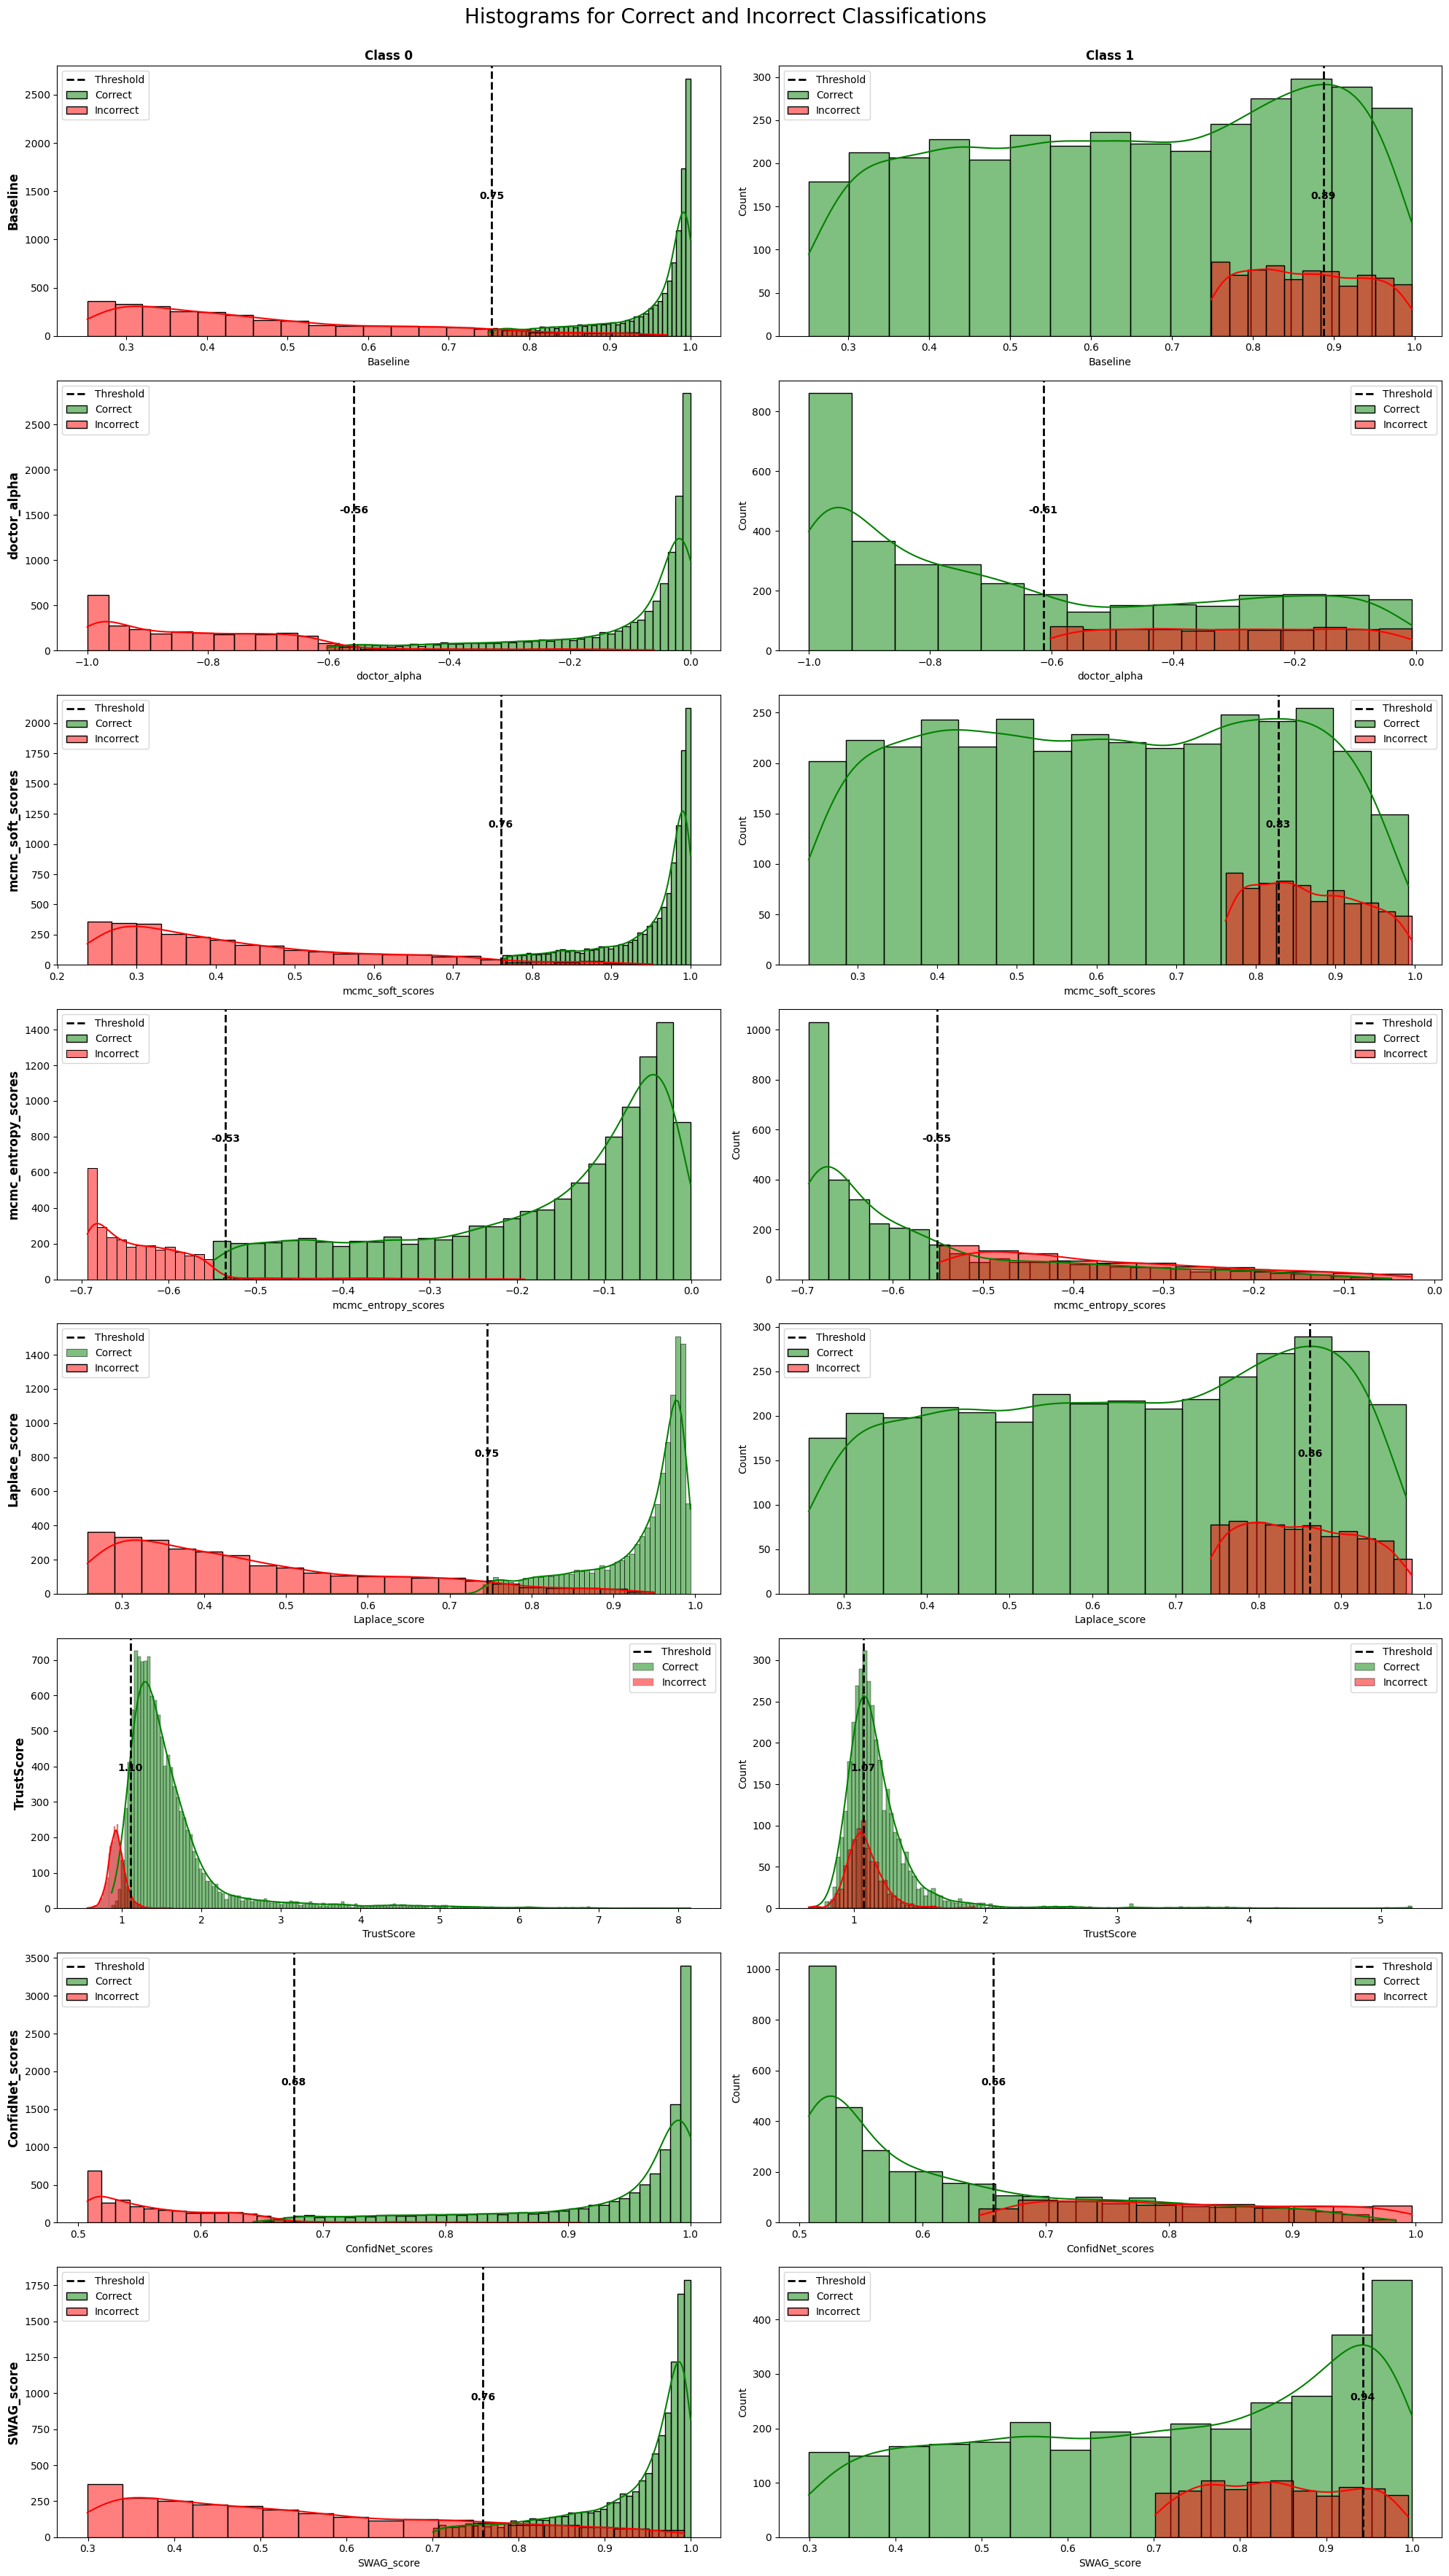

Seed       Scoring_Method  Class  Threshold
0     10             Baseline      0   0.753408
1     10             Baseline      1   0.887523
2     10         doctor_alpha      0  -0.558637
3     10         doctor_alpha      1  -0.613683
4     10     mcmc_soft_scores      0   0.760434
5     10     mcmc_soft_scores      1   0.828312
6     10  mcmc_entropy_scores      0  -0.534464
7     10  mcmc_entropy_scores      1  -0.551094
8     10        Laplace_score      0   0.745659
9     10        Laplace_score      1   0.862160
10    10           TrustScore      0   1.103290
11    10           TrustScore      1   1.072917
12    10     ConfidNet_scores      0   0.676162
13    10     ConfidNet_scores      1   0.657435
14    10           SWAG_score      0   0.758623
15    10           SWAG_score      1   0.942332

In [4]:
from rejection.thresholding import find_thresholds
thresholds_with_class_separation = find_thresholds(scores_df,visualize=True, separate_classes=True,confidnet=True, swag=True)
thresholds_with_classes_separation_dict = {"Seed": len(thresholds_with_class_separation.keys()) * [10],
                                           "Scoring_Method":[method for method, _ in thresholds_with_class_separation.keys()],
                                           "Class":[cls for _, cls in thresholds_with_class_separation.keys()],"Threshold":thresholds_with_class_separation.values()}
thresholds_with_class_separation_df = pd.DataFrame(thresholds_with_classes_separation_dict)
display(thresholds_with_class_separation_df)

We can see that the classes separation resulted in a great overlap between the histograms in a way that will make it difficult to find a threshold that separates between them (Especially when dealing with class 1 - The sick chests!). Instead, let's try to drop the classes separation:

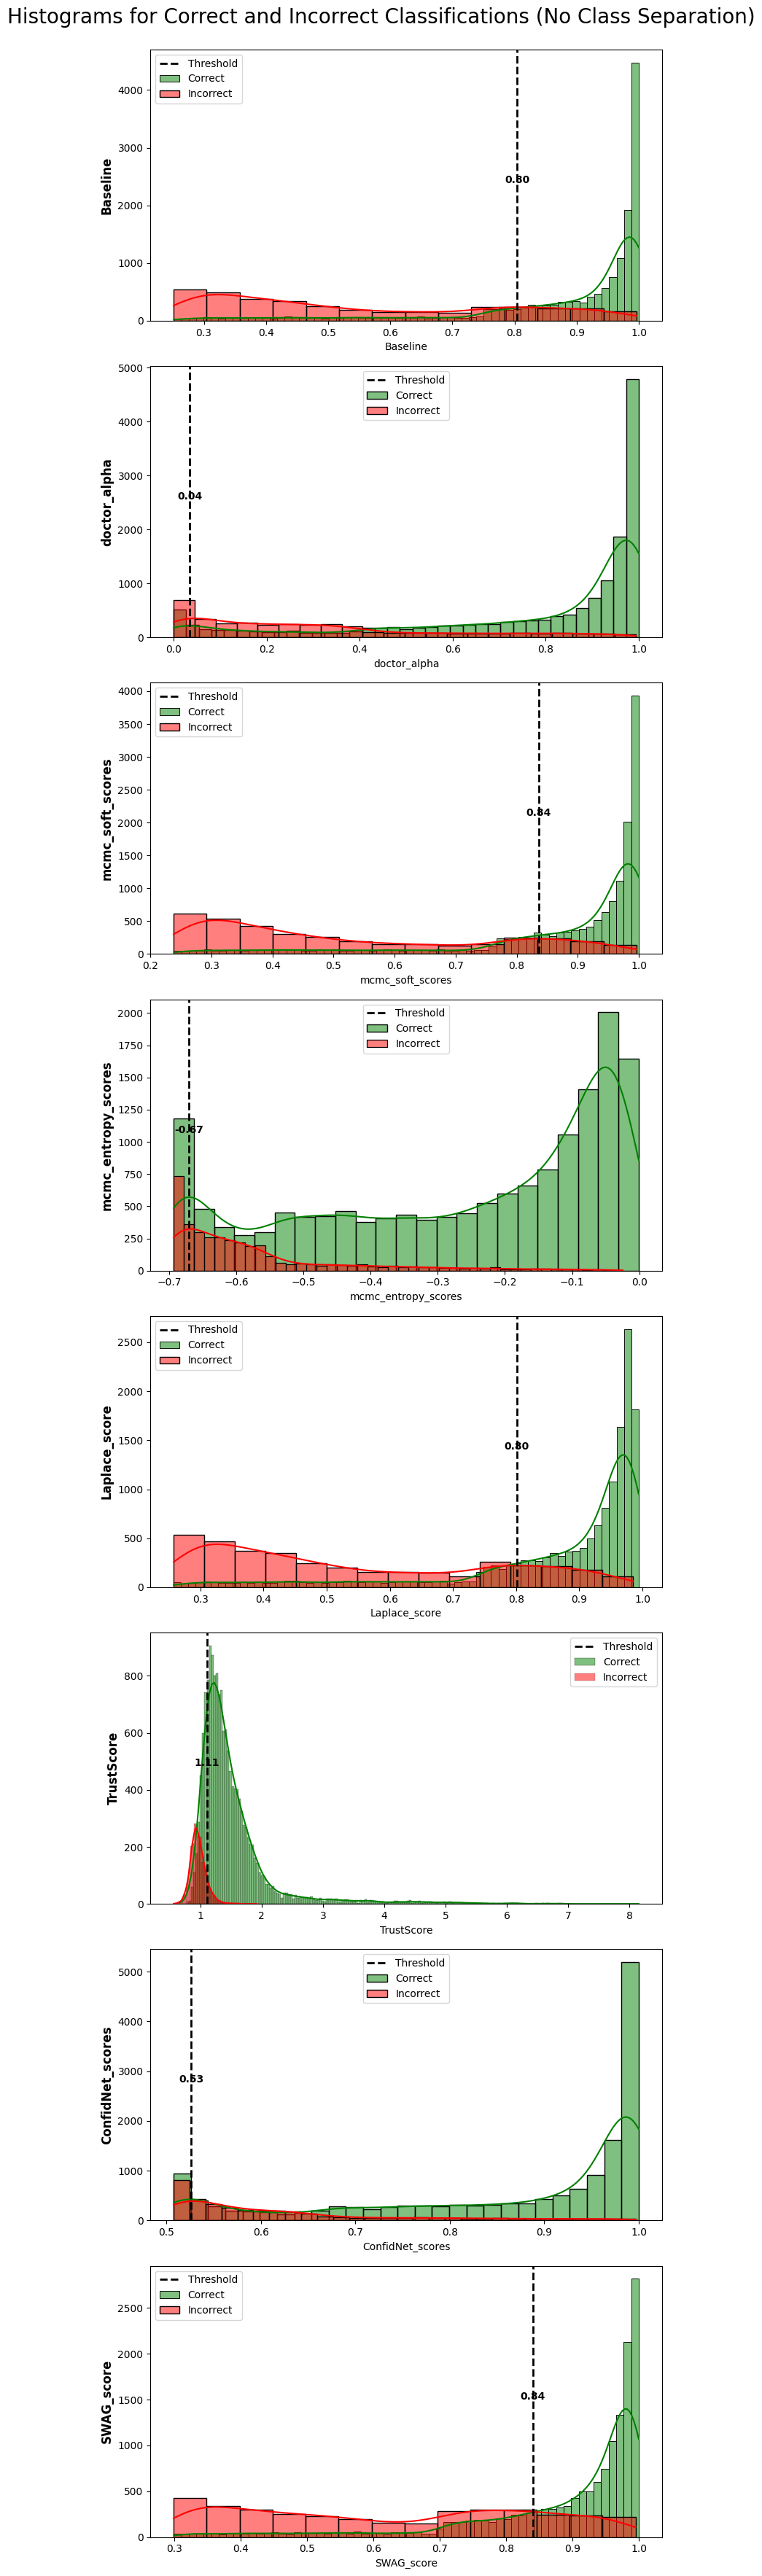

Seed       Scoring_Method  Threshold
0    10             Baseline   0.804357
1    10         doctor_alpha   0.035029
2    10     mcmc_soft_scores   0.835938
3    10  mcmc_entropy_scores  -0.670280
4    10        Laplace_score   0.800960
5    10           TrustScore   1.110883
6    10     ConfidNet_scores   0.526341
7    10           SWAG_score   0.840661

In [5]:
thresholds_without_class_separation = find_thresholds(scores_df, visualize=True, separate_classes=False, confidnet=True,
                                                   swag=True)
thresholds_without_classes_separation_dict = {"Seed": len(thresholds_without_class_separation.keys()) * [10],
                                           "Scoring_Method": [method for method in
                                                              thresholds_without_class_separation.keys()],
                                           "Threshold": thresholds_without_class_separation.values()}
thresholds_without_class_separation_df = pd.DataFrame(thresholds_without_classes_separation_dict)
display(thresholds_without_class_separation_df)

Still the Trustscore and the mcmc_entropy does not give us a good separation, so we will just drop them:


In [6]:
# Drop the rows where Scoring_Method is 'TrustScore' or 'mcmc_entropy_scores'
filtered_thresholds_without_class_separation_df = thresholds_without_class_separation_df[
    ~thresholds_without_class_separation_df['Scoring_Method'].isin(['TrustScore', 'mcmc_entropy_scores'])
]
filtered_thresholds_without_class_separation_df = filtered_thresholds_without_class_separation_df.reset_index(drop=True)
display(filtered_thresholds_without_class_separation_df)

Seed    Scoring_Method  Threshold
0    10          Baseline   0.804357
1    10      doctor_alpha   0.035029
2    10  mcmc_soft_scores   0.835938
3    10     Laplace_score   0.800960
4    10  ConfidNet_scores   0.526341
5    10        SWAG_score   0.840661

In [7]:
# Find all columns containing the word 'predictions' (case-insensitive)
prediction_columns = [col for col in scores_df.columns if 'predictions' in col.lower()]
print(prediction_columns)

['Predictions', 'mcmc_predictions', 'Laplace_predictions', 'SWAG_predictions']


### **Find optimal weights for the scores**
***


We will find the optimal weight for each score according to how much of (in percentage) of the wrong classifications it managed to reject. A score that does not exceed the threshold - will get a weight of 0.

In [8]:
from rejection.confidence_score import find_optimal_weights
weights_df = find_optimal_weights(dataframe=scores_df,thresholds=filtered_thresholds_without_class_separation_df)
display(weights_df)

Scoring_Method  Threshold Rejection_Direction    Weight
0          Baseline   0.804357                   <  0.801078
1      doctor_alpha   0.035029                   <  0.164690
2  mcmc_soft_scores   0.835938                   <  0.849451
3     Laplace_score   0.800960                   <  0.817696
4  ConfidNet_scores   0.526341                   <  0.232615
5        SWAG_score   0.840661                   <  0.798183

### **Calculate Confidence Scores**
***

We will use the weights we found earlier in order to create a confidence score which is the weighted sum of all the scores we described earlier.

In [9]:
from rejection.confidence_score import calculate_confidence_score
scores_df_test = pd.read_csv(
    r"C:\Computer_Vision\Medical_Images_With_Rejection\OurSolution\failure_detection_benchmark\outputs\RSNAPneumonia\resnet50\dropout_all_layers_autolr_paper\seed_10\failure_detection\scores_df.csv")
confidence_scores_df = calculate_confidence_score(dataframe=scores_df_test,weights=weights_df)
display(confidence_scores_df)

Targets  Predictions  IsCorrect    Probas  Threshold  Baseline  \
0           0        False       True  0.120629     0.2514  0.879371   
1           0        False       True  0.015437     0.2514  0.984563   
2           0        False       True  0.204569     0.2514  0.795431   
3           0        False       True  0.020883     0.2514  0.979117   
4           1         True       True  0.404807     0.2514  0.404807   
...       ...          ...        ...       ...        ...       ...   
5332        0         True      False  0.414607     0.2514  0.414607   
5333        0        False       True  0.016182     0.2514  0.983818   
5334        1         True       True  0.716283     0.2514  0.716283   
5335        1         True       True  0.897099     0.2514  0.897099   
5336        0        False       True  0.006760     0.2514  0.993240   

      doctor_alpha  mcmc_soft_scores  mcmc_predictions  mcmc_probas  ...  \
0        -0.269286          0.872454             False     0.127546  ...   
1        -0.031350          0.980743             False     0.019257  ...   
2        -0.482450          0.798938             False     0.201062  ...   
3        -0.042638          0.973877             False     0.026123  ...   
4        -0.930043          0.399427              True     0.399427  ...   
...            ...               ...               ...          ...  ...   
5332     -0.943318          0.384239              True     0.384239  ...   
5333     -0.032887          0.972169             False     0.027831  ...   
5334     -0.684758          0.692529              True     0.692529  ...   
5335     -0.226429          0.857830              True     0.857830  ...   
5336     -0.013610          0.991054             False     0.008946  ...   

      Laplace_score  Laplace_probas  TrustScore  ConfidNet_scores  \
0          0.861275        0.138725    1.021478          0.832027   
1          0.965907        0.034093    1.366800          0.982724   
2          0.780711        0.219289    1.150789          0.706421   
3          0.961532        0.038468    1.470300          0.972814   
4          0.408548        0.408548    1.026057          0.538007   
...             ...             ...         ...               ...   
5332       0.416400        0.416400    1.085031          0.528210   
5333       0.966852        0.033148    1.277399          0.981498   
5334       0.708652        0.708652    0.946856          0.548512   
5335       0.874433        0.874433    1.191389          0.764287   
5336       0.977124        0.022876    1.577930          0.993575   

      SWAG_probas  SWAG_targets  SWAG_predictions  SWAG_threshold  SWAG_score  \
0        0.077146             0             False        0.322991    0.922854   
1        0.051407             0             False        0.322991    0.948593   
2        0.044643             0             False        0.322991    0.955357   
3        0.027361             0             False        0.322991    0.972639   
4        0.373209             1              True        0.322991    0.373209   
...           ...           ...               ...             ...         ...   
5332     0.389461             0              True        0.322991    0.389461   
5333     0.055352             0             False        0.322991    0.944648   
5334     0.868984             1              True        0.322991    0.868984   
5335     0.967013             1              True        0.322991    0.967013   
5336     0.020007             0             False        0.322991    0.979993   

      Confidence_score  
0            51.332662  
1            56.622812  
2            15.447886  
3            56.674752  
4             2.085805  
...                ...  
5332          2.047821  
5333         56.447136  
5334         13.686664  
5335         51.866483  
5336         57.497311  

[5337 rows x 24 columns]

### **Rejection**
***

Now, for the final step - we will reject every sample that does not exceed a given confidence level. We will test many confidence levels and plot a graph of the Model's Accuracy (calculated on thr non-rejected samples) Vs. the Rejection Rate. In addition, we will plot the 10 lowest rejection rates gained and the best accuracy gained for those same rejection rates.

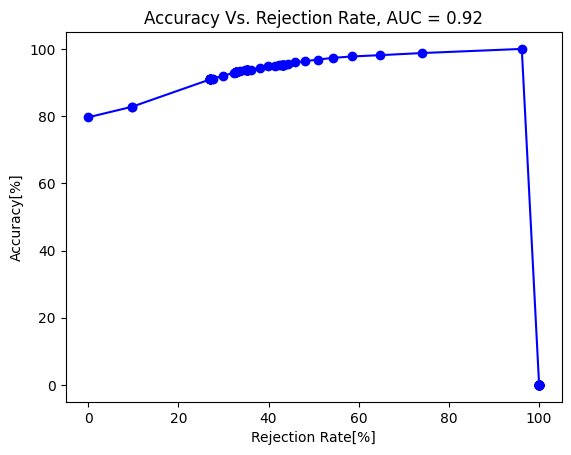

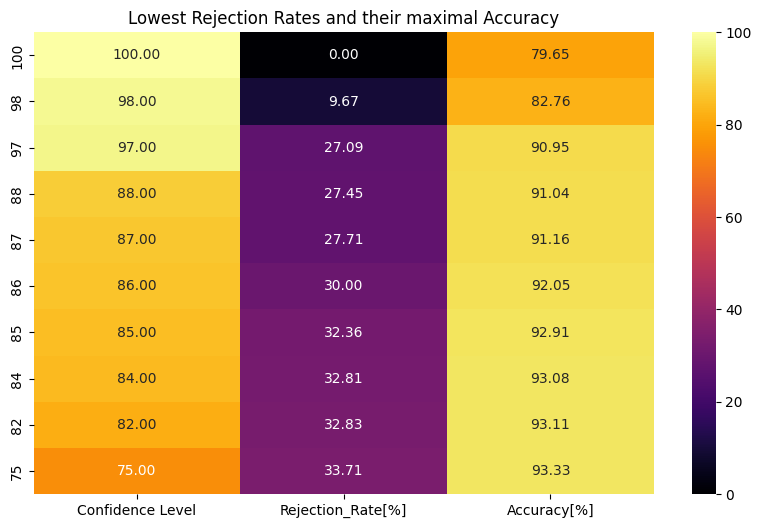

In [10]:
from rejection.rejection import reject
import numpy as np


confidence = np.linspace(0,100,101)
graph_df, lowest_rejections, _  = reject(dataframe=confidence_scores_df,confidence_level=confidence, visualize=True, output_points=True, get_lowest_rejection=True)

In [11]:
display(lowest_rejections)

Confidence Level  Rejection_Rate[%]  Accuracy[%]
100             100.0           0.000000    79.651490
98               98.0           9.668353    82.762912
97               97.0          27.093873    90.953482
88               88.0          27.449878    91.038223
87               87.0          27.712198    91.161223
86               86.0          29.998126    92.050321
85               85.0          32.359003    92.908587
84               84.0          32.808694    93.084216
82               82.0          32.827431    93.110181
75               75.0          33.708076    93.329565

We can see that the more we reject the more accurate the model gets, until we reject everything and get 0% accuracy. Now, let's view the confusion matrix of the rejection being applied or not Vs. Was it a right decision or not.

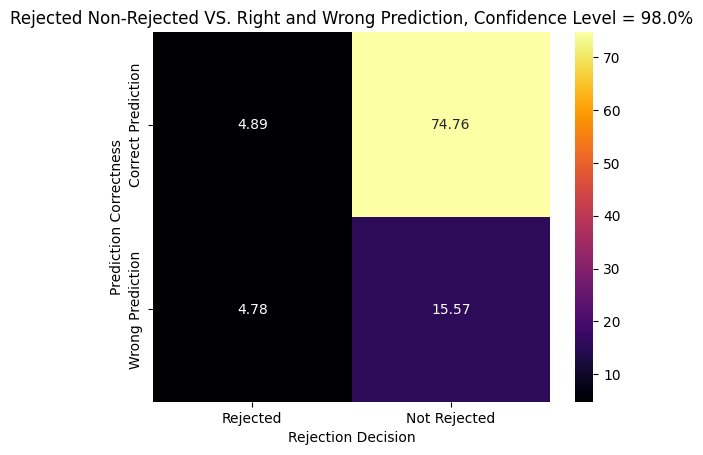

In [12]:
from rejection.rejection import rejection_confusion_matrix
rejection_confusion_matrix(dataframe=confidence_scores_df,confidence_level=lowest_rejections["Confidence Level"].iloc[1])


We can see that unfortunately our rejector made more wrong decisions than correct ones. Now we can repeat the process of fetching parameters from each seed, validating on the other seeds and averaging for finding the best seed performance.

## **Validation**
***

## **Train seed: 10**
***

### **Thresholding**
***

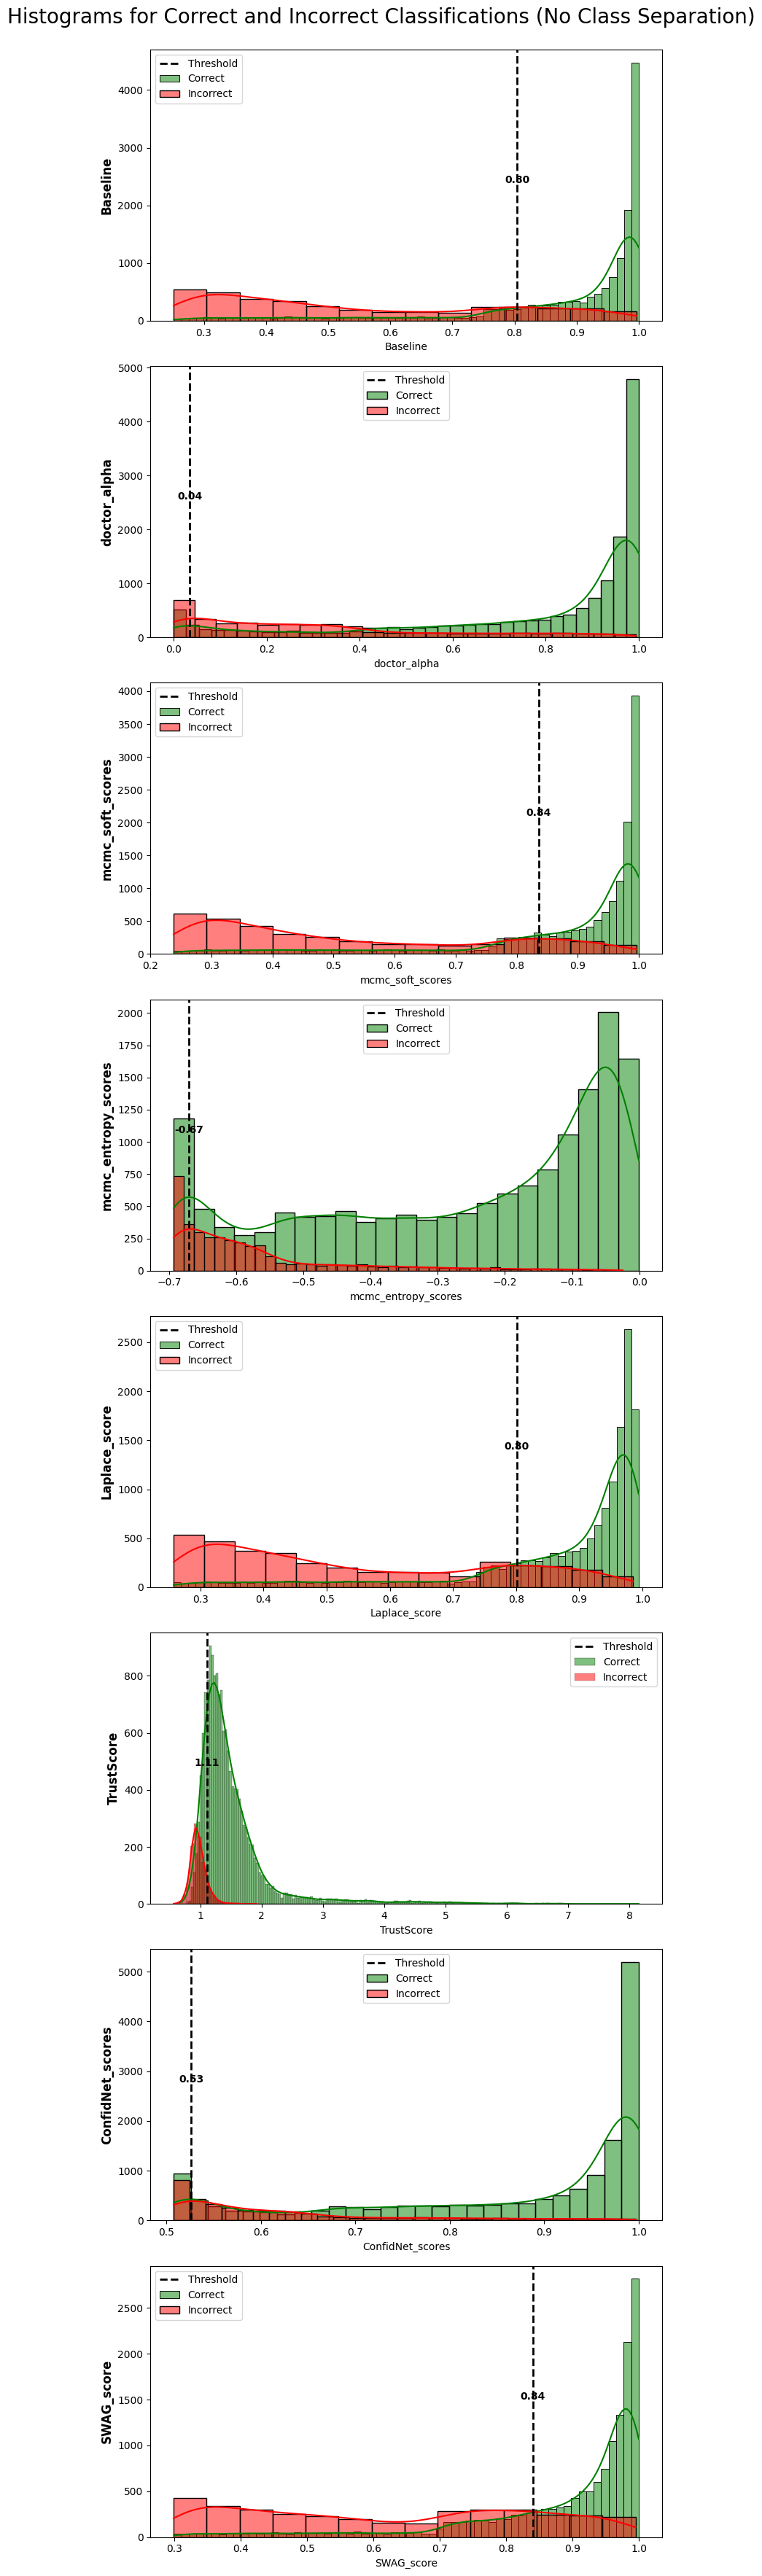

Seed    Scoring_Method  Threshold
0    10          Baseline   0.804357
1    10      doctor_alpha   0.035029
2    10  mcmc_soft_scores   0.835938
3    10     Laplace_score   0.800960
4    10  ConfidNet_scores   0.526341
5    10        SWAG_score   0.840661

### **Finding Optimal weights**
***

Scoring_Method  Threshold Rejection_Direction    Weight
0          Baseline   0.804357                   <  0.801078
1      doctor_alpha   0.035029                   <  0.164690
2  mcmc_soft_scores   0.835938                   <  0.849451
3     Laplace_score   0.800960                   <  0.817696
4  ConfidNet_scores   0.526341                   <  0.232615
5        SWAG_score   0.840661                   <  0.798183

### **Validation process**
***

#### **Validation seed: 10**
***

##### **Calculate confidence score**
***

Targets  Predictions  IsCorrect    Probas  Threshold  Baseline  \
0           0        False       True  0.120629     0.2514  0.879371   
1           0        False       True  0.015437     0.2514  0.984563   
2           0        False       True  0.204569     0.2514  0.795431   
3           0        False       True  0.020883     0.2514  0.979117   
4           1         True       True  0.404807     0.2514  0.404807   
...       ...          ...        ...       ...        ...       ...   
5332        0         True      False  0.414607     0.2514  0.414607   
5333        0        False       True  0.016182     0.2514  0.983818   
5334        1         True       True  0.716283     0.2514  0.716283   
5335        1         True       True  0.897099     0.2514  0.897099   
5336        0        False       True  0.006760     0.2514  0.993240   

      doctor_alpha  mcmc_soft_scores  mcmc_predictions  mcmc_probas  ...  \
0         0.730714          0.872454             False     0.127546  ...   
1         0.968650          0.980743             False     0.019257  ...   
2         0.517550          0.798938             False     0.201062  ...   
3         0.957362          0.973877             False     0.026123  ...   
4         0.069957          0.399427              True     0.399427  ...   
...            ...               ...               ...          ...  ...   
5332      0.056682          0.384239              True     0.384239  ...   
5333      0.967113          0.972169             False     0.027831  ...   
5334      0.315242          0.692529              True     0.692529  ...   
5335      0.773571          0.857830              True     0.857830  ...   
5336      0.986390          0.991054             False     0.008946  ...   

      Laplace_score  Laplace_probas  TrustScore  ConfidNet_scores  \
0          0.861275        0.138725    1.021478          0.832027   
1          0.965907        0.034093    1.366800          0.982724   
2          0.780711        0.219289    1.150789          0.706421   
3          0.961532        0.038468    1.470300          0.972814   
4          0.408548        0.408548    1.026057          0.538007   
...             ...             ...         ...               ...   
5332       0.416400        0.416400    1.085031          0.528210   
5333       0.966852        0.033148    1.277399          0.981498   
5334       0.708652        0.708652    0.946856          0.548512   
5335       0.874433        0.874433    1.191389          0.764287   
5336       0.977124        0.022876    1.577930          0.993575   

      SWAG_probas  SWAG_targets  SWAG_predictions  SWAG_threshold  SWAG_score  \
0        0.077146             0             False        0.322991    0.922854   
1        0.051407             0             False        0.322991    0.948593   
2        0.044643             0             False        0.322991    0.955357   
3        0.027361             0             False        0.322991    0.972639   
4        0.373209             1              True        0.322991    0.373209   
...           ...           ...               ...             ...         ...   
5332     0.389461             0              True        0.322991    0.389461   
5333     0.055352             0             False        0.322991    0.944648   
5334     0.868984             1              True        0.322991    0.868984   
5335     0.967013             1              True        0.322991    0.967013   
5336     0.020007             0             False        0.322991    0.979993   

      Confidence_score  
0            53.338351  
1            59.281594  
2            16.868474  
3            59.302552  
4             2.277827  
...                ...  
5332          2.203403  
5333         59.101700  
5334         14.551951  
5335         53.989807  
5336         60.204787  

[5337 rows x 24 columns]

##### **Rejection**
***

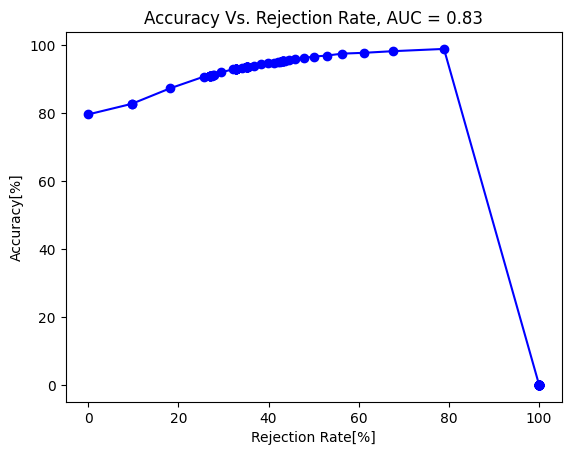

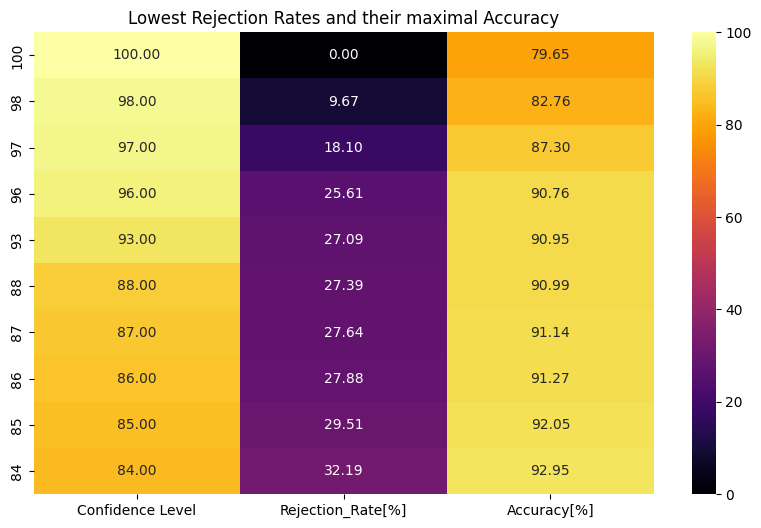

##### **Confusion Matrix**
***

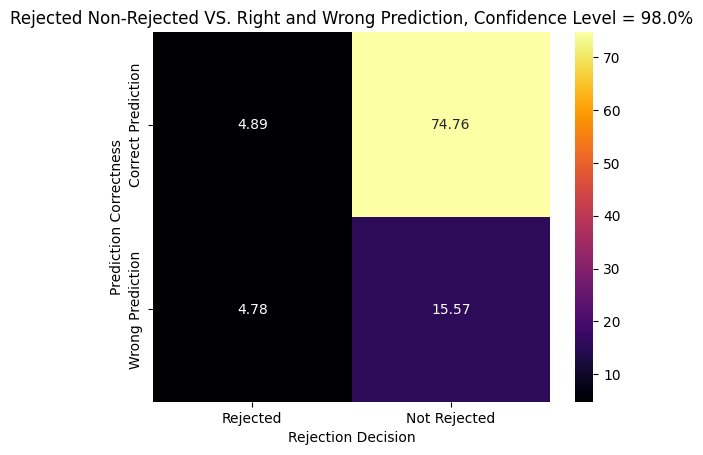

#### **Validation seed: 21**
***

##### **Calculate confidence score**
***

Targets  Predictions  IsCorrect    Probas  Threshold  Baseline  \
0           0         True      False  0.321550    0.29619  0.321550   
1           0        False       True  0.031009    0.29619  0.968991   
2           0        False       True  0.038104    0.29619  0.961896   
3           0        False       True  0.019519    0.29619  0.980481   
4           1         True       True  0.508203    0.29619  0.508203   
...       ...          ...        ...       ...        ...       ...   
5332        0         True      False  0.408512    0.29619  0.408512   
5333        0        False       True  0.065861    0.29619  0.934139   
5334        1         True       True  0.801508    0.29619  0.801508   
5335        1         True       True  0.947120    0.29619  0.947120   
5336        0        False       True  0.012450    0.29619  0.987550   

      doctor_alpha  mcmc_soft_scores  mcmc_predictions  mcmc_probas  ...  \
0         0.225972          0.758355             False     0.241645  ...   
1         0.936062          0.953302             False     0.046698  ...   
2         0.920897          0.943200             False     0.056800  ...   
3         0.960201          0.969269             False     0.030731  ...   
4         0.000538          0.469897              True     0.469897  ...   
...            ...               ...               ...          ...  ...   
5332      0.064791          0.387686              True     0.387686  ...   
5333      0.859690          0.919590             False     0.080410  ...   
5334      0.533324          0.705837              True     0.705837  ...   
5335      0.888683          0.924435              True     0.924435  ...   
5336      0.974791          0.982866             False     0.017134  ...   

      Laplace_score  Laplace_probas  TrustScore  ConfidNet_scores  \
0          0.339911        0.339911    0.924052          0.566204   
1          0.936509        0.063491    1.291472          0.950077   
2          0.932482        0.067518    1.226272          0.935607   
3          0.953912        0.046088    1.156958          0.970550   
4          0.507792        0.507792    0.926226          0.503401   
...             ...             ...         ...               ...   
5332       0.413174        0.413174    0.938454          0.517474   
5333       0.902993        0.097007    1.281148          0.889908   
5334       0.780692        0.780692    0.977375          0.621266   
5335       0.907500        0.907500    1.442724          0.868380   
5336       0.959542        0.040458    1.296394          0.982058   

      SWAG_probas  SWAG_targets  SWAG_predictions  SWAG_threshold  SWAG_score  \
0        0.219659             0             False        0.300369    0.780341   
1        0.046895             0             False        0.300369    0.953105   
2        0.065541             0             False        0.300369    0.934459   
3        0.037009             0             False        0.300369    0.962991   
4        0.389541             1              True        0.300369    0.389541   
...           ...           ...               ...             ...         ...   
5332     0.489346             0              True        0.300369    0.489346   
5333     0.119221             0             False        0.300369    0.880779   
5334     0.734722             1              True        0.300369    0.734722   
5335     0.929076             1              True        0.300369    0.929076   
5336     0.024704             0             False        0.300369    0.975296   

      Confidence_score  
0             2.815378  
1            58.128573  
2            57.490149  
3            59.022351  
4             0.000000  
...                ...  
5332          0.177840  
5333         55.324147  
5334          3.872480  
5335         56.266102  
5336         59.634329  

[5337 rows x 24 columns]

##### **Rejection**
***

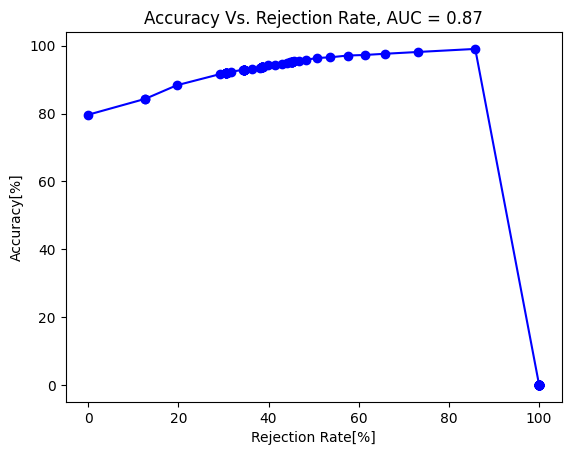

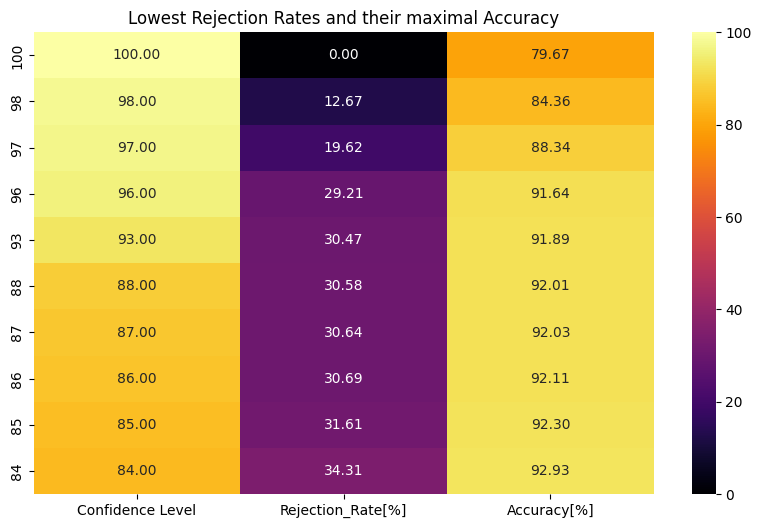

##### **Confusion Matrix**
***

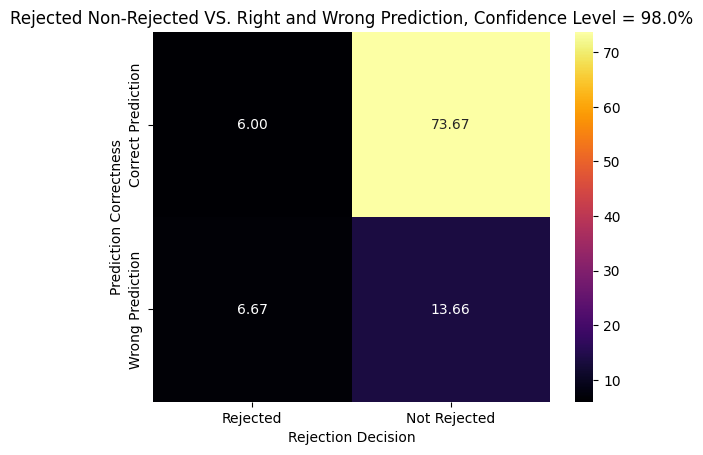

#### **Validation seed: 42**
***

##### **Calculate confidence score**
***

Targets  Predictions  IsCorrect    Probas  Threshold  Baseline  \
0           0        False       True  0.133607   0.299127  0.866393   
1           0        False       True  0.051193   0.299127  0.948806   
2           0        False       True  0.234509   0.299127  0.765491   
3           0        False       True  0.021759   0.299127  0.978241   
4           1         True       True  0.467279   0.299127  0.467279   
...       ...          ...        ...       ...        ...       ...   
5332        0        False       True  0.270805   0.299127  0.729195   
5333        0        False       True  0.064705   0.299127  0.935295   
5334        1         True       True  0.718077   0.299127  0.718077   
5335        1         True       True  0.906884   0.299127  0.906884   
5336        0        False       True  0.005742   0.299127  0.994258   

      doctor_alpha  mcmc_soft_scores  mcmc_predictions  mcmc_probas  ...  \
0         0.698742          0.859273             False     0.140727  ...   
1         0.892402          0.959722             False     0.040278  ...   
2         0.439866          0.842793             False     0.157207  ...   
3         0.955535          0.975401             False     0.024599  ...   
4         0.008528          0.437282              True     0.437282  ...   
...            ...               ...               ...          ...  ...   
5332      0.347272          0.291648              True     0.291648  ...   
5333      0.862296          0.938056             False     0.061944  ...   
5334      0.319654          0.686622              True     0.686622  ...   
5335      0.796788          0.862960              True     0.862960  ...   
5336      0.988449          0.995013             False     0.004987  ...   

      Laplace_score  Laplace_probas  TrustScore  ConfidNet_scores  \
0          0.853492        0.146508    1.008468          0.788767   
1          0.923794        0.076207    1.098191          0.908427   
2          0.751112        0.248888    1.247477          0.644048   
3          0.957669        0.042331    1.444366          0.963062   
4          0.468266        0.468266    1.074364          0.506450   
...             ...             ...         ...               ...   
5332       0.723807        0.276193    1.094813          0.632205   
5333       0.909725        0.090275    1.422165          0.893443   
5334       0.709768        0.709768    1.061580          0.591341   
5335       0.882833        0.882833    1.251781          0.819405   
5336       0.973608        0.026392    1.672861          0.991033   

      SWAG_probas  SWAG_targets  SWAG_predictions  SWAG_threshold  SWAG_score  \
0        0.139830             0             False        0.266712    0.860170   
1        0.036591             0             False        0.266712    0.963409   
2        0.024665             0             False        0.266712    0.975335   
3        0.036590             0             False        0.266712    0.963410   
4        0.427699             1              True        0.266712    0.427699   
...           ...           ...               ...             ...         ...   
5332     0.387565             0              True        0.266712    0.387565   
5333     0.057003             0             False        0.266712    0.942997   
5334     0.767467             1              True        0.266712    0.767467   
5335     0.991727             1              True        0.266712    0.991727   
5336     0.009560             0             False        0.266712    0.990440   

      Confidence_score  
0            51.783038  
1            57.632444  
2            28.611050  
3            59.094192  
4             0.000000  
...                ...  
5332          3.404207  
5333         56.541319  
5334          3.169971  
5335         54.913735  
5336         60.361285  

[5337 rows x 24 columns]

##### **Rejection**
***

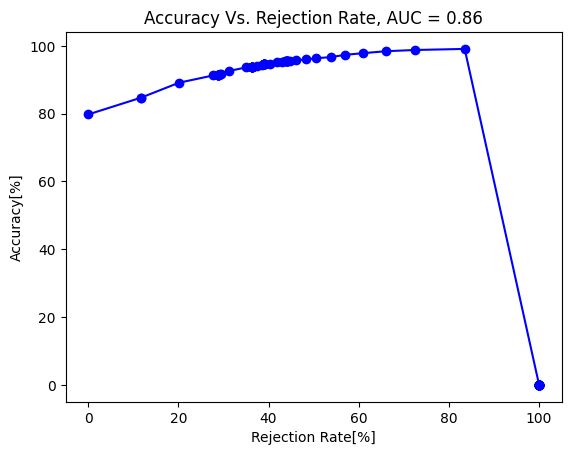

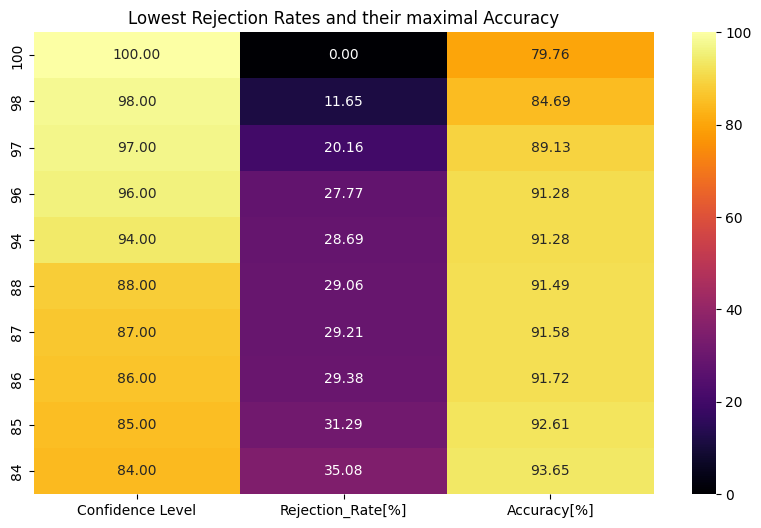

##### **Confusion Matrix**
***

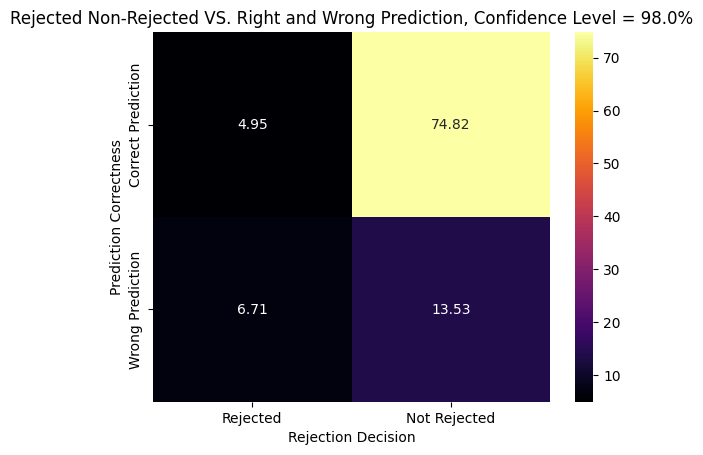

#### **Validation seed: 55**
***

##### **Calculate confidence score**
***

Targets  Predictions  IsCorrect    Probas  Threshold  Baseline  \
0           0        False       True  0.069185   0.256104  0.930815   
1           0        False       True  0.042340   0.256104  0.957660   
2           0        False       True  0.119516   0.256104  0.880484   
3           0        False       True  0.020617   0.256104  0.979383   
4           1         True       True  0.501353   0.256104  0.501353   
...       ...          ...        ...       ...        ...       ...   
5332        0         True      False  0.299088   0.256104  0.299088   
5333        0        False       True  0.041803   0.256104  0.958197   
5334        1         True       True  0.592492   0.256104  0.592492   
5335        1         True       True  0.824778   0.256104  0.824778   
5336        0        False       True  0.008859   0.256104  0.991141   

      doctor_alpha  mcmc_soft_scores  mcmc_predictions  mcmc_probas  ...  \
0         0.852162          0.910226             False     0.089774  ...   
1         0.911750          0.966602             False     0.033398  ...   
2         0.733433          0.880902             False     0.119098  ...   
3         0.957917          0.975860             False     0.024140  ...   
4         0.000015          0.450166              True     0.450166  ...   
...            ...               ...               ...          ...  ...   
5332      0.278032          0.276369              True     0.276369  ...   
5333      0.912912          0.940770             False     0.059231  ...   
5334      0.066174          0.523718              True     0.523718  ...   
5335      0.593453          0.742194              True     0.742194  ...   
5336      0.982126          0.992120             False     0.007880  ...   

      Laplace_score  Laplace_probas  TrustScore  ConfidNet_scores  \
0          0.910820        0.089180    1.170258          0.883999   
1          0.931371        0.068629    1.159251          0.929127   
2          0.855339        0.144661    1.575550          0.786745   
3          0.956010        0.043990    1.306924          0.963050   
4          0.501297        0.501297    1.012178          0.499037   
...             ...             ...         ...               ...   
5332       0.305883        0.305883    0.947422          0.584395   
5333       0.929239        0.070761    1.334533          0.920293   
5334       0.587575        0.587575    0.886118          0.518437   
5335       0.800733        0.800733    1.214010          0.709114   
5336       0.967610        0.032390    1.476120          0.983707   

      SWAG_probas  SWAG_targets  SWAG_predictions  SWAG_threshold  SWAG_score  \
0        0.202565             0             False        0.365878    0.797435   
1        0.047159             0             False        0.365878    0.952841   
2        0.091072             0             False        0.365878    0.908928   
3        0.058561             0             False        0.365878    0.941439   
4        0.400292             1              True        0.365878    0.400292   
...           ...           ...               ...             ...         ...   
5332     0.438121             0              True        0.365878    0.438121   
5333     0.099077             0             False        0.365878    0.900923   
5334     0.844504             1              True        0.365878    0.844504   
5335     0.990643             1              True        0.365878    0.990643   
5336     0.027085             0             False        0.365878    0.972915   

      Confidence_score  
0            43.493244  
1            57.944109  
2            53.038572  
3            58.807532  
4             0.000000  
...                ...  
5332          3.028798  
5333         56.834763  
5334         11.416116  
5335         28.568527  
5336         59.918076  

[5337 rows x 24 columns]

##### **Rejection**
***

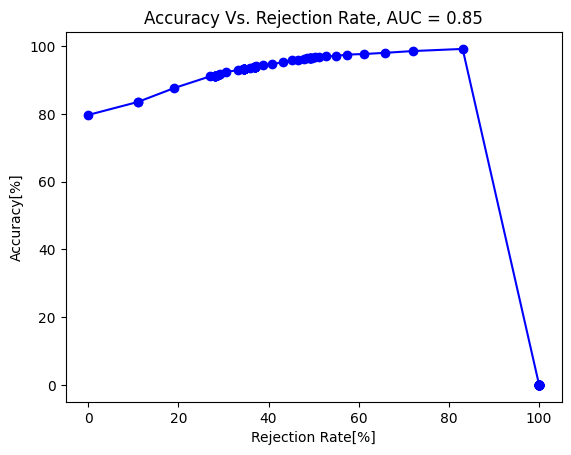

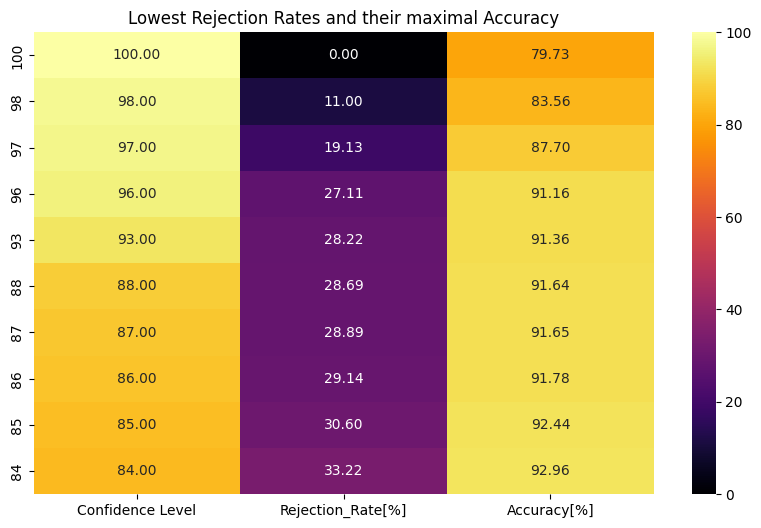

##### **Confusion Matrix**
***

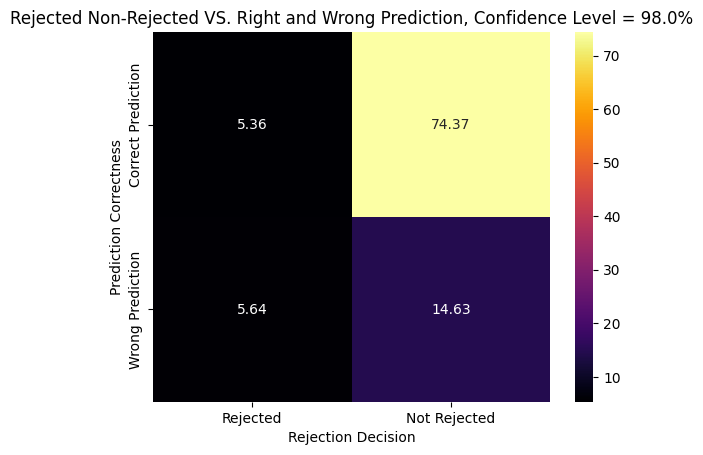

#### **Validation seed: 84**
***

##### **Calculate confidence score**
***

Targets  Predictions  IsCorrect    Probas  Threshold  Baseline  \
0           0        False       True  0.111794   0.276579  0.888206   
1           0        False       True  0.042738   0.276579  0.957262   
2           0        False       True  0.103509   0.276579  0.896491   
3           0        False       True  0.013938   0.276579  0.986062   
4           1         True       True  0.505930   0.276579  0.505930   
...       ...          ...        ...       ...        ...       ...   
5332        0         True      False  0.424185   0.276579  0.424185   
5333        0        False       True  0.028907   0.276579  0.971093   
5334        1         True       True  0.672492   0.276579  0.672492   
5335        1         True       True  0.943981   0.276579  0.943981   
5336        0        False       True  0.004062   0.276579  0.995938   

      doctor_alpha  mcmc_soft_scores  mcmc_predictions  mcmc_probas  ...  \
0         0.752196          0.878455             False     0.121545  ...   
1         0.910886          0.962467             False     0.037533  ...   
2         0.772119          0.922193             False     0.077807  ...   
3         0.971736          0.981936             False     0.018064  ...   
4         0.000281          0.454494              True     0.454494  ...   
...            ...               ...               ...          ...  ...   
5332      0.044949          0.396572              True     0.396572  ...   
5333      0.940518          0.967490             False     0.032510  ...   
5334      0.212712          0.588014              True     0.588014  ...   
5335      0.881729          0.878429              True     0.878429  ...   
5336      0.991843          0.996565             False     0.003435  ...   

      Laplace_score  Laplace_probas  TrustScore  ConfidNet_scores  \
0          0.867362        0.132638    1.173740          0.808673   
1          0.927564        0.072436    1.403481          0.930165   
2          0.862245        0.137755    1.234549          0.807743   
3          0.960933        0.039067    1.280152          0.977662   
4          0.505474        0.505474    1.152270          0.502244   
...             ...             ...         ...               ...   
5332       0.427478        0.427478    1.036702          0.508862   
5333       0.941480        0.058520    1.446135          0.957650   
5334       0.661861        0.661861    1.051672          0.554597   
5335       0.905961        0.905961    1.327819          0.838565   
5336       0.973583        0.026417    2.157376          0.994981   

      SWAG_probas  SWAG_targets  SWAG_predictions  SWAG_threshold  SWAG_score  \
0        0.133959             0             False        0.359267    0.866041   
1        0.039606             0             False        0.359267    0.960394   
2        0.037233             0             False        0.359267    0.962766   
3        0.030653             0             False        0.359267    0.969348   
4        0.429829             1              True        0.359267    0.429829   
...           ...           ...               ...             ...         ...   
5332     0.505787             0              True        0.359267    0.505787   
5333     0.056578             0             False        0.359267    0.943422   
5334     0.856770             1              True        0.359267    0.856770   
5335     0.969893             1              True        0.359267    0.969893   
5336     0.023079             0             False        0.359267    0.976921   

      Confidence_score  
0            52.836869  
1            57.930487  
2            54.834796  
3            59.515668  
4             0.000000  
...                ...  
5332          0.123379  
5333         58.338014  
5334         14.131629  
5335         55.960185  
5336         60.250109  

[5337 rows x 24 columns]

##### **Rejection**
***

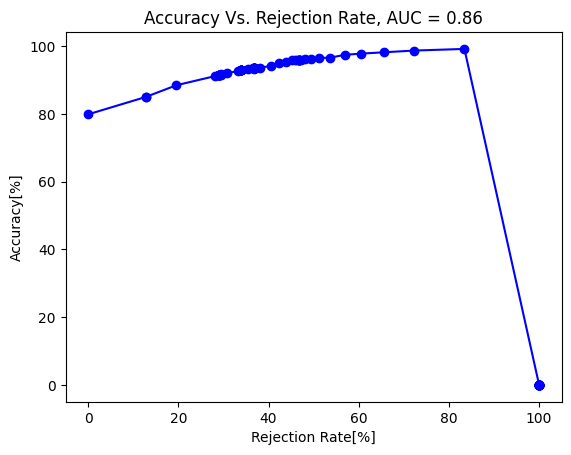

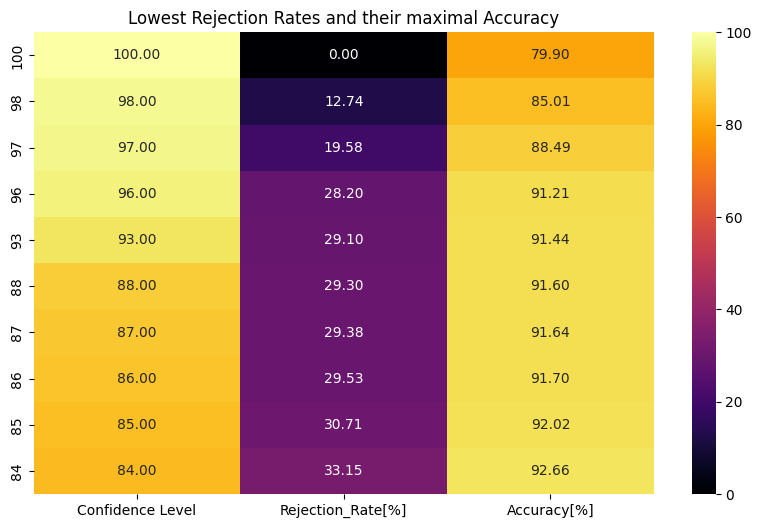

##### **Confusion Matrix**
***

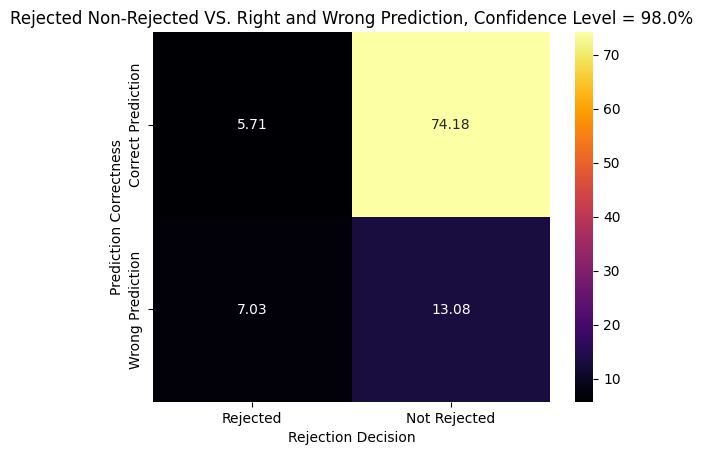

## **Train seed: 21**
***

### **Thresholding**
***

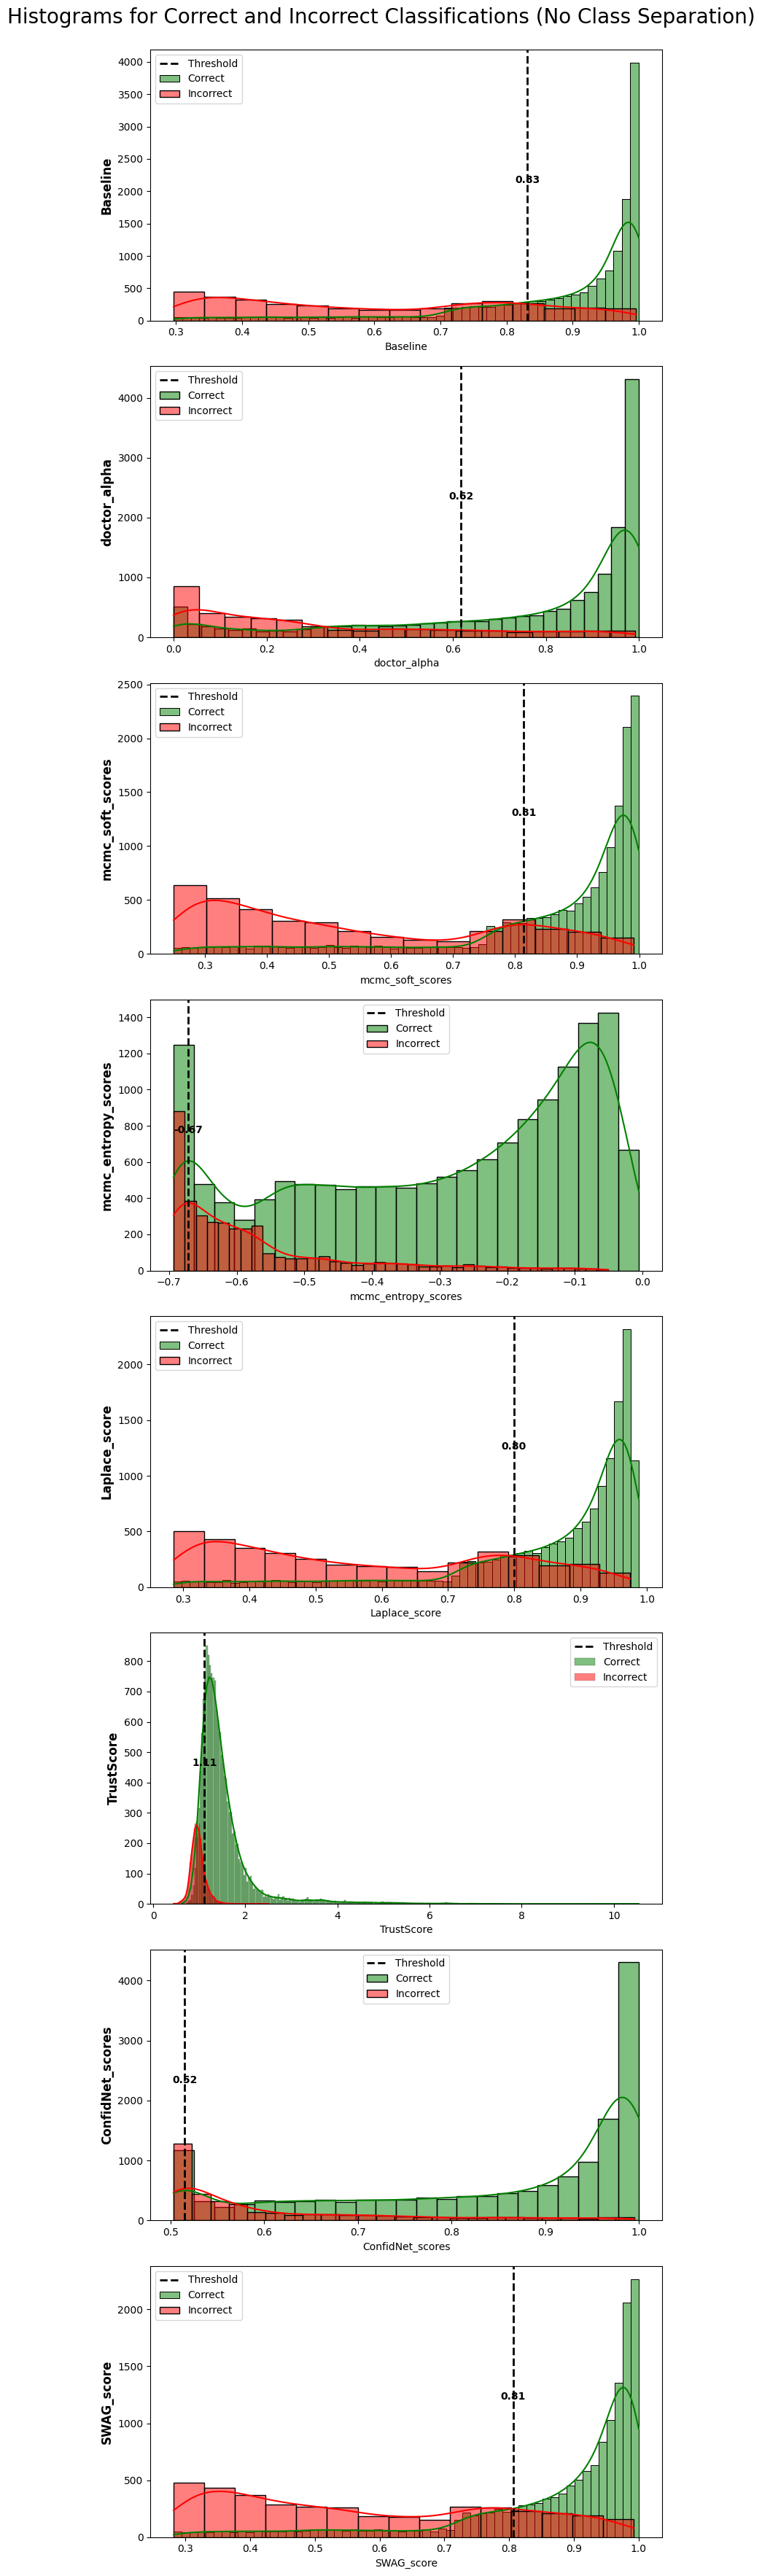

Seed    Scoring_Method  Threshold
0    21          Baseline   0.831508
1    21      doctor_alpha   0.617403
2    21  mcmc_soft_scores   0.813812
3    21     Laplace_score   0.799489
4    21  ConfidNet_scores   0.515216
5    21        SWAG_score   0.805966

### **Finding Optimal weights**
***

Scoring_Method  Threshold Rejection_Direction    Weight
0          Baseline   0.831508                   <  0.809284
1      doctor_alpha   0.617403                   <  0.814058
2  mcmc_soft_scores   0.813812                   <  0.817786
3     Laplace_score   0.799489                   <  0.803966
4  ConfidNet_scores   0.515216                   <  0.267905
5        SWAG_score   0.805966                   <  0.803354

### **Validation process**
***

#### **Validation seed: 10**
***

##### **Calculate confidence score**
***

Targets  Predictions  IsCorrect    Probas  Threshold  Baseline  \
0           0        False       True  0.120629     0.2514  0.879371   
1           0        False       True  0.015437     0.2514  0.984563   
2           0        False       True  0.204569     0.2514  0.795431   
3           0        False       True  0.020883     0.2514  0.979117   
4           1         True       True  0.404807     0.2514  0.404807   
...       ...          ...        ...       ...        ...       ...   
5332        0         True      False  0.414607     0.2514  0.414607   
5333        0        False       True  0.016182     0.2514  0.983818   
5334        1         True       True  0.716283     0.2514  0.716283   
5335        1         True       True  0.897099     0.2514  0.897099   
5336        0        False       True  0.006760     0.2514  0.993240   

      doctor_alpha  mcmc_soft_scores  mcmc_predictions  mcmc_probas  ...  \
0         0.730714          0.872454             False     0.127546  ...   
1         0.968650          0.980743             False     0.019257  ...   
2         0.517550          0.798938             False     0.201062  ...   
3         0.957362          0.973877             False     0.026123  ...   
4         0.069957          0.399427              True     0.399427  ...   
...            ...               ...               ...          ...  ...   
5332      0.056682          0.384239              True     0.384239  ...   
5333      0.967113          0.972169             False     0.027831  ...   
5334      0.315242          0.692529              True     0.692529  ...   
5335      0.773571          0.857830              True     0.857830  ...   
5336      0.986390          0.991054             False     0.008946  ...   

      Laplace_score  Laplace_probas  TrustScore  ConfidNet_scores  \
0          0.861275        0.138725    1.021478          0.832027   
1          0.965907        0.034093    1.366800          0.982724   
2          0.780711        0.219289    1.150789          0.706421   
3          0.961532        0.038468    1.470300          0.972814   
4          0.408548        0.408548    1.026057          0.538007   
...             ...             ...         ...               ...   
5332       0.416400        0.416400    1.085031          0.528210   
5333       0.966852        0.033148    1.277399          0.981498   
5334       0.708652        0.708652    0.946856          0.548512   
5335       0.874433        0.874433    1.191389          0.764287   
5336       0.977124        0.022876    1.577930          0.993575   

      SWAG_probas  SWAG_targets  SWAG_predictions  SWAG_threshold  SWAG_score  \
0        0.077146             0             False        0.322991    0.922854   
1        0.051407             0             False        0.322991    0.948593   
2        0.044643             0             False        0.322991    0.955357   
3        0.027361             0             False        0.322991    0.972639   
4        0.373209             1              True        0.322991    0.373209   
...           ...           ...               ...             ...         ...   
5332     0.389461             0              True        0.322991    0.389461   
5333     0.055352             0             False        0.322991    0.944648   
5334     0.868984             1              True        0.322991    0.868984   
5335     0.967013             1              True        0.322991    0.967013   
5336     0.020007             0             False        0.322991    0.979993   

      Confidence_score  
0            61.278375  
1            69.820897  
2            15.945712  
3            69.719813  
4             2.402243  
...                ...  
5332          2.358495  
5333         69.627511  
5334         14.084169  
5335         62.364760  
5336         70.938351  

[5337 rows x 24 columns]

##### **Rejection**
***

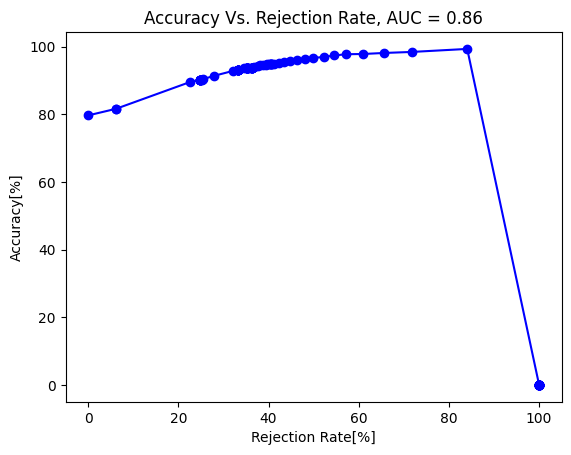

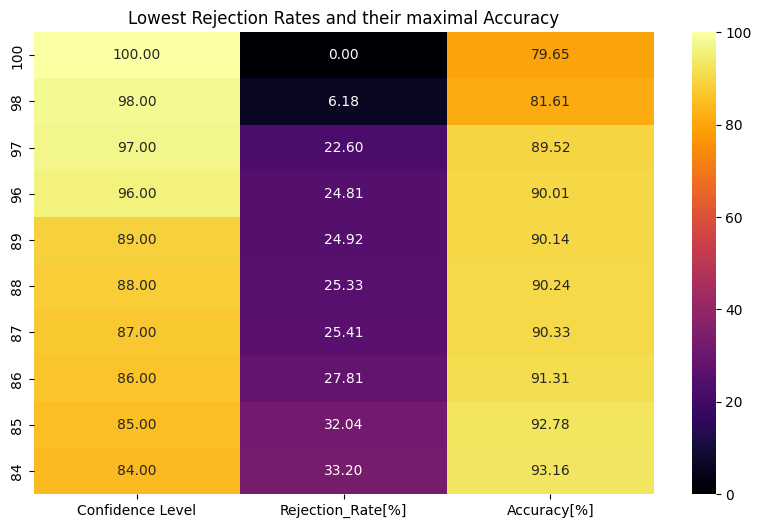

##### **Confusion Matrix**
***

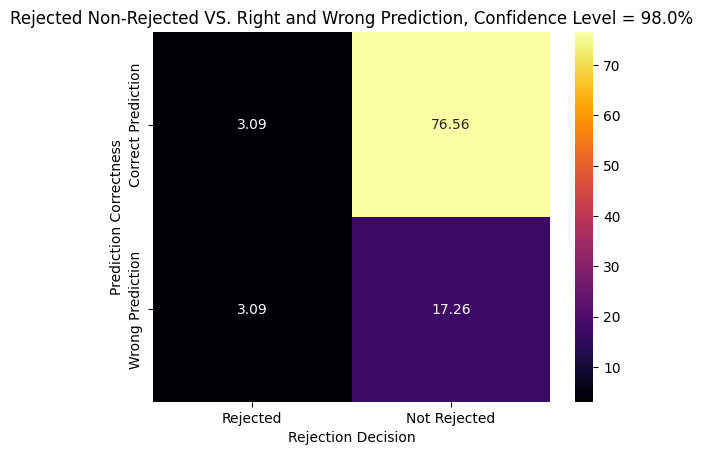

#### **Validation seed: 21**
***

##### **Calculate confidence score**
***

Targets  Predictions  IsCorrect    Probas  Threshold  Baseline  \
0           0         True      False  0.321550    0.29619  0.321550   
1           0        False       True  0.031009    0.29619  0.968991   
2           0        False       True  0.038104    0.29619  0.961896   
3           0        False       True  0.019519    0.29619  0.980481   
4           1         True       True  0.508203    0.29619  0.508203   
...       ...          ...        ...       ...        ...       ...   
5332        0         True      False  0.408512    0.29619  0.408512   
5333        0        False       True  0.065861    0.29619  0.934139   
5334        1         True       True  0.801508    0.29619  0.801508   
5335        1         True       True  0.947120    0.29619  0.947120   
5336        0        False       True  0.012450    0.29619  0.987550   

      doctor_alpha  mcmc_soft_scores  mcmc_predictions  mcmc_probas  ...  \
0         0.225972          0.758355             False     0.241645  ...   
1         0.936062          0.953302             False     0.046698  ...   
2         0.920897          0.943200             False     0.056800  ...   
3         0.960201          0.969269             False     0.030731  ...   
4         0.000538          0.469897              True     0.469897  ...   
...            ...               ...               ...          ...  ...   
5332      0.064791          0.387686              True     0.387686  ...   
5333      0.859690          0.919590             False     0.080410  ...   
5334      0.533324          0.705837              True     0.705837  ...   
5335      0.888683          0.924435              True     0.924435  ...   
5336      0.974791          0.982866             False     0.017134  ...   

      Laplace_score  Laplace_probas  TrustScore  ConfidNet_scores  \
0          0.339911        0.339911    0.924052          0.566204   
1          0.936509        0.063491    1.291472          0.950077   
2          0.932482        0.067518    1.226272          0.935607   
3          0.953912        0.046088    1.156958          0.970550   
4          0.507792        0.507792    0.926226          0.503401   
...             ...             ...         ...               ...   
5332       0.413174        0.413174    0.938454          0.517474   
5333       0.902993        0.097007    1.281148          0.889908   
5334       0.780692        0.780692    0.977375          0.621266   
5335       0.907500        0.907500    1.442724          0.868380   
5336       0.959542        0.040458    1.296394          0.982058   

      SWAG_probas  SWAG_targets  SWAG_predictions  SWAG_threshold  SWAG_score  \
0        0.219659             0             False        0.300369    0.780341   
1        0.046895             0             False        0.300369    0.953105   
2        0.065541             0             False        0.300369    0.934459   
3        0.037009             0             False        0.300369    0.962991   
4        0.389541             1              True        0.300369    0.389541   
...           ...           ...               ...             ...         ...   
5332     0.489346             0              True        0.300369    0.489346   
5333     0.119221             0             False        0.300369    0.880779   
5334     0.734722             1              True        0.300369    0.734722   
5335     0.929076             1              True        0.300369    0.929076   
5336     0.024704             0             False        0.300369    0.975296   

      Confidence_score  
0             2.528145  
1            68.315455  
2            67.508059  
3            69.472540  
4             0.000000  
...                ...  
5332          2.310562  
5333         64.663533  
5334          2.774001  
5335         65.908962  
5336         70.242750  

[5337 rows x 24 columns]

##### **Rejection**
***

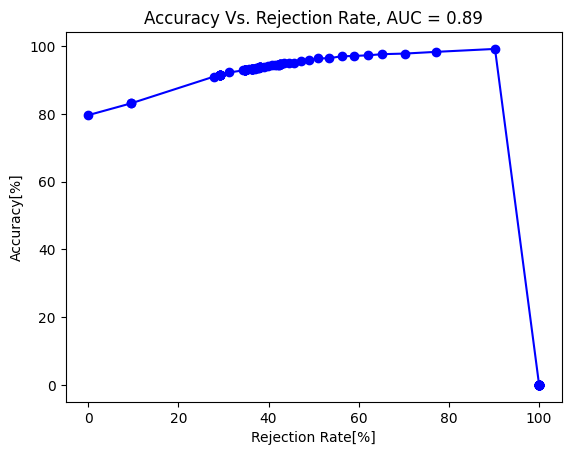

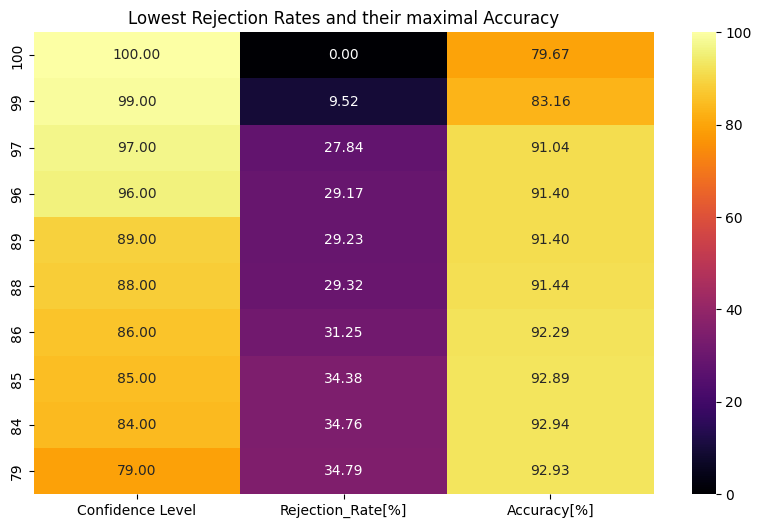

##### **Confusion Matrix**
***

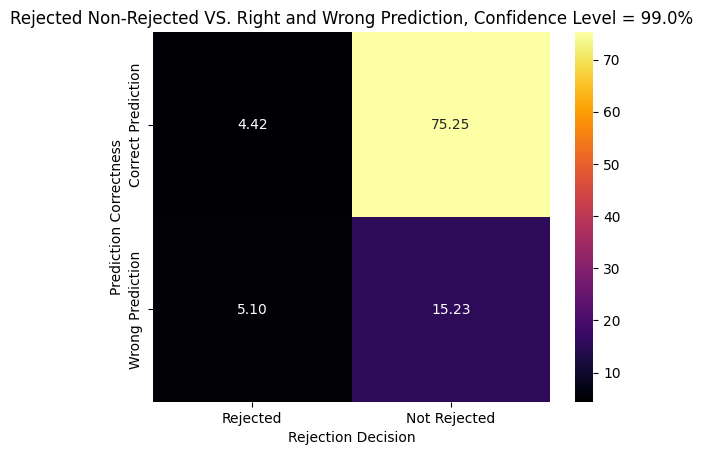

#### **Validation seed: 42**
***

##### **Calculate confidence score**
***

Targets  Predictions  IsCorrect    Probas  Threshold  Baseline  \
0           0        False       True  0.133607   0.299127  0.866393   
1           0        False       True  0.051193   0.299127  0.948806   
2           0        False       True  0.234509   0.299127  0.765491   
3           0        False       True  0.021759   0.299127  0.978241   
4           1         True       True  0.467279   0.299127  0.467279   
...       ...          ...        ...       ...        ...       ...   
5332        0        False       True  0.270805   0.299127  0.729195   
5333        0        False       True  0.064705   0.299127  0.935295   
5334        1         True       True  0.718077   0.299127  0.718077   
5335        1         True       True  0.906884   0.299127  0.906884   
5336        0        False       True  0.005742   0.299127  0.994258   

      doctor_alpha  mcmc_soft_scores  mcmc_predictions  mcmc_probas  ...  \
0         0.698742          0.859273             False     0.140727  ...   
1         0.892402          0.959722             False     0.040278  ...   
2         0.439866          0.842793             False     0.157207  ...   
3         0.955535          0.975401             False     0.024599  ...   
4         0.008528          0.437282              True     0.437282  ...   
...            ...               ...               ...          ...  ...   
5332      0.347272          0.291648              True     0.291648  ...   
5333      0.862296          0.938056             False     0.061944  ...   
5334      0.319654          0.686622              True     0.686622  ...   
5335      0.796788          0.862960              True     0.862960  ...   
5336      0.988449          0.995013             False     0.004987  ...   

      Laplace_score  Laplace_probas  TrustScore  ConfidNet_scores  \
0          0.853492        0.146508    1.008468          0.788767   
1          0.923794        0.076207    1.098191          0.908427   
2          0.751112        0.248888    1.247477          0.644048   
3          0.957669        0.042331    1.444366          0.963062   
4          0.468266        0.468266    1.074364          0.506450   
...             ...             ...         ...               ...   
5332       0.723807        0.276193    1.094813          0.632205   
5333       0.909725        0.090275    1.422165          0.893443   
5334       0.709768        0.709768    1.061580          0.591341   
5335       0.882833        0.882833    1.251781          0.819405   
5336       0.973608        0.026392    1.672861          0.991033   

      SWAG_probas  SWAG_targets  SWAG_predictions  SWAG_threshold  SWAG_score  \
0        0.139830             0             False        0.266712    0.860170   
1        0.036591             0             False        0.266712    0.963409   
2        0.024665             0             False        0.266712    0.975335   
3        0.036590             0             False        0.266712    0.963410   
4        0.427699             1              True        0.266712    0.427699   
...           ...           ...               ...             ...         ...   
5332     0.387565             0              True        0.266712    0.387565   
5333     0.057003             0             False        0.266712    0.942997   
5334     0.767467             1              True        0.266712    0.767467   
5335     0.991727             1              True        0.266712    0.991727   
5336     0.009560             0             False        0.266712    0.990440   

      Confidence_score  
0            59.353152  
1            67.319949  
2            27.421769  
3            69.485110  
4             0.000000  
...                ...  
5332          2.822844  
5333         65.905227  
5334          2.640380  
5335         63.571220  
5336         71.115402  

[5337 rows x 24 columns]

##### **Rejection**
***

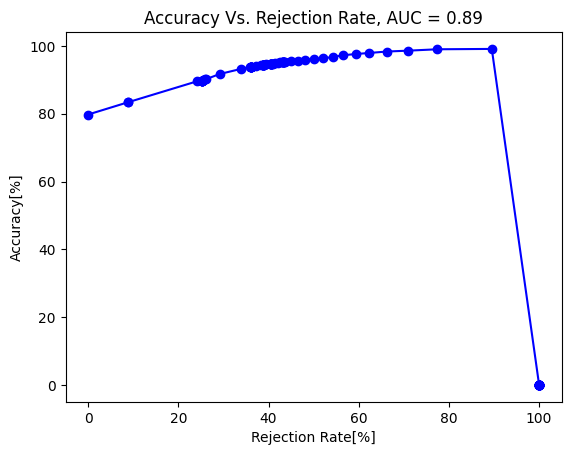

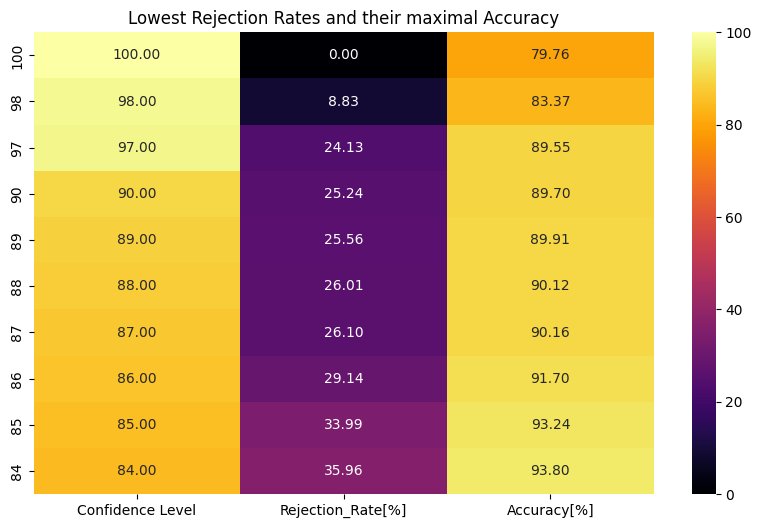

##### **Confusion Matrix**
***

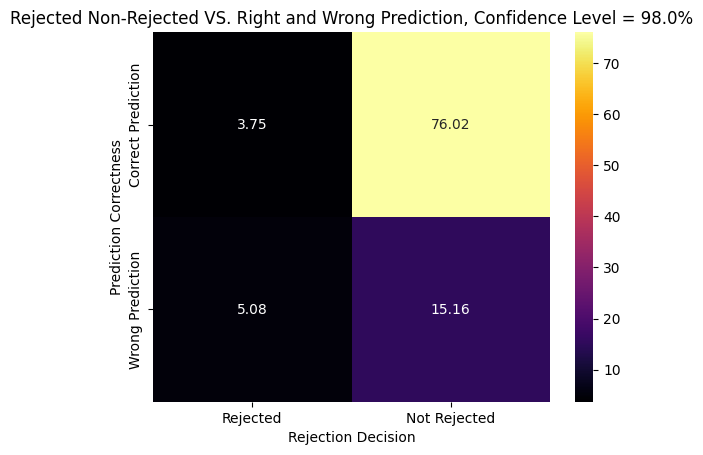

#### **Validation seed: 55**
***

##### **Calculate confidence score**
***

Targets  Predictions  IsCorrect    Probas  Threshold  Baseline  \
0           0        False       True  0.069185   0.256104  0.930815   
1           0        False       True  0.042340   0.256104  0.957660   
2           0        False       True  0.119516   0.256104  0.880484   
3           0        False       True  0.020617   0.256104  0.979383   
4           1         True       True  0.501353   0.256104  0.501353   
...       ...          ...        ...       ...        ...       ...   
5332        0         True      False  0.299088   0.256104  0.299088   
5333        0        False       True  0.041803   0.256104  0.958197   
5334        1         True       True  0.592492   0.256104  0.592492   
5335        1         True       True  0.824778   0.256104  0.824778   
5336        0        False       True  0.008859   0.256104  0.991141   

      doctor_alpha  mcmc_soft_scores  mcmc_predictions  mcmc_probas  ...  \
0         0.852162          0.910226             False     0.089774  ...   
1         0.911750          0.966602             False     0.033398  ...   
2         0.733433          0.880902             False     0.119098  ...   
3         0.957917          0.975860             False     0.024140  ...   
4         0.000015          0.450166              True     0.450166  ...   
...            ...               ...               ...          ...  ...   
5332      0.278032          0.276369              True     0.276369  ...   
5333      0.912912          0.940770             False     0.059231  ...   
5334      0.066174          0.523718              True     0.523718  ...   
5335      0.593453          0.742194              True     0.742194  ...   
5336      0.982126          0.992120             False     0.007880  ...   

      Laplace_score  Laplace_probas  TrustScore  ConfidNet_scores  \
0          0.910820        0.089180    1.170258          0.883999   
1          0.931371        0.068629    1.159251          0.929127   
2          0.855339        0.144661    1.575550          0.786745   
3          0.956010        0.043990    1.306924          0.963050   
4          0.501297        0.501297    1.012178          0.499037   
...             ...             ...         ...               ...   
5332       0.305883        0.305883    0.947422          0.584395   
5333       0.929239        0.070761    1.334533          0.920293   
5334       0.587575        0.587575    0.886118          0.518437   
5335       0.800733        0.800733    1.214010          0.709114   
5336       0.967610        0.032390    1.476120          0.983707   

      SWAG_probas  SWAG_targets  SWAG_predictions  SWAG_threshold  SWAG_score  \
0        0.202565             0             False        0.365878    0.797435   
1        0.047159             0             False        0.365878    0.952841   
2        0.091072             0             False        0.365878    0.908928   
3        0.058561             0             False        0.365878    0.941439   
4        0.400292             1              True        0.365878    0.400292   
...           ...           ...               ...             ...         ...   
5332     0.438121             0              True        0.365878    0.438121   
5333     0.099077             0             False        0.365878    0.900923   
5334     0.844504             1              True        0.365878    0.844504   
5335     0.990643             1              True        0.365878    0.990643   
5336     0.027085             0             False        0.365878    0.972915   

      Confidence_score  
0            52.674473  
1            67.848119  
2            60.977244  
3            69.222620  
4             0.000000  
...                ...  
5332          2.609368  
5333         66.755875  
5334         13.622118  
5335         27.159574  
5336         70.600407  

[5337 rows x 24 columns]

##### **Rejection**
***

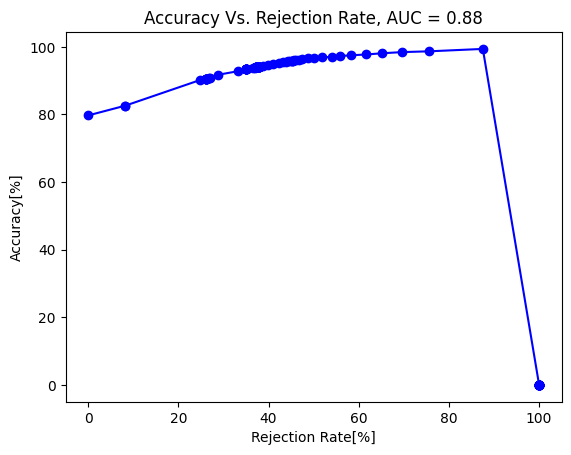

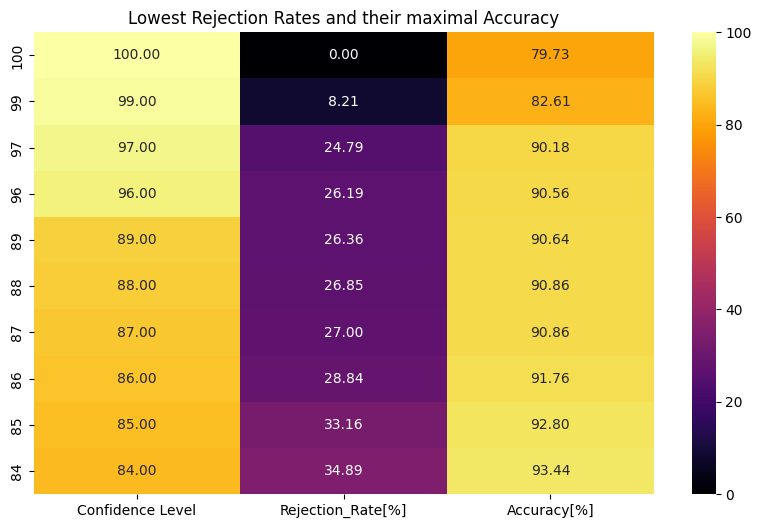

##### **Confusion Matrix**
***

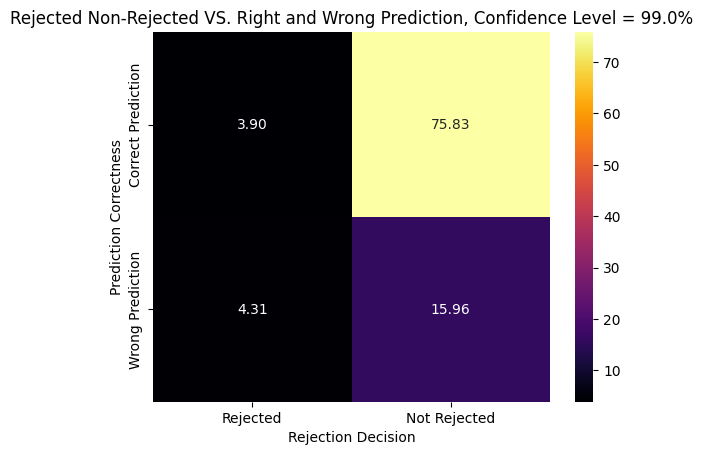

#### **Validation seed: 84**
***

##### **Calculate confidence score**
***

Targets  Predictions  IsCorrect    Probas  Threshold  Baseline  \
0           0        False       True  0.111794   0.276579  0.888206   
1           0        False       True  0.042738   0.276579  0.957262   
2           0        False       True  0.103509   0.276579  0.896491   
3           0        False       True  0.013938   0.276579  0.986062   
4           1         True       True  0.505930   0.276579  0.505930   
...       ...          ...        ...       ...        ...       ...   
5332        0         True      False  0.424185   0.276579  0.424185   
5333        0        False       True  0.028907   0.276579  0.971093   
5334        1         True       True  0.672492   0.276579  0.672492   
5335        1         True       True  0.943981   0.276579  0.943981   
5336        0        False       True  0.004062   0.276579  0.995938   

      doctor_alpha  mcmc_soft_scores  mcmc_predictions  mcmc_probas  ...  \
0         0.752196          0.878455             False     0.121545  ...   
1         0.910886          0.962467             False     0.037533  ...   
2         0.772119          0.922193             False     0.077807  ...   
3         0.971736          0.981936             False     0.018064  ...   
4         0.000281          0.454494              True     0.454494  ...   
...            ...               ...               ...          ...  ...   
5332      0.044949          0.396572              True     0.396572  ...   
5333      0.940518          0.967490             False     0.032510  ...   
5334      0.212712          0.588014              True     0.588014  ...   
5335      0.881729          0.878429              True     0.878429  ...   
5336      0.991843          0.996565             False     0.003435  ...   

      Laplace_score  Laplace_probas  TrustScore  ConfidNet_scores  \
0          0.867362        0.132638    1.173740          0.808673   
1          0.927564        0.072436    1.403481          0.930165   
2          0.862245        0.137755    1.234549          0.807743   
3          0.960933        0.039067    1.280152          0.977662   
4          0.505474        0.505474    1.152270          0.502244   
...             ...             ...         ...               ...   
5332       0.427478        0.427478    1.036702          0.508862   
5333       0.941480        0.058520    1.446135          0.957650   
5334       0.661861        0.661861    1.051672          0.554597   
5335       0.905961        0.905961    1.327819          0.838565   
5336       0.973583        0.026417    2.157376          0.994981   

      SWAG_probas  SWAG_targets  SWAG_predictions  SWAG_threshold  SWAG_score  \
0        0.133959             0             False        0.359267    0.866041   
1        0.039606             0             False        0.359267    0.960394   
2        0.037233             0             False        0.359267    0.962766   
3        0.030653             0             False        0.359267    0.969348   
4        0.429829             1              True        0.359267    0.429829   
...           ...           ...               ...             ...         ...   
5332     0.505787             0              True        0.359267    0.505787   
5333     0.056578             0             False        0.359267    0.943422   
5334     0.856770             1              True        0.359267    0.856770   
5335     0.969893             1              True        0.359267    0.969893   
5336     0.023079             0             False        0.359267    0.976921   

      Confidence_score  
0            60.987401  
1            67.829416  
2            63.187960  
3            70.087893  
4             0.000000  
...                ...  
5332          0.000000  
5333         68.568396  
5334         13.947803  
5335         65.537975  
5336         71.041523  

[5337 rows x 24 columns]

##### **Rejection**
***

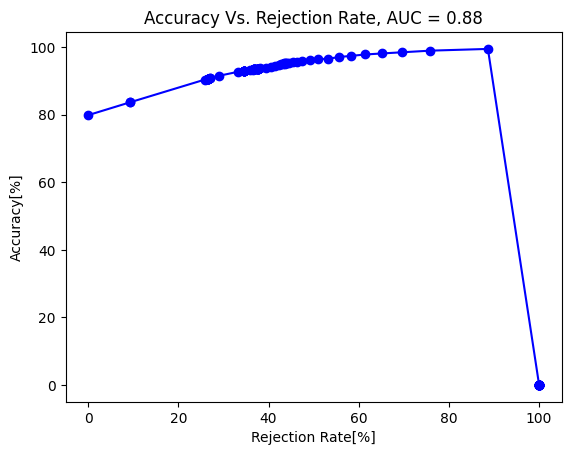

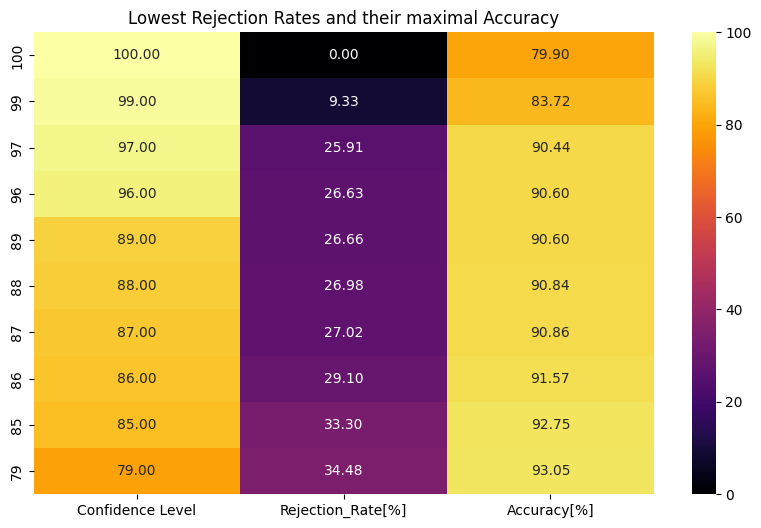

##### **Confusion Matrix**
***

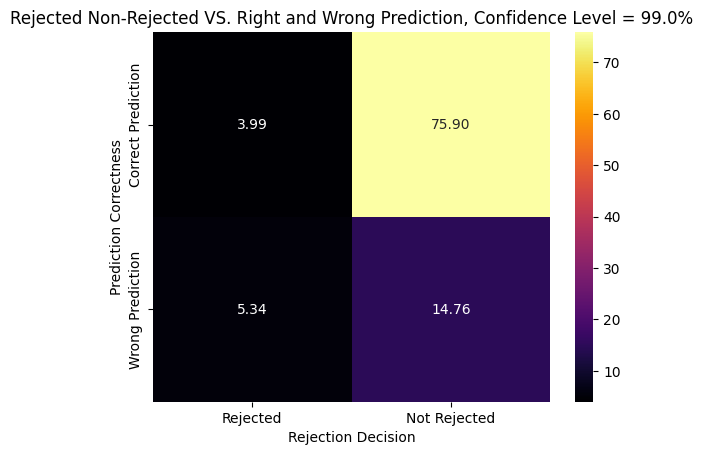

## **Train seed: 42**
***

### **Thresholding**
***

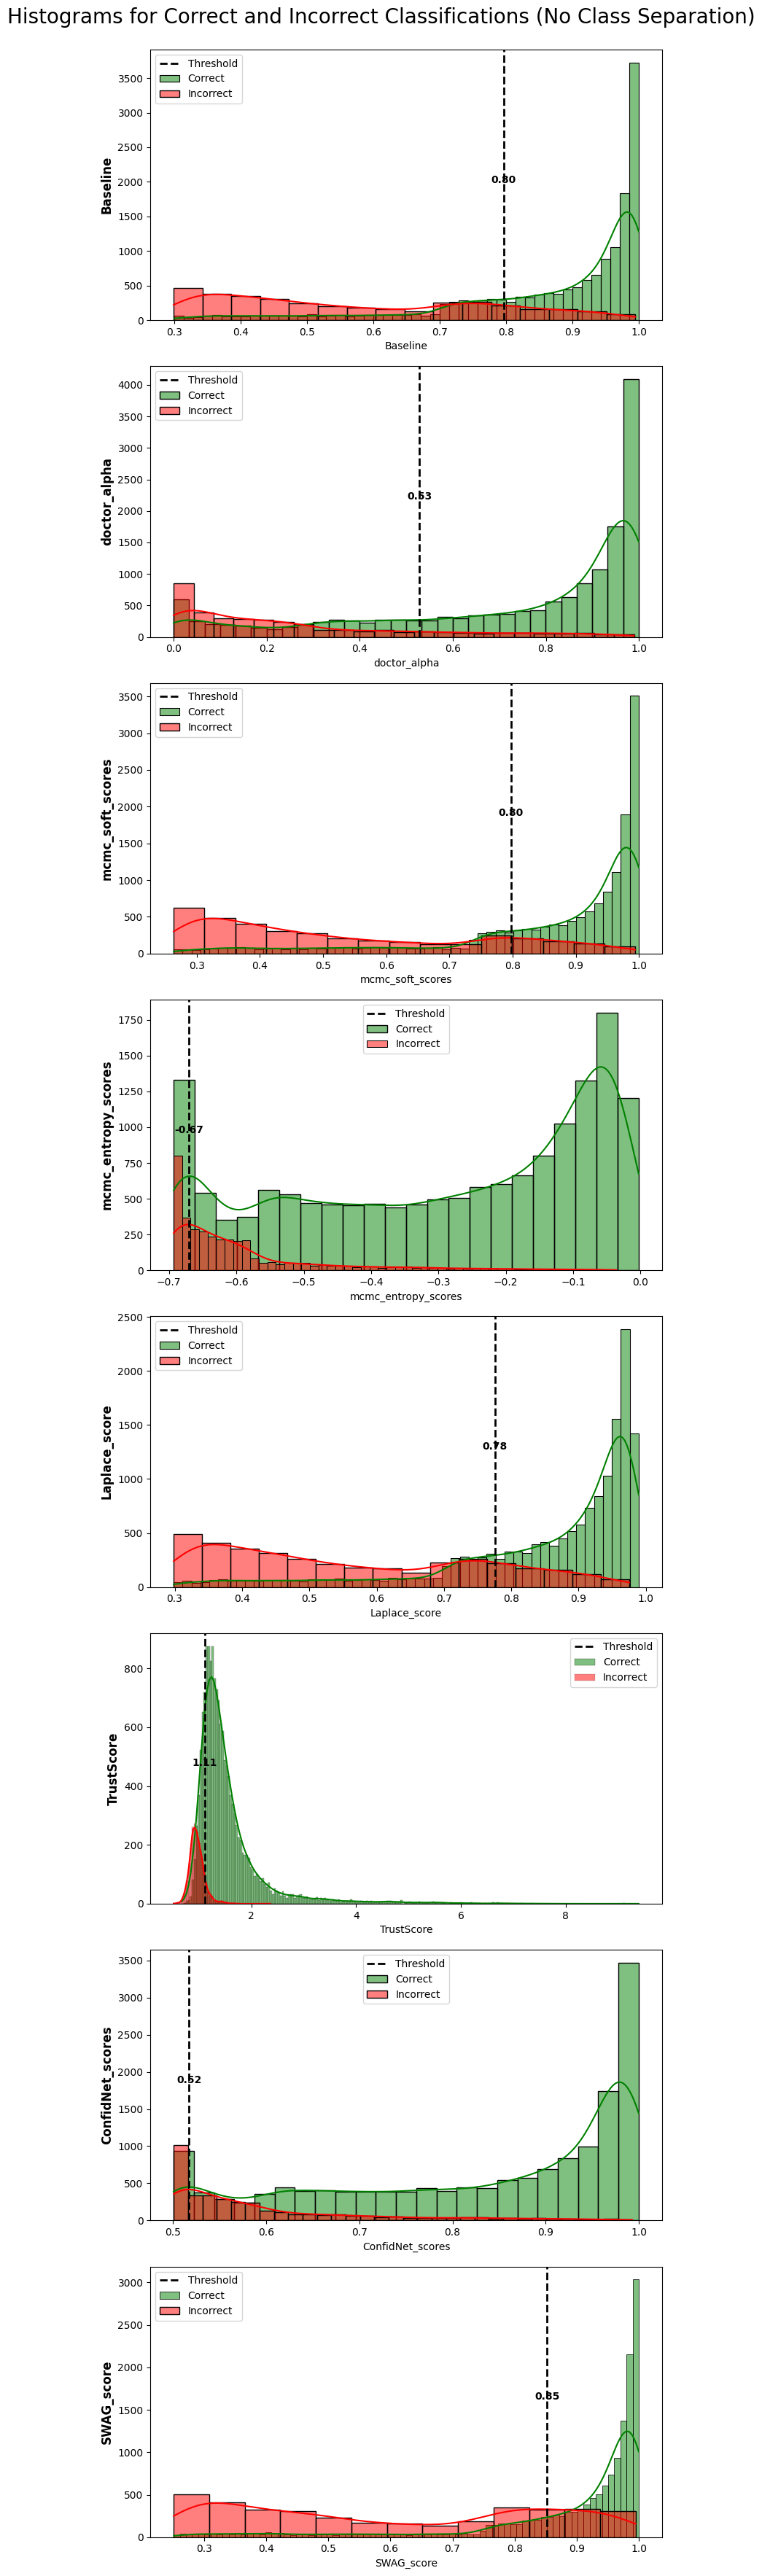

Seed    Scoring_Method  Threshold
0    42          Baseline   0.796417
1    42      doctor_alpha   0.528322
2    42  mcmc_soft_scores   0.797784
3    42     Laplace_score   0.775603
4    42  ConfidNet_scores   0.517349
5    42        SWAG_score   0.852190

### **Finding Optimal weights**
***

Scoring_Method  Threshold Rejection_Direction    Weight
0          Baseline   0.796417                   <  0.823497
1      doctor_alpha   0.528322                   <  0.827577
2  mcmc_soft_scores   0.797784                   <  0.833378
3     Laplace_score   0.775603                   <  0.821173
4  ConfidNet_scores   0.517349                   <  0.280392
5        SWAG_score   0.852190                   <  0.788729

### **Validation process**
***

#### **Validation seed: 10**
***

##### **Calculate confidence score**
***

Targets  Predictions  IsCorrect    Probas  Threshold  Baseline  \
0           0        False       True  0.120629     0.2514  0.879371   
1           0        False       True  0.015437     0.2514  0.984563   
2           0        False       True  0.204569     0.2514  0.795431   
3           0        False       True  0.020883     0.2514  0.979117   
4           1         True       True  0.404807     0.2514  0.404807   
...       ...          ...        ...       ...        ...       ...   
5332        0         True      False  0.414607     0.2514  0.414607   
5333        0        False       True  0.016182     0.2514  0.983818   
5334        1         True       True  0.716283     0.2514  0.716283   
5335        1         True       True  0.897099     0.2514  0.897099   
5336        0        False       True  0.006760     0.2514  0.993240   

      doctor_alpha  mcmc_soft_scores  mcmc_predictions  mcmc_probas  ...  \
0         0.730714          0.872454             False     0.127546  ...   
1         0.968650          0.980743             False     0.019257  ...   
2         0.517550          0.798938             False     0.201062  ...   
3         0.957362          0.973877             False     0.026123  ...   
4         0.069957          0.399427              True     0.399427  ...   
...            ...               ...               ...          ...  ...   
5332      0.056682          0.384239              True     0.384239  ...   
5333      0.967113          0.972169             False     0.027831  ...   
5334      0.315242          0.692529              True     0.692529  ...   
5335      0.773571          0.857830              True     0.857830  ...   
5336      0.986390          0.991054             False     0.008946  ...   

      Laplace_score  Laplace_probas  TrustScore  ConfidNet_scores  \
0          0.861275        0.138725    1.021478          0.832027   
1          0.965907        0.034093    1.366800          0.982724   
2          0.780711        0.219289    1.150789          0.706421   
3          0.961532        0.038468    1.470300          0.972814   
4          0.408548        0.408548    1.026057          0.538007   
...             ...             ...         ...               ...   
5332       0.416400        0.416400    1.085031          0.528210   
5333       0.966852        0.033148    1.277399          0.981498   
5334       0.708652        0.708652    0.946856          0.548512   
5335       0.874433        0.874433    1.191389          0.764287   
5336       0.977124        0.022876    1.577930          0.993575   

      SWAG_probas  SWAG_targets  SWAG_predictions  SWAG_threshold  SWAG_score  \
0        0.077146             0             False        0.322991    0.922854   
1        0.051407             0             False        0.322991    0.948593   
2        0.044643             0             False        0.322991    0.955357   
3        0.027361             0             False        0.322991    0.972639   
4        0.373209             1              True        0.322991    0.373209   
...           ...           ...               ...             ...         ...   
5332     0.389461             0              True        0.322991    0.389461   
5333     0.055352             0             False        0.322991    0.944648   
5334     0.868984             1              True        0.322991    0.868984   
5335     0.967013             1              True        0.322991    0.967013   
5336     0.020007             0             False        0.322991    0.979993   

      Confidence_score  
0            62.073250  
1            70.777534  
2            37.641784  
3            70.661655  
4             2.514212  
...                ...  
5332          2.468426  
5333         70.582375  
5334         13.986510  
5335         63.148602  
5336         71.901542  

[5337 rows x 24 columns]

##### **Rejection**
***

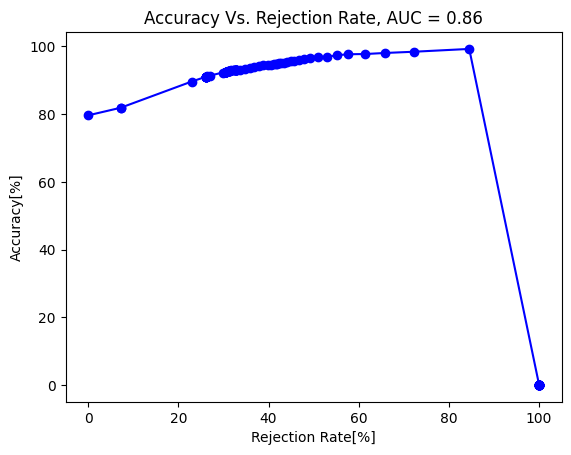

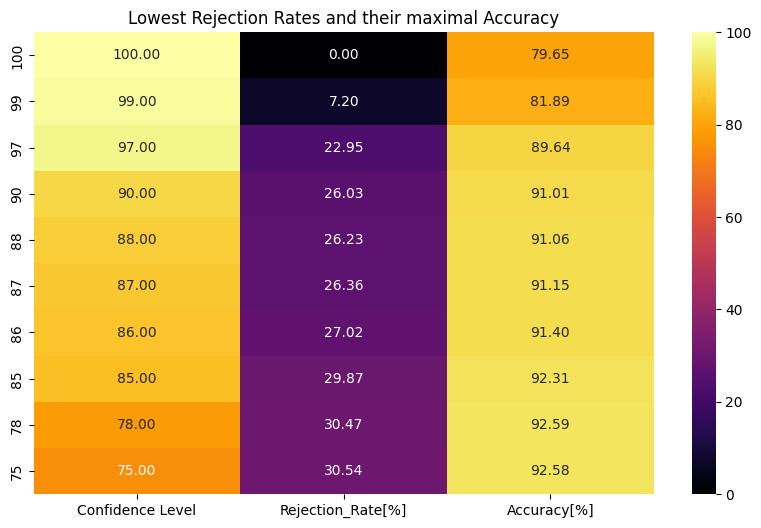

##### **Confusion Matrix**
***

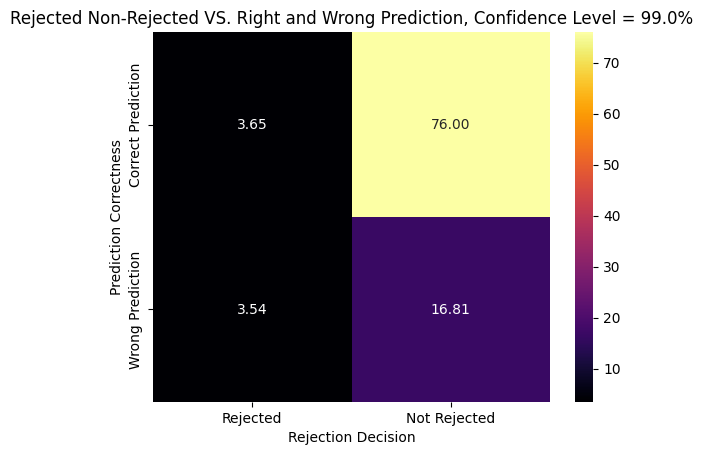

#### **Validation seed: 21**
***

##### **Calculate confidence score**
***

Targets  Predictions  IsCorrect    Probas  Threshold  Baseline  \
0           0         True      False  0.321550    0.29619  0.321550   
1           0        False       True  0.031009    0.29619  0.968991   
2           0        False       True  0.038104    0.29619  0.961896   
3           0        False       True  0.019519    0.29619  0.980481   
4           1         True       True  0.508203    0.29619  0.508203   
...       ...          ...        ...       ...        ...       ...   
5332        0         True      False  0.408512    0.29619  0.408512   
5333        0        False       True  0.065861    0.29619  0.934139   
5334        1         True       True  0.801508    0.29619  0.801508   
5335        1         True       True  0.947120    0.29619  0.947120   
5336        0        False       True  0.012450    0.29619  0.987550   

      doctor_alpha  mcmc_soft_scores  mcmc_predictions  mcmc_probas  ...  \
0         0.225972          0.758355             False     0.241645  ...   
1         0.936062          0.953302             False     0.046698  ...   
2         0.920897          0.943200             False     0.056800  ...   
3         0.960201          0.969269             False     0.030731  ...   
4         0.000538          0.469897              True     0.469897  ...   
...            ...               ...               ...          ...  ...   
5332      0.064791          0.387686              True     0.387686  ...   
5333      0.859690          0.919590             False     0.080410  ...   
5334      0.533324          0.705837              True     0.705837  ...   
5335      0.888683          0.924435              True     0.924435  ...   
5336      0.974791          0.982866             False     0.017134  ...   

      Laplace_score  Laplace_probas  TrustScore  ConfidNet_scores  \
0          0.339911        0.339911    0.924052          0.566204   
1          0.936509        0.063491    1.291472          0.950077   
2          0.932482        0.067518    1.226272          0.935607   
3          0.953912        0.046088    1.156958          0.970550   
4          0.507792        0.507792    0.926226          0.503401   
...             ...             ...         ...               ...   
5332       0.413174        0.413174    0.938454          0.517474   
5333       0.902993        0.097007    1.281148          0.889908   
5334       0.780692        0.780692    0.977375          0.621266   
5335       0.907500        0.907500    1.442724          0.868380   
5336       0.959542        0.040458    1.296394          0.982058   

      SWAG_probas  SWAG_targets  SWAG_predictions  SWAG_threshold  SWAG_score  \
0        0.219659             0             False        0.300369    0.780341   
1        0.046895             0             False        0.300369    0.953105   
2        0.065541             0             False        0.300369    0.934459   
3        0.037009             0             False        0.300369    0.962991   
4        0.389541             1              True        0.300369    0.389541   
...           ...           ...               ...             ...         ...   
5332     0.489346             0              True        0.300369    0.489346   
5333     0.119221             0             False        0.300369    0.880779   
5334     0.734722             1              True        0.300369    0.734722   
5335     0.929076             1              True        0.300369    0.929076   
5336     0.024704             0             False        0.300369    0.975296   

      Confidence_score  
0             2.645982  
1            69.237606  
2            68.422866  
3            70.413843  
4             0.000000  
...                ...  
5332          2.418258  
5333         65.546956  
5334         31.944792  
5335         66.788291  
5336         71.193558  

[5337 rows x 24 columns]

##### **Rejection**
***

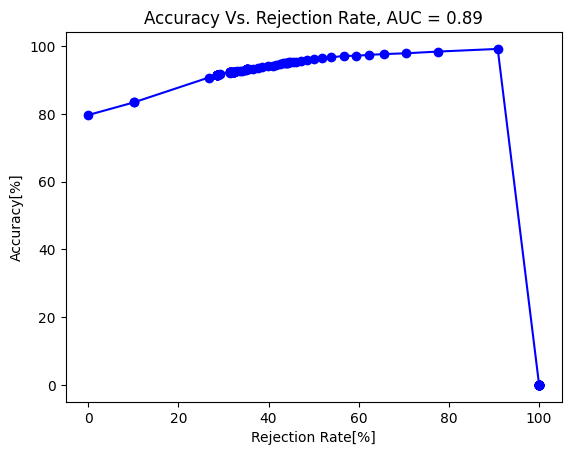

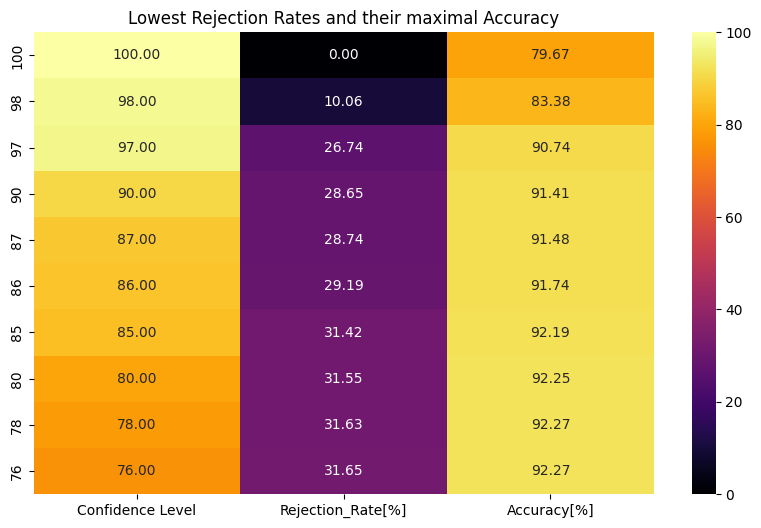

##### **Confusion Matrix**
***

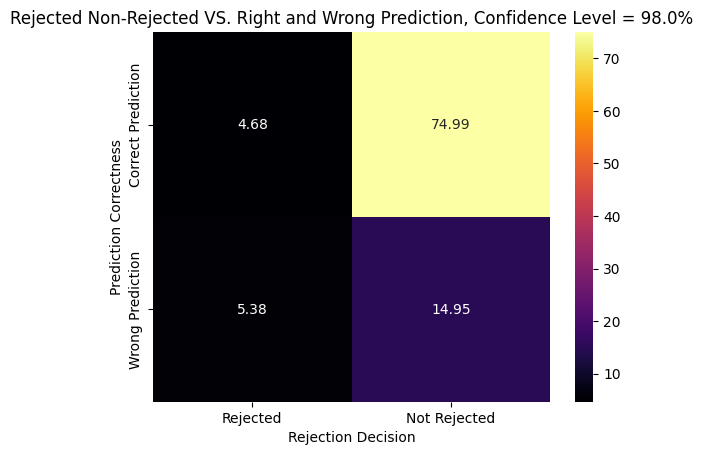

#### **Validation seed: 42**
***

##### **Calculate confidence score**
***

Targets  Predictions  IsCorrect    Probas  Threshold  Baseline  \
0           0        False       True  0.133607   0.299127  0.866393   
1           0        False       True  0.051193   0.299127  0.948806   
2           0        False       True  0.234509   0.299127  0.765491   
3           0        False       True  0.021759   0.299127  0.978241   
4           1         True       True  0.467279   0.299127  0.467279   
...       ...          ...        ...       ...        ...       ...   
5332        0        False       True  0.270805   0.299127  0.729195   
5333        0        False       True  0.064705   0.299127  0.935295   
5334        1         True       True  0.718077   0.299127  0.718077   
5335        1         True       True  0.906884   0.299127  0.906884   
5336        0        False       True  0.005742   0.299127  0.994258   

      doctor_alpha  mcmc_soft_scores  mcmc_predictions  mcmc_probas  ...  \
0         0.698742          0.859273             False     0.140727  ...   
1         0.892402          0.959722             False     0.040278  ...   
2         0.439866          0.842793             False     0.157207  ...   
3         0.955535          0.975401             False     0.024599  ...   
4         0.008528          0.437282              True     0.437282  ...   
...            ...               ...               ...          ...  ...   
5332      0.347272          0.291648              True     0.291648  ...   
5333      0.862296          0.938056             False     0.061944  ...   
5334      0.319654          0.686622              True     0.686622  ...   
5335      0.796788          0.862960              True     0.862960  ...   
5336      0.988449          0.995013             False     0.004987  ...   

      Laplace_score  Laplace_probas  TrustScore  ConfidNet_scores  \
0          0.853492        0.146508    1.008468          0.788767   
1          0.923794        0.076207    1.098191          0.908427   
2          0.751112        0.248888    1.247477          0.644048   
3          0.957669        0.042331    1.444366          0.963062   
4          0.468266        0.468266    1.074364          0.506450   
...             ...             ...         ...               ...   
5332       0.723807        0.276193    1.094813          0.632205   
5333       0.909725        0.090275    1.422165          0.893443   
5334       0.709768        0.709768    1.061580          0.591341   
5335       0.882833        0.882833    1.251781          0.819405   
5336       0.973608        0.026392    1.672861          0.991033   

      SWAG_probas  SWAG_targets  SWAG_predictions  SWAG_threshold  SWAG_score  \
0        0.139830             0             False        0.266712    0.860170   
1        0.036591             0             False        0.266712    0.963409   
2        0.024665             0             False        0.266712    0.975335   
3        0.036590             0             False        0.266712    0.963410   
4        0.427699             1              True        0.266712    0.427699   
...           ...           ...               ...             ...         ...   
5332     0.387565             0              True        0.266712    0.387565   
5333     0.057003             0             False        0.266712    0.942997   
5334     0.767467             1              True        0.266712    0.767467   
5335     0.991727             1              True        0.266712    0.991727   
5336     0.009560             0             False        0.266712    0.990440   

      Confidence_score  
0            60.138368  
1            68.214324  
2            27.537080  
3            70.425841  
4             0.000000  
...                ...  
5332          2.954418  
5333         66.781810  
5334          2.763449  
5335         64.371800  
5336         72.076243  

[5337 rows x 24 columns]

##### **Rejection**
***

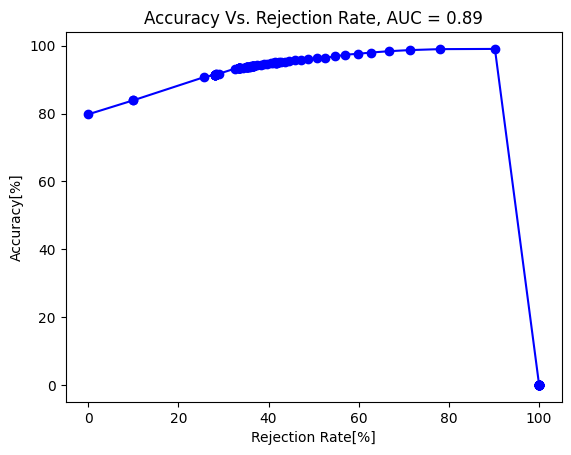

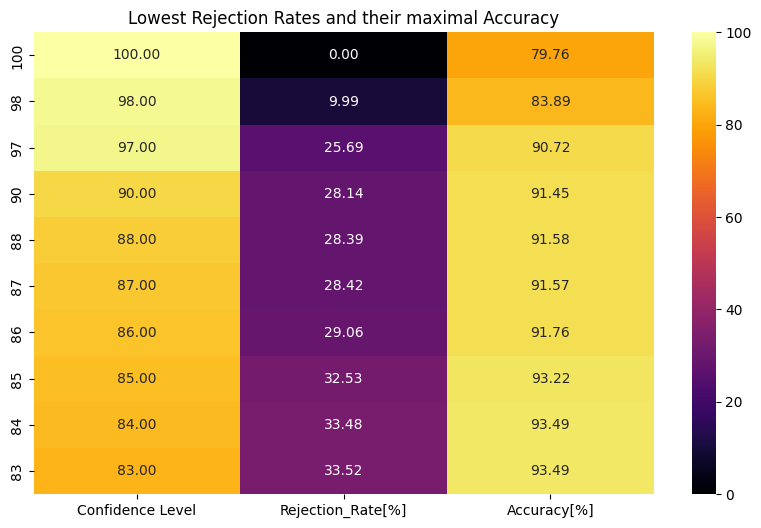

##### **Confusion Matrix**
***

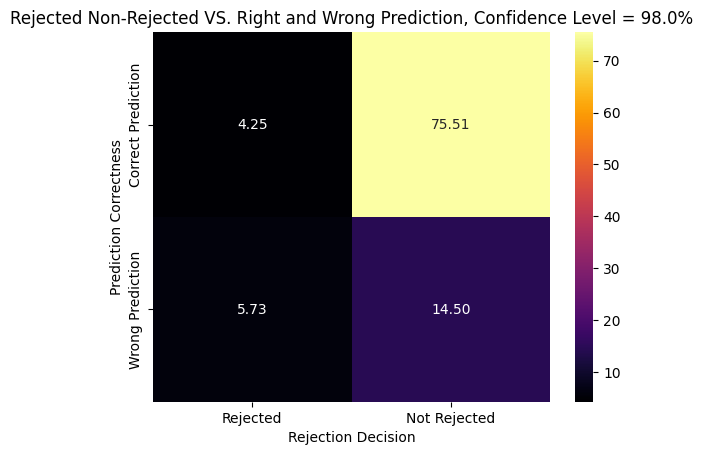

#### **Validation seed: 55**
***

##### **Calculate confidence score**
***

Targets  Predictions  IsCorrect    Probas  Threshold  Baseline  \
0           0        False       True  0.069185   0.256104  0.930815   
1           0        False       True  0.042340   0.256104  0.957660   
2           0        False       True  0.119516   0.256104  0.880484   
3           0        False       True  0.020617   0.256104  0.979383   
4           1         True       True  0.501353   0.256104  0.501353   
...       ...          ...        ...       ...        ...       ...   
5332        0         True      False  0.299088   0.256104  0.299088   
5333        0        False       True  0.041803   0.256104  0.958197   
5334        1         True       True  0.592492   0.256104  0.592492   
5335        1         True       True  0.824778   0.256104  0.824778   
5336        0        False       True  0.008859   0.256104  0.991141   

      doctor_alpha  mcmc_soft_scores  mcmc_predictions  mcmc_probas  ...  \
0         0.852162          0.910226             False     0.089774  ...   
1         0.911750          0.966602             False     0.033398  ...   
2         0.733433          0.880902             False     0.119098  ...   
3         0.957917          0.975860             False     0.024140  ...   
4         0.000015          0.450166              True     0.450166  ...   
...            ...               ...               ...          ...  ...   
5332      0.278032          0.276369              True     0.276369  ...   
5333      0.912912          0.940770             False     0.059231  ...   
5334      0.066174          0.523718              True     0.523718  ...   
5335      0.593453          0.742194              True     0.742194  ...   
5336      0.982126          0.992120             False     0.007880  ...   

      Laplace_score  Laplace_probas  TrustScore  ConfidNet_scores  \
0          0.910820        0.089180    1.170258          0.883999   
1          0.931371        0.068629    1.159251          0.929127   
2          0.855339        0.144661    1.575550          0.786745   
3          0.956010        0.043990    1.306924          0.963050   
4          0.501297        0.501297    1.012178          0.499037   
...             ...             ...         ...               ...   
5332       0.305883        0.305883    0.947422          0.584395   
5333       0.929239        0.070761    1.334533          0.920293   
5334       0.587575        0.587575    0.886118          0.518437   
5335       0.800733        0.800733    1.214010          0.709114   
5336       0.967610        0.032390    1.476120          0.983707   

      SWAG_probas  SWAG_targets  SWAG_predictions  SWAG_threshold  SWAG_score  \
0        0.202565             0             False        0.365878    0.797435   
1        0.047159             0             False        0.365878    0.952841   
2        0.091072             0             False        0.365878    0.908928   
3        0.058561             0             False        0.365878    0.941439   
4        0.400292             1              True        0.365878    0.400292   
...           ...           ...               ...             ...         ...   
5332     0.438121             0              True        0.365878    0.438121   
5333     0.099077             0             False        0.365878    0.900923   
5334     0.844504             1              True        0.365878    0.844504   
5335     0.990643             1              True        0.365878    0.990643   
5336     0.027085             0             False        0.365878    0.972915   

      Confidence_score  
0            53.768683  
1            68.759796  
2            61.767459  
3            70.169155  
4             0.000000  
...                ...  
5332          2.730991  
5333         67.671432  
5334          2.422755  
5335         46.800811  
5336         71.559361  

[5337 rows x 24 columns]

##### **Rejection**
***

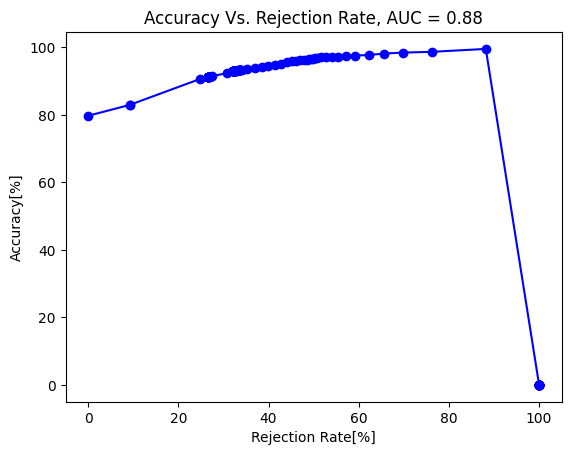

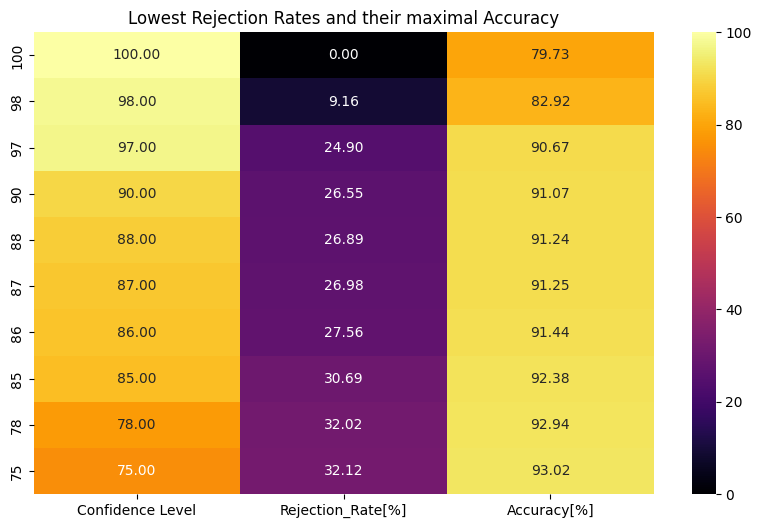

##### **Confusion Matrix**
***

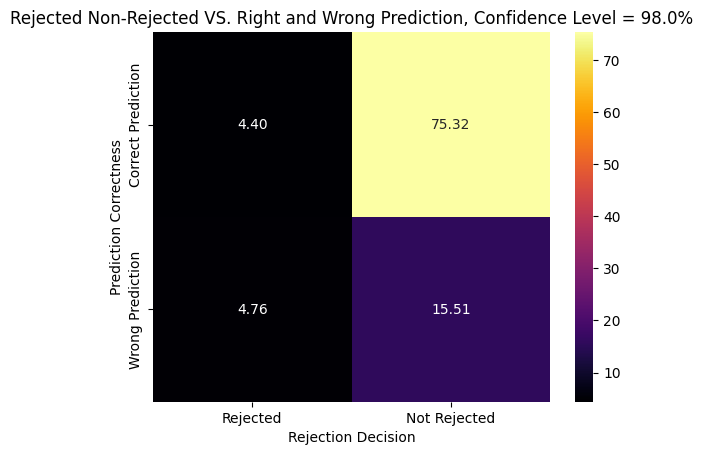

#### **Validation seed: 84**
***

##### **Calculate confidence score**
***

Targets  Predictions  IsCorrect    Probas  Threshold  Baseline  \
0           0        False       True  0.111794   0.276579  0.888206   
1           0        False       True  0.042738   0.276579  0.957262   
2           0        False       True  0.103509   0.276579  0.896491   
3           0        False       True  0.013938   0.276579  0.986062   
4           1         True       True  0.505930   0.276579  0.505930   
...       ...          ...        ...       ...        ...       ...   
5332        0         True      False  0.424185   0.276579  0.424185   
5333        0        False       True  0.028907   0.276579  0.971093   
5334        1         True       True  0.672492   0.276579  0.672492   
5335        1         True       True  0.943981   0.276579  0.943981   
5336        0        False       True  0.004062   0.276579  0.995938   

      doctor_alpha  mcmc_soft_scores  mcmc_predictions  mcmc_probas  ...  \
0         0.752196          0.878455             False     0.121545  ...   
1         0.910886          0.962467             False     0.037533  ...   
2         0.772119          0.922193             False     0.077807  ...   
3         0.971736          0.981936             False     0.018064  ...   
4         0.000281          0.454494              True     0.454494  ...   
...            ...               ...               ...          ...  ...   
5332      0.044949          0.396572              True     0.396572  ...   
5333      0.940518          0.967490             False     0.032510  ...   
5334      0.212712          0.588014              True     0.588014  ...   
5335      0.881729          0.878429              True     0.878429  ...   
5336      0.991843          0.996565             False     0.003435  ...   

      Laplace_score  Laplace_probas  TrustScore  ConfidNet_scores  \
0          0.867362        0.132638    1.173740          0.808673   
1          0.927564        0.072436    1.403481          0.930165   
2          0.862245        0.137755    1.234549          0.807743   
3          0.960933        0.039067    1.280152          0.977662   
4          0.505474        0.505474    1.152270          0.502244   
...             ...             ...         ...               ...   
5332       0.427478        0.427478    1.036702          0.508862   
5333       0.941480        0.058520    1.446135          0.957650   
5334       0.661861        0.661861    1.051672          0.554597   
5335       0.905961        0.905961    1.327819          0.838565   
5336       0.973583        0.026417    2.157376          0.994981   

      SWAG_probas  SWAG_targets  SWAG_predictions  SWAG_threshold  SWAG_score  \
0        0.133959             0             False        0.359267    0.866041   
1        0.039606             0             False        0.359267    0.960394   
2        0.037233             0             False        0.359267    0.962766   
3        0.030653             0             False        0.359267    0.969348   
4        0.429829             1              True        0.359267    0.429829   
...           ...           ...               ...             ...         ...   
5332     0.505787             0              True        0.359267    0.505787   
5333     0.056578             0             False        0.359267    0.943422   
5334     0.856770             1              True        0.359267    0.856770   
5335     0.969893             1              True        0.359267    0.969893   
5336     0.023079             0             False        0.359267    0.976921   

      Confidence_score  
0            61.801501  
1            68.737012  
2            63.994640  
3            71.038352  
4             0.000000  
...                ...  
5332          0.000000  
5333         69.501098  
5334         13.854387  
5335         66.386443  
5336         72.008040  

[5337 rows x 24 columns]

##### **Rejection**
***

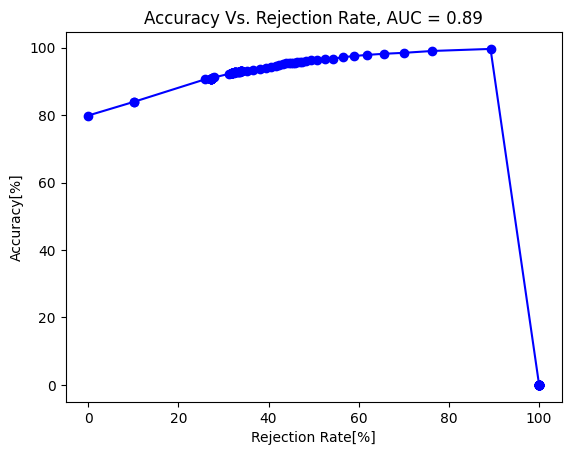

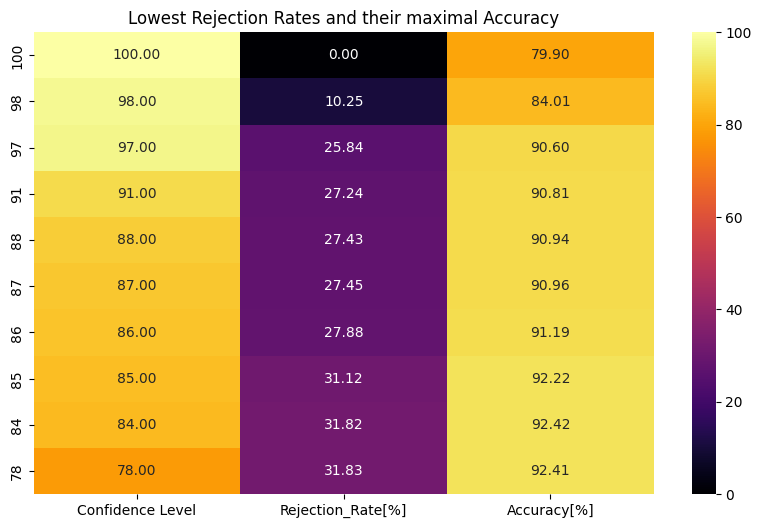

##### **Confusion Matrix**
***

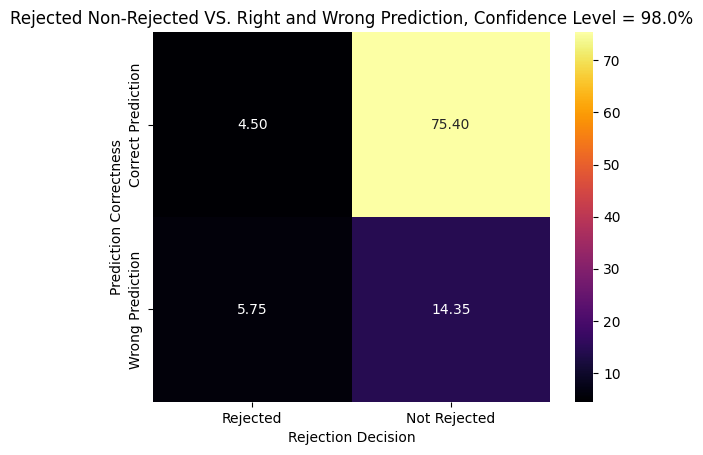

## **Train seed: 55**
***

### **Thresholding**
***

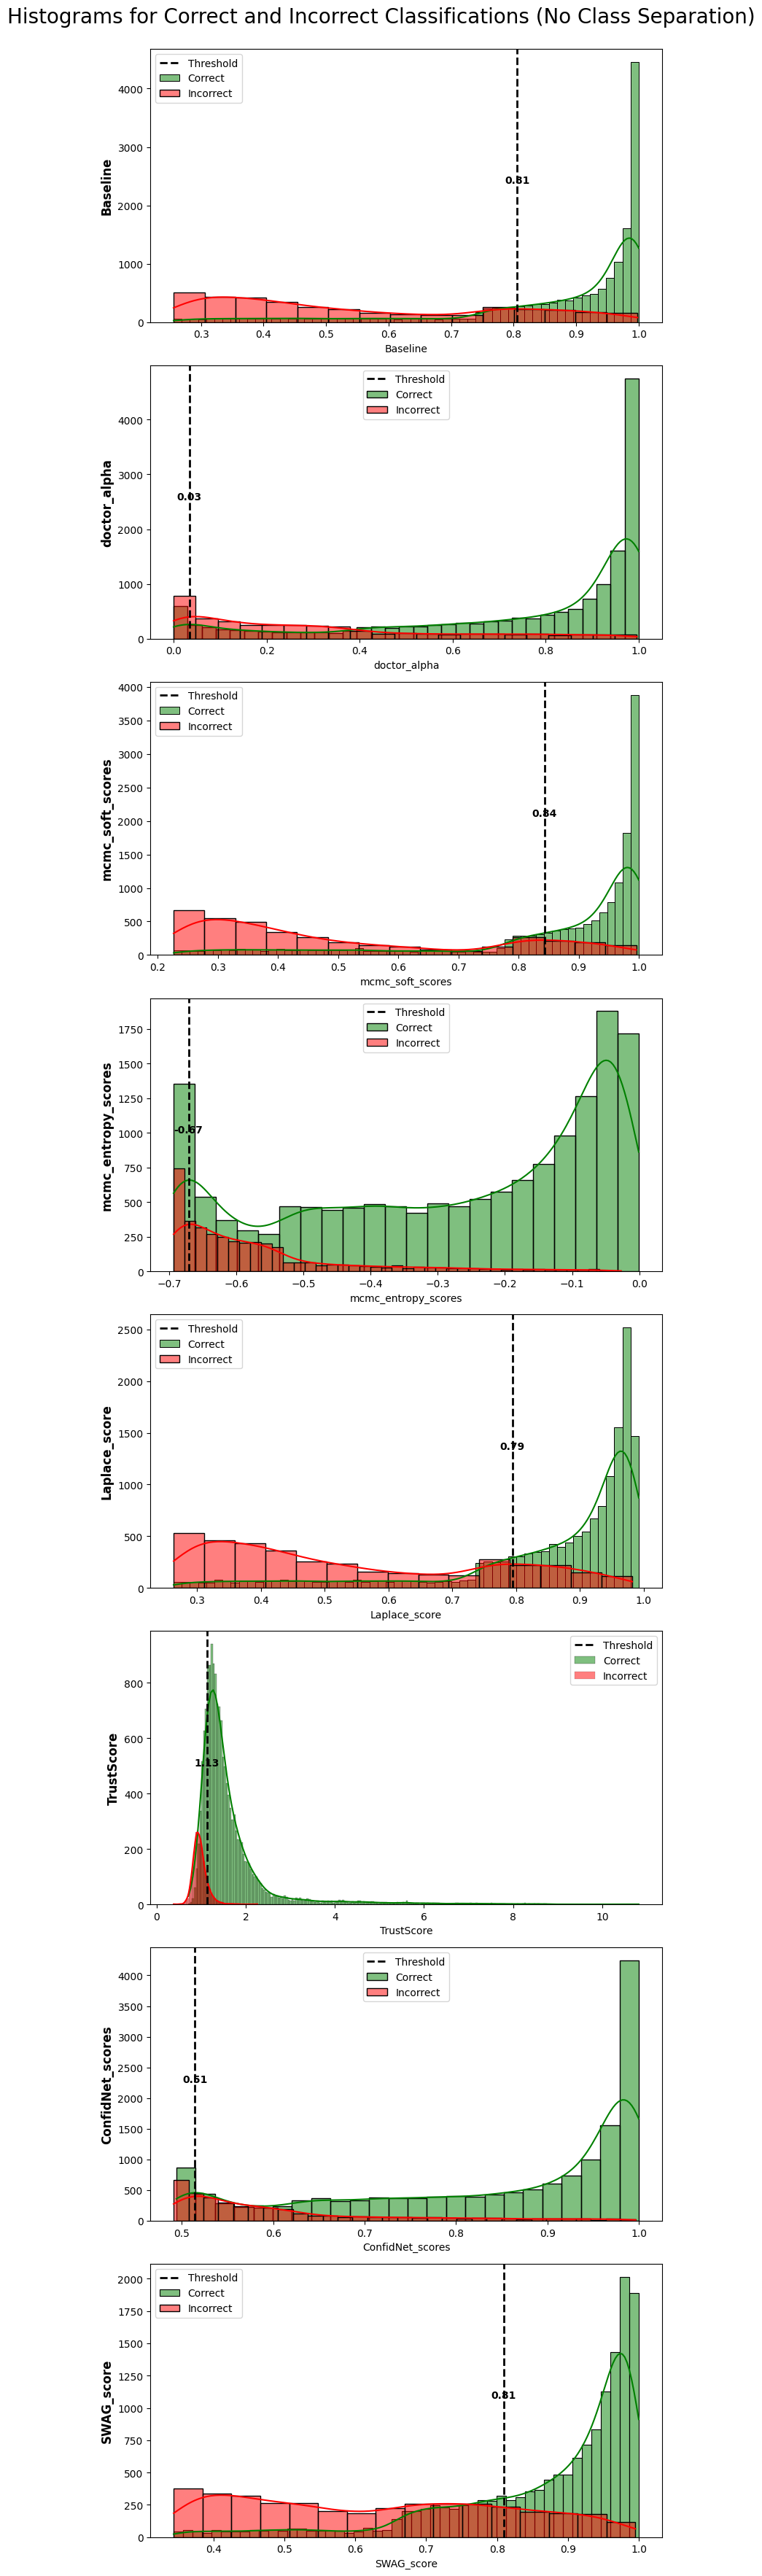

Seed    Scoring_Method  Threshold
0    55          Baseline   0.805641
1    55      doctor_alpha   0.034032
2    55  mcmc_soft_scores   0.843542
3    55     Laplace_score   0.794364
4    55  ConfidNet_scores   0.514500
5    55        SWAG_score   0.809392

### **Finding Optimal weights**
***

Scoring_Method  Threshold Rejection_Direction    Weight
0          Baseline   0.805641                   <  0.803505
1      doctor_alpha   0.034032                   <  0.176314
2  mcmc_soft_scores   0.843542                   <  0.858968
3     Laplace_score   0.794364                   <  0.817300
4  ConfidNet_scores   0.514500                   <  0.233404
5        SWAG_score   0.809392                   <  0.789364

### **Validation process**
***

#### **Validation seed: 10**
***

##### **Calculate confidence score**
***

Targets  Predictions  IsCorrect    Probas  Threshold  Baseline  \
0           0        False       True  0.120629     0.2514  0.879371   
1           0        False       True  0.015437     0.2514  0.984563   
2           0        False       True  0.204569     0.2514  0.795431   
3           0        False       True  0.020883     0.2514  0.979117   
4           1         True       True  0.404807     0.2514  0.404807   
...       ...          ...        ...       ...        ...       ...   
5332        0         True      False  0.414607     0.2514  0.414607   
5333        0        False       True  0.016182     0.2514  0.983818   
5334        1         True       True  0.716283     0.2514  0.716283   
5335        1         True       True  0.897099     0.2514  0.897099   
5336        0        False       True  0.006760     0.2514  0.993240   

      doctor_alpha  mcmc_soft_scores  mcmc_predictions  mcmc_probas  ...  \
0         0.730714          0.872454             False     0.127546  ...   
1         0.968650          0.980743             False     0.019257  ...   
2         0.517550          0.798938             False     0.201062  ...   
3         0.957362          0.973877             False     0.026123  ...   
4         0.069957          0.399427              True     0.399427  ...   
...            ...               ...               ...          ...  ...   
5332      0.056682          0.384239              True     0.384239  ...   
5333      0.967113          0.972169             False     0.027831  ...   
5334      0.315242          0.692529              True     0.692529  ...   
5335      0.773571          0.857830              True     0.857830  ...   
5336      0.986390          0.991054             False     0.008946  ...   

      Laplace_score  Laplace_probas  TrustScore  ConfidNet_scores  \
0          0.861275        0.138725    1.021478          0.832027   
1          0.965907        0.034093    1.366800          0.982724   
2          0.780711        0.219289    1.150789          0.706421   
3          0.961532        0.038468    1.470300          0.972814   
4          0.408548        0.408548    1.026057          0.538007   
...             ...             ...         ...               ...   
5332       0.416400        0.416400    1.085031          0.528210   
5333       0.966852        0.033148    1.277399          0.981498   
5334       0.708652        0.708652    0.946856          0.548512   
5335       0.874433        0.874433    1.191389          0.764287   
5336       0.977124        0.022876    1.577930          0.993575   

      SWAG_probas  SWAG_targets  SWAG_predictions  SWAG_threshold  SWAG_score  \
0        0.077146             0             False        0.322991    0.922854   
1        0.051407             0             False        0.322991    0.948593   
2        0.044643             0             False        0.322991    0.955357   
3        0.027361             0             False        0.322991    0.972639   
4        0.373209             1              True        0.322991    0.373209   
...           ...           ...               ...             ...         ...   
5332     0.389461             0              True        0.322991    0.389461   
5333     0.055352             0             False        0.322991    0.944648   
5334     0.868984             1              True        0.322991    0.868984   
5335     0.967013             1              True        0.322991    0.967013   
5336     0.020007             0             False        0.322991    0.979993   

      Confidence_score  
0            53.523507  
1            59.531788  
2            16.837629  
3            59.545614  
4             2.298460  
...                ...  
5332          2.221336  
5333         59.350763  
5334         14.492528  
5335         54.174195  
5336         60.455858  

[5337 rows x 24 columns]

##### **Rejection**
***

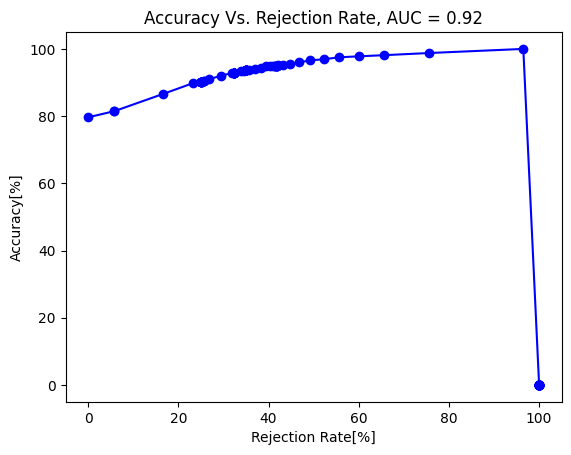

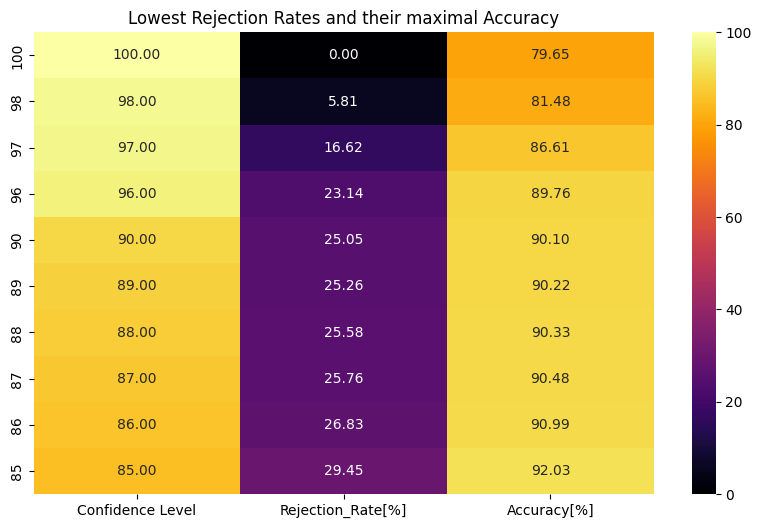

##### **Confusion Matrix**
***

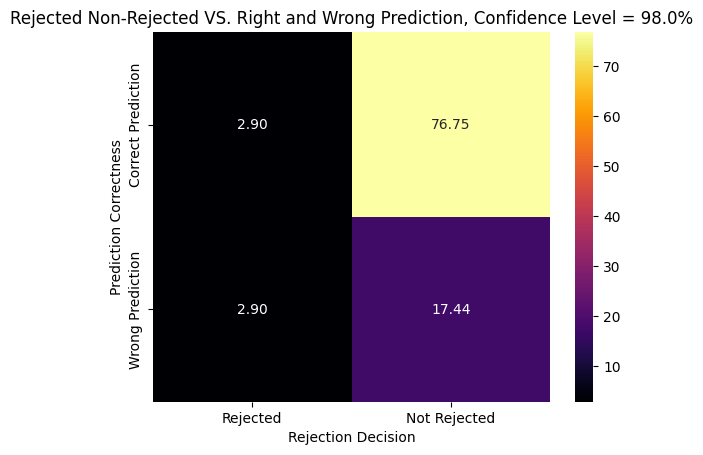

#### **Validation seed: 21**
***

##### **Calculate confidence score**
***

Targets  Predictions  IsCorrect    Probas  Threshold  Baseline  \
0           0         True      False  0.321550    0.29619  0.321550   
1           0        False       True  0.031009    0.29619  0.968991   
2           0        False       True  0.038104    0.29619  0.961896   
3           0        False       True  0.019519    0.29619  0.980481   
4           1         True       True  0.508203    0.29619  0.508203   
...       ...          ...        ...       ...        ...       ...   
5332        0         True      False  0.408512    0.29619  0.408512   
5333        0        False       True  0.065861    0.29619  0.934139   
5334        1         True       True  0.801508    0.29619  0.801508   
5335        1         True       True  0.947120    0.29619  0.947120   
5336        0        False       True  0.012450    0.29619  0.987550   

      doctor_alpha  mcmc_soft_scores  mcmc_predictions  mcmc_probas  ...  \
0         0.225972          0.758355             False     0.241645  ...   
1         0.936062          0.953302             False     0.046698  ...   
2         0.920897          0.943200             False     0.056800  ...   
3         0.960201          0.969269             False     0.030731  ...   
4         0.000538          0.469897              True     0.469897  ...   
...            ...               ...               ...          ...  ...   
5332      0.064791          0.387686              True     0.387686  ...   
5333      0.859690          0.919590             False     0.080410  ...   
5334      0.533324          0.705837              True     0.705837  ...   
5335      0.888683          0.924435              True     0.924435  ...   
5336      0.974791          0.982866             False     0.017134  ...   

      Laplace_score  Laplace_probas  TrustScore  ConfidNet_scores  \
0          0.339911        0.339911    0.924052          0.566204   
1          0.936509        0.063491    1.291472          0.950077   
2          0.932482        0.067518    1.226272          0.935607   
3          0.953912        0.046088    1.156958          0.970550   
4          0.507792        0.507792    0.926226          0.503401   
...             ...             ...         ...               ...   
5332       0.413174        0.413174    0.938454          0.517474   
5333       0.902993        0.097007    1.281148          0.889908   
5334       0.780692        0.780692    0.977375          0.621266   
5335       0.907500        0.907500    1.442724          0.868380   
5336       0.959542        0.040458    1.296394          0.982058   

      SWAG_probas  SWAG_targets  SWAG_predictions  SWAG_threshold  SWAG_score  \
0        0.219659             0             False        0.300369    0.780341   
1        0.046895             0             False        0.300369    0.953105   
2        0.065541             0             False        0.300369    0.934459   
3        0.037009             0             False        0.300369    0.962991   
4        0.389541             1              True        0.300369    0.389541   
...           ...           ...               ...             ...         ...   
5332     0.489346             0              True        0.300369    0.489346   
5333     0.119221             0             False        0.300369    0.880779   
5334     0.734722             1              True        0.300369    0.734722   
5335     0.929076             1              True        0.300369    0.929076   
5336     0.024704             0             False        0.300369    0.975296   

      Confidence_score  
0             2.866609  
1            58.366572  
2            57.725898  
3            59.266726  
4             0.000000  
...                ...  
5332          2.203403  
5333         55.550652  
5334          3.983981  
5335         56.492106  
5336         59.882279  

[5337 rows x 24 columns]

##### **Rejection**
***

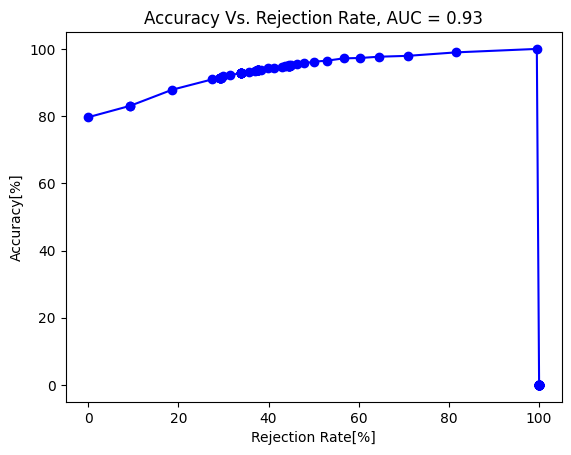

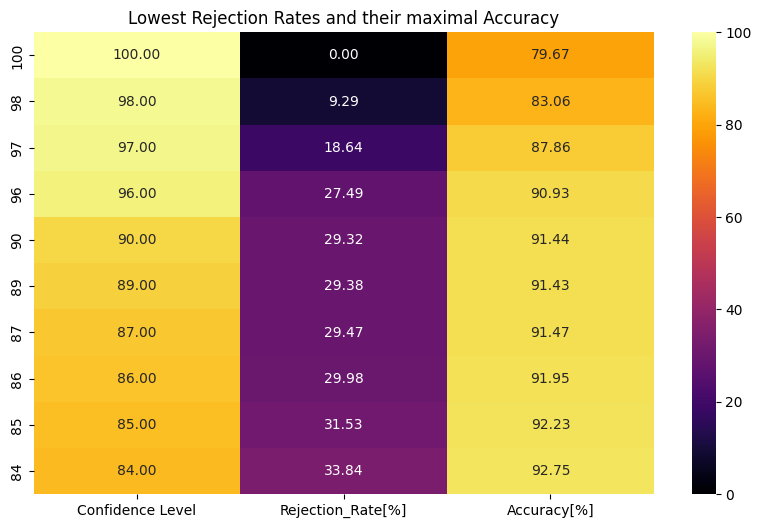

##### **Confusion Matrix**
***

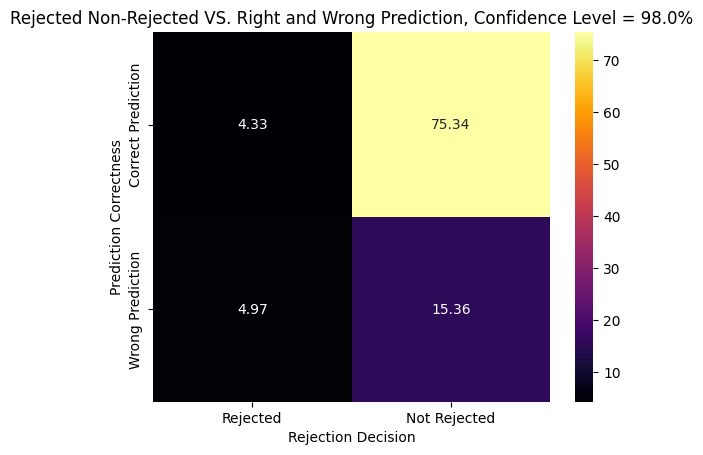

#### **Validation seed: 42**
***

##### **Calculate confidence score**
***

Targets  Predictions  IsCorrect    Probas  Threshold  Baseline  \
0           0        False       True  0.133607   0.299127  0.866393   
1           0        False       True  0.051193   0.299127  0.948806   
2           0        False       True  0.234509   0.299127  0.765491   
3           0        False       True  0.021759   0.299127  0.978241   
4           1         True       True  0.467279   0.299127  0.467279   
...       ...          ...        ...       ...        ...       ...   
5332        0        False       True  0.270805   0.299127  0.729195   
5333        0        False       True  0.064705   0.299127  0.935295   
5334        1         True       True  0.718077   0.299127  0.718077   
5335        1         True       True  0.906884   0.299127  0.906884   
5336        0        False       True  0.005742   0.299127  0.994258   

      doctor_alpha  mcmc_soft_scores  mcmc_predictions  mcmc_probas  ...  \
0         0.698742          0.859273             False     0.140727  ...   
1         0.892402          0.959722             False     0.040278  ...   
2         0.439866          0.842793             False     0.157207  ...   
3         0.955535          0.975401             False     0.024599  ...   
4         0.008528          0.437282              True     0.437282  ...   
...            ...               ...               ...          ...  ...   
5332      0.347272          0.291648              True     0.291648  ...   
5333      0.862296          0.938056             False     0.061944  ...   
5334      0.319654          0.686622              True     0.686622  ...   
5335      0.796788          0.862960              True     0.862960  ...   
5336      0.988449          0.995013             False     0.004987  ...   

      Laplace_score  Laplace_probas  TrustScore  ConfidNet_scores  \
0          0.853492        0.146508    1.008468          0.788767   
1          0.923794        0.076207    1.098191          0.908427   
2          0.751112        0.248888    1.247477          0.644048   
3          0.957669        0.042331    1.444366          0.963062   
4          0.468266        0.468266    1.074364          0.506450   
...             ...             ...         ...               ...   
5332       0.723807        0.276193    1.094813          0.632205   
5333       0.909725        0.090275    1.422165          0.893443   
5334       0.709768        0.709768    1.061580          0.591341   
5335       0.882833        0.882833    1.251781          0.819405   
5336       0.973608        0.026392    1.672861          0.991033   

      SWAG_probas  SWAG_targets  SWAG_predictions  SWAG_threshold  SWAG_score  \
0        0.139830             0             False        0.266712    0.860170   
1        0.036591             0             False        0.266712    0.963409   
2        0.024665             0             False        0.266712    0.975335   
3        0.036590             0             False        0.266712    0.963410   
4        0.427699             1              True        0.266712    0.427699   
...           ...           ...               ...             ...         ...   
5332     0.387565             0              True        0.266712    0.387565   
5333     0.057003             0             False        0.266712    0.942997   
5334     0.767467             1              True        0.266712    0.767467   
5335     0.991727             1              True        0.266712    0.991727   
5336     0.009560             0             False        0.266712    0.990440   

      Confidence_score  
0            51.968079  
1            57.860208  
2            16.629546  
3            59.338360  
4             0.000000  
...                ...  
5332          3.479807  
5333         56.762163  
5334          3.239683  
5335         55.100868  
5336         60.611879  

[5337 rows x 24 columns]

##### **Rejection**
***

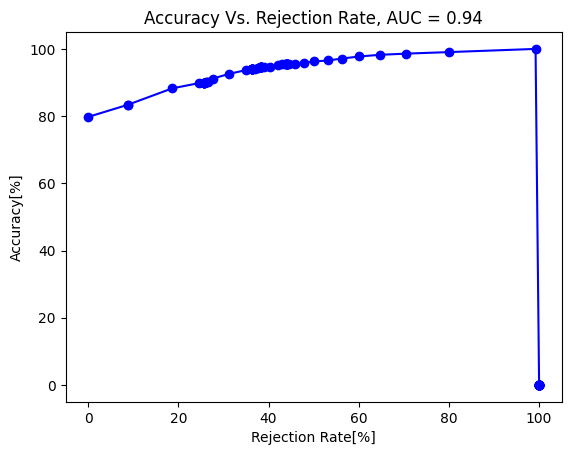

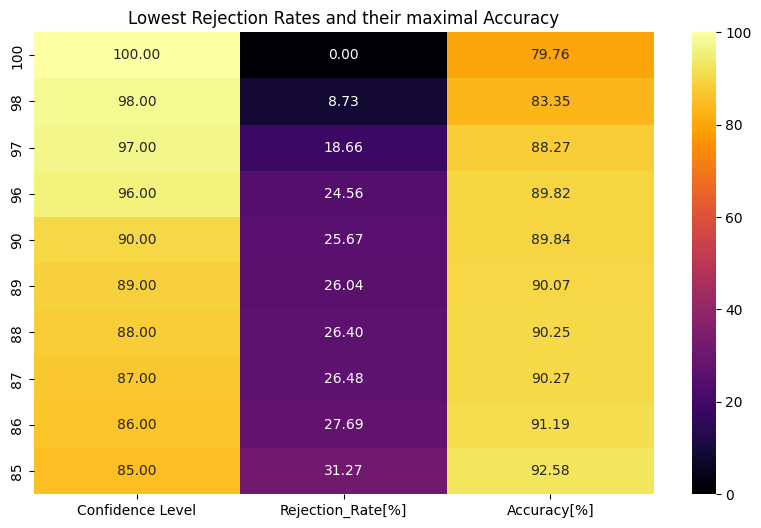

##### **Confusion Matrix**
***

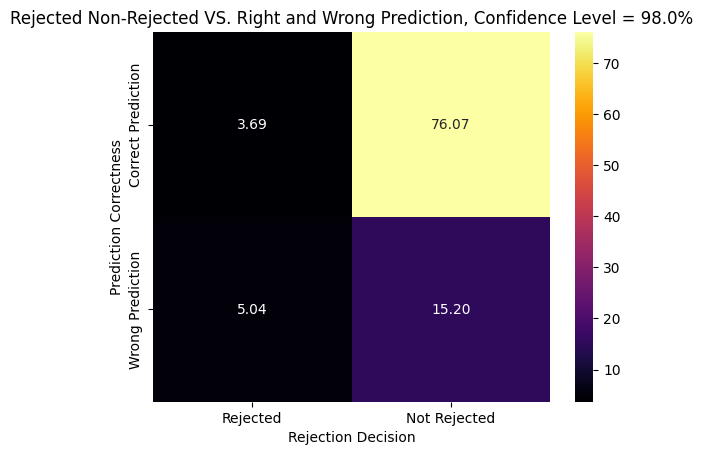

#### **Validation seed: 55**
***

##### **Calculate confidence score**
***

Targets  Predictions  IsCorrect    Probas  Threshold  Baseline  \
0           0        False       True  0.069185   0.256104  0.930815   
1           0        False       True  0.042340   0.256104  0.957660   
2           0        False       True  0.119516   0.256104  0.880484   
3           0        False       True  0.020617   0.256104  0.979383   
4           1         True       True  0.501353   0.256104  0.501353   
...       ...          ...        ...       ...        ...       ...   
5332        0         True      False  0.299088   0.256104  0.299088   
5333        0        False       True  0.041803   0.256104  0.958197   
5334        1         True       True  0.592492   0.256104  0.592492   
5335        1         True       True  0.824778   0.256104  0.824778   
5336        0        False       True  0.008859   0.256104  0.991141   

      doctor_alpha  mcmc_soft_scores  mcmc_predictions  mcmc_probas  ...  \
0         0.852162          0.910226             False     0.089774  ...   
1         0.911750          0.966602             False     0.033398  ...   
2         0.733433          0.880902             False     0.119098  ...   
3         0.957917          0.975860             False     0.024140  ...   
4         0.000015          0.450166              True     0.450166  ...   
...            ...               ...               ...          ...  ...   
5332      0.278032          0.276369              True     0.276369  ...   
5333      0.912912          0.940770             False     0.059231  ...   
5334      0.066174          0.523718              True     0.523718  ...   
5335      0.593453          0.742194              True     0.742194  ...   
5336      0.982126          0.992120             False     0.007880  ...   

      Laplace_score  Laplace_probas  TrustScore  ConfidNet_scores  \
0          0.910820        0.089180    1.170258          0.883999   
1          0.931371        0.068629    1.159251          0.929127   
2          0.855339        0.144661    1.575550          0.786745   
3          0.956010        0.043990    1.306924          0.963050   
4          0.501297        0.501297    1.012178          0.499037   
...             ...             ...         ...               ...   
5332       0.305883        0.305883    0.947422          0.584395   
5333       0.929239        0.070761    1.334533          0.920293   
5334       0.587575        0.587575    0.886118          0.518437   
5335       0.800733        0.800733    1.214010          0.709114   
5336       0.967610        0.032390    1.476120          0.983707   

      SWAG_probas  SWAG_targets  SWAG_predictions  SWAG_threshold  SWAG_score  \
0        0.202565             0             False        0.365878    0.797435   
1        0.047159             0             False        0.365878    0.952841   
2        0.091072             0             False        0.365878    0.908928   
3        0.058561             0             False        0.365878    0.941439   
4        0.400292             1              True        0.365878    0.400292   
...           ...           ...               ...             ...         ...   
5332     0.438121             0              True        0.365878    0.438121   
5333     0.099077             0             False        0.365878    0.900923   
5334     0.844504             1              True        0.365878    0.844504   
5335     0.990643             1              True        0.365878    0.990643   
5336     0.027085             0             False        0.365878    0.972915   

      Confidence_score  
0            43.845992  
1            58.178846  
2            53.227129  
3            59.055520  
4             0.000000  
...                ...  
5332          3.090355  
5333         57.073178  
5334         13.321572  
5335         39.487923  
5336         60.169379  

[5337 rows x 24 columns]

##### **Rejection**
***

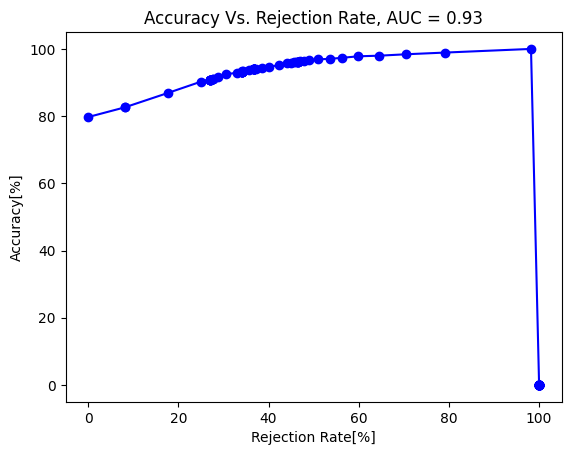

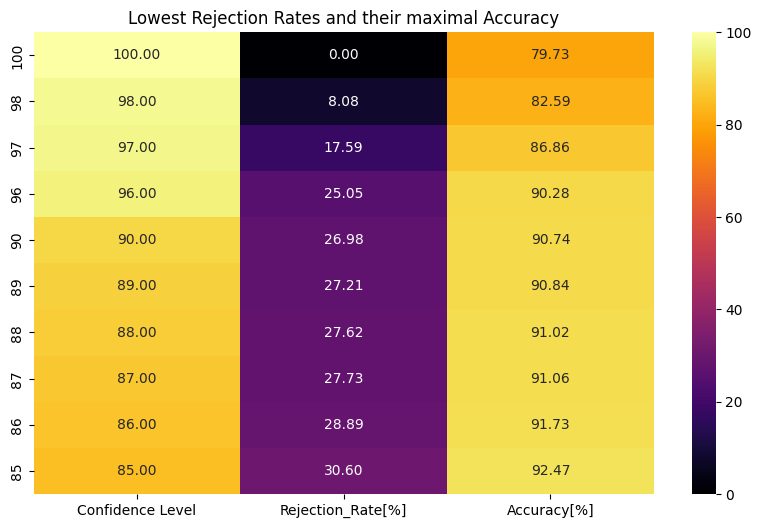

##### **Confusion Matrix**
***

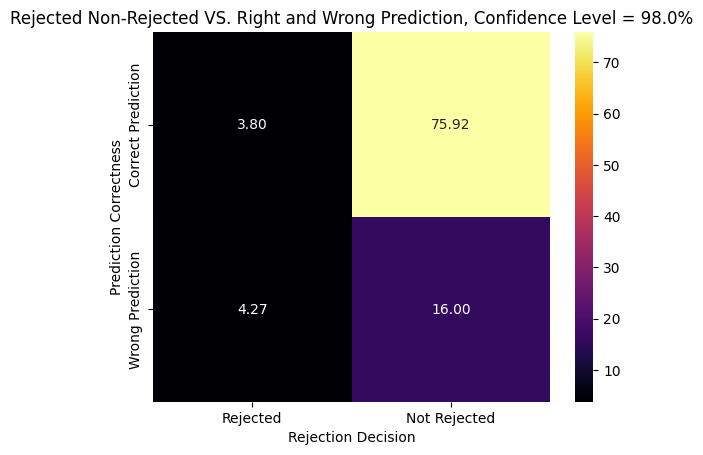

#### **Validation seed: 84**
***

##### **Calculate confidence score**
***

Targets  Predictions  IsCorrect    Probas  Threshold  Baseline  \
0           0        False       True  0.111794   0.276579  0.888206   
1           0        False       True  0.042738   0.276579  0.957262   
2           0        False       True  0.103509   0.276579  0.896491   
3           0        False       True  0.013938   0.276579  0.986062   
4           1         True       True  0.505930   0.276579  0.505930   
...       ...          ...        ...       ...        ...       ...   
5332        0         True      False  0.424185   0.276579  0.424185   
5333        0        False       True  0.028907   0.276579  0.971093   
5334        1         True       True  0.672492   0.276579  0.672492   
5335        1         True       True  0.943981   0.276579  0.943981   
5336        0        False       True  0.004062   0.276579  0.995938   

      doctor_alpha  mcmc_soft_scores  mcmc_predictions  mcmc_probas  ...  \
0         0.752196          0.878455             False     0.121545  ...   
1         0.910886          0.962467             False     0.037533  ...   
2         0.772119          0.922193             False     0.077807  ...   
3         0.971736          0.981936             False     0.018064  ...   
4         0.000281          0.454494              True     0.454494  ...   
...            ...               ...               ...          ...  ...   
5332      0.044949          0.396572              True     0.396572  ...   
5333      0.940518          0.967490             False     0.032510  ...   
5334      0.212712          0.588014              True     0.588014  ...   
5335      0.881729          0.878429              True     0.878429  ...   
5336      0.991843          0.996565             False     0.003435  ...   

      Laplace_score  Laplace_probas  TrustScore  ConfidNet_scores  \
0          0.867362        0.132638    1.173740          0.808673   
1          0.927564        0.072436    1.403481          0.930165   
2          0.862245        0.137755    1.234549          0.807743   
3          0.960933        0.039067    1.280152          0.977662   
4          0.505474        0.505474    1.152270          0.502244   
...             ...             ...         ...               ...   
5332       0.427478        0.427478    1.036702          0.508862   
5333       0.941480        0.058520    1.446135          0.957650   
5334       0.661861        0.661861    1.051672          0.554597   
5335       0.905961        0.905961    1.327819          0.838565   
5336       0.973583        0.026417    2.157376          0.994981   

      SWAG_probas  SWAG_targets  SWAG_predictions  SWAG_threshold  SWAG_score  \
0        0.133959             0             False        0.359267    0.866041   
1        0.039606             0             False        0.359267    0.960394   
2        0.037233             0             False        0.359267    0.962766   
3        0.030653             0             False        0.359267    0.969348   
4        0.429829             1              True        0.359267    0.429829   
...           ...           ...               ...             ...         ...   
5332     0.505787             0              True        0.359267    0.505787   
5333     0.056578             0             False        0.359267    0.943422   
5334     0.856770             1              True        0.359267    0.856770   
5335     0.969893             1              True        0.359267    0.969893   
5336     0.023079             0             False        0.359267    0.976921   

      Confidence_score  
0            53.035498  
1            58.163313  
2            55.030363  
3            59.763626  
4             0.000000  
...                ...  
5332          0.132087  
5333         58.580702  
5334         14.054216  
5335         56.171037  
5336         60.503713  

[5337 rows x 24 columns]

##### **Rejection**
***

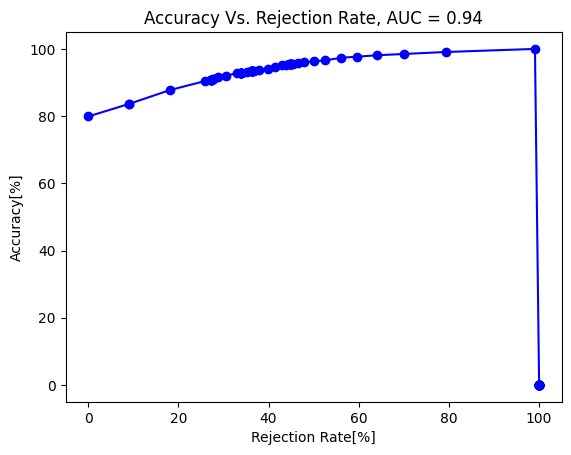

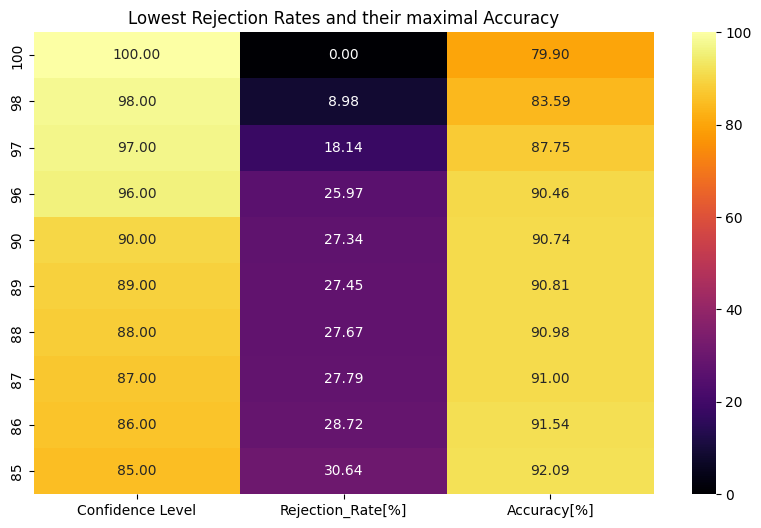

##### **Confusion Matrix**
***

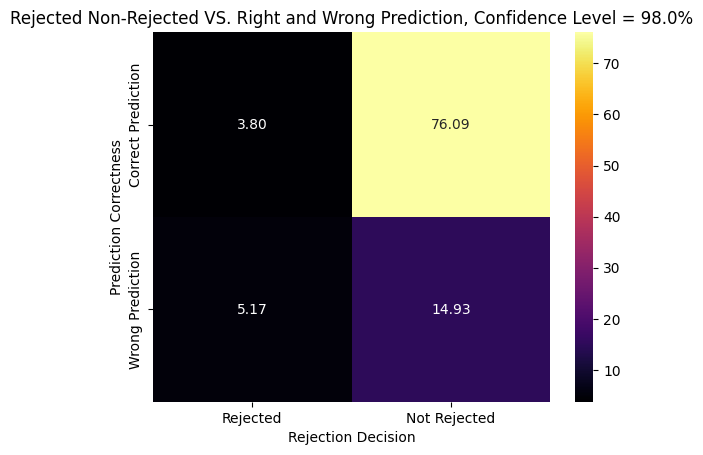

## **Train seed: 84**
***

### **Thresholding**
***

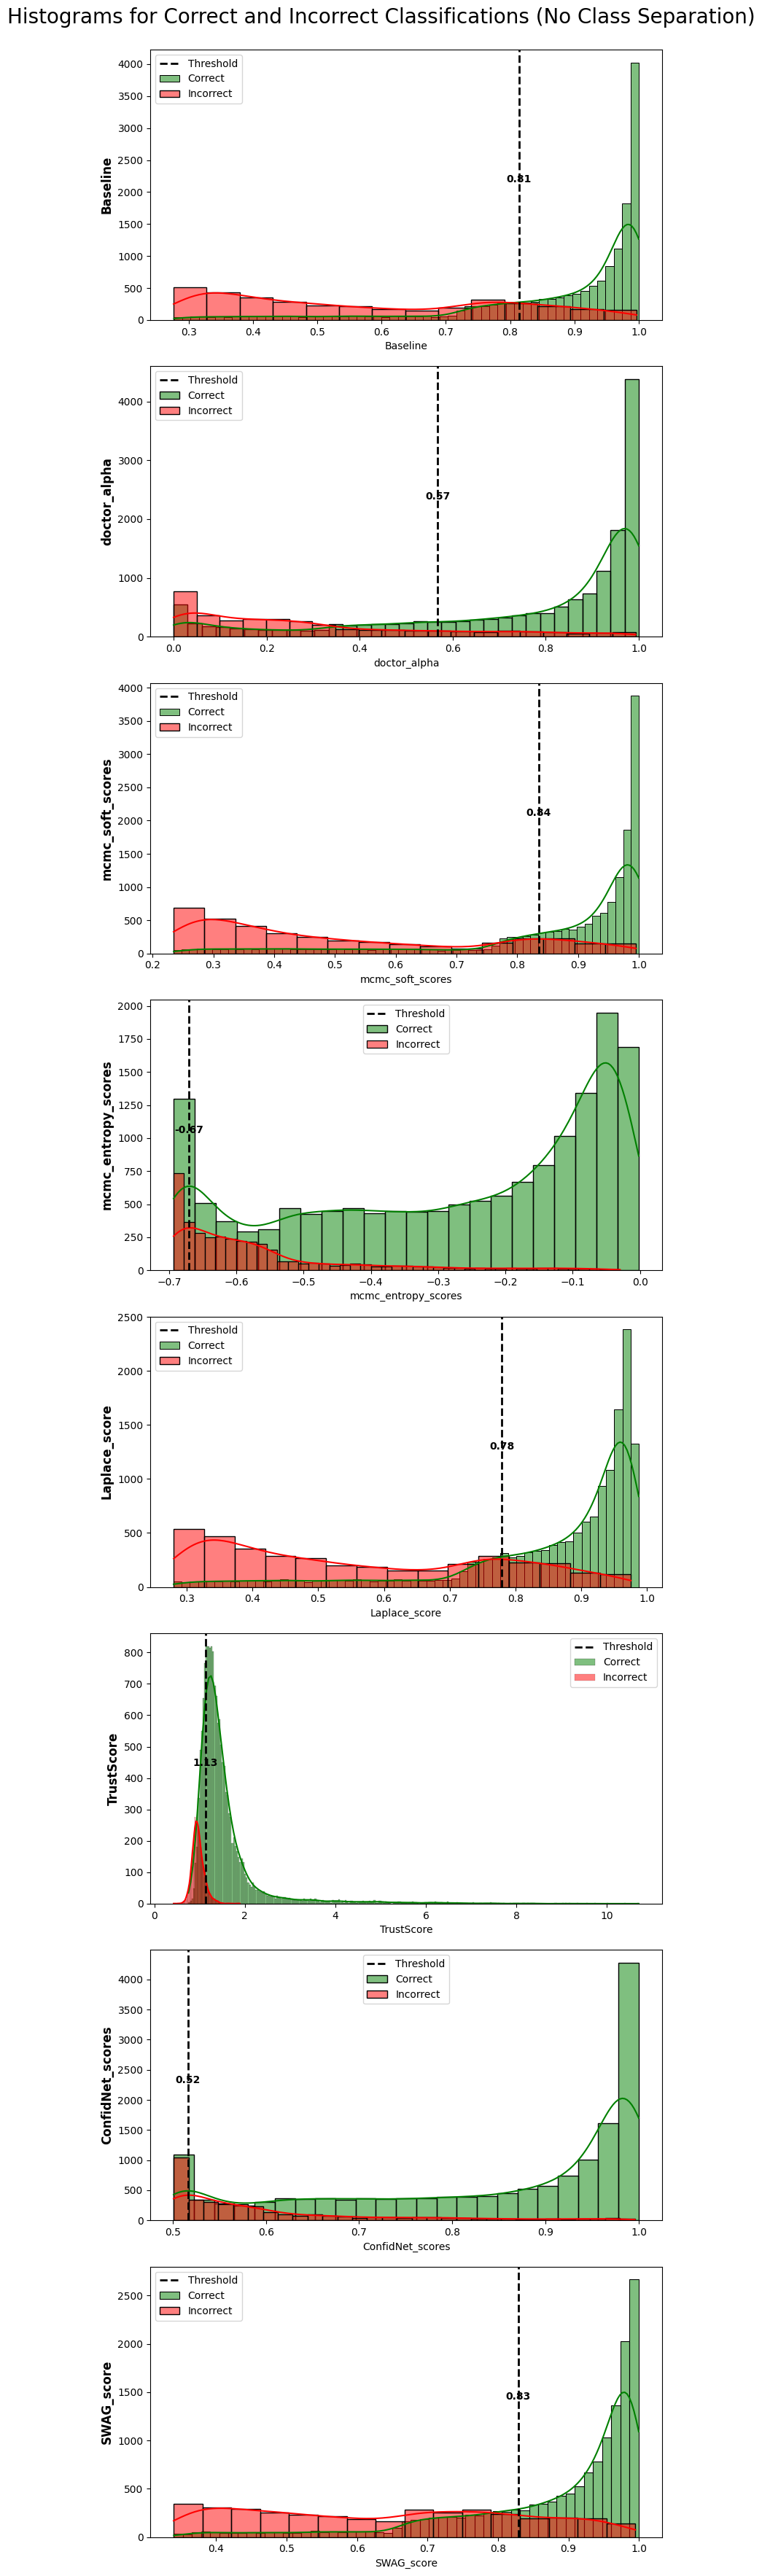

Seed    Scoring_Method  Threshold
0    84          Baseline   0.813865
1    84      doctor_alpha   0.567513
2    84  mcmc_soft_scores   0.835146
3    84     Laplace_score   0.779328
4    84  ConfidNet_scores   0.516483
5    84        SWAG_score   0.828583

### **Finding Optimal weights**
***

Scoring_Method  Threshold Rejection_Direction    Weight
0          Baseline   0.813865                   <  0.809007
1      doctor_alpha   0.567513                   <  0.811720
2  mcmc_soft_scores   0.835146                   <  0.849409
3     Laplace_score   0.779328                   <  0.802102
4  ConfidNet_scores   0.516483                   <  0.280792
5        SWAG_score   0.828583                   <  0.802576

### **Validation process**
***

#### **Validation seed: 10**
***

##### **Calculate confidence score**
***

Targets  Predictions  IsCorrect    Probas  Threshold  Baseline  \
0           0        False       True  0.120629     0.2514  0.879371   
1           0        False       True  0.015437     0.2514  0.984563   
2           0        False       True  0.204569     0.2514  0.795431   
3           0        False       True  0.020883     0.2514  0.979117   
4           1         True       True  0.404807     0.2514  0.404807   
...       ...          ...        ...       ...        ...       ...   
5332        0         True      False  0.414607     0.2514  0.414607   
5333        0        False       True  0.016182     0.2514  0.983818   
5334        1         True       True  0.716283     0.2514  0.716283   
5335        1         True       True  0.897099     0.2514  0.897099   
5336        0        False       True  0.006760     0.2514  0.993240   

      doctor_alpha  mcmc_soft_scores  mcmc_predictions  mcmc_probas  ...  \
0         0.730714          0.872454             False     0.127546  ...   
1         0.968650          0.980743             False     0.019257  ...   
2         0.517550          0.798938             False     0.201062  ...   
3         0.957362          0.973877             False     0.026123  ...   
4         0.069957          0.399427              True     0.399427  ...   
...            ...               ...               ...          ...  ...   
5332      0.056682          0.384239              True     0.384239  ...   
5333      0.967113          0.972169             False     0.027831  ...   
5334      0.315242          0.692529              True     0.692529  ...   
5335      0.773571          0.857830              True     0.857830  ...   
5336      0.986390          0.991054             False     0.008946  ...   

      Laplace_score  Laplace_probas  TrustScore  ConfidNet_scores  \
0          0.861275        0.138725    1.021478          0.832027   
1          0.965907        0.034093    1.366800          0.982724   
2          0.780711        0.219289    1.150789          0.706421   
3          0.961532        0.038468    1.470300          0.972814   
4          0.408548        0.408548    1.026057          0.538007   
...             ...             ...         ...               ...   
5332       0.416400        0.416400    1.085031          0.528210   
5333       0.966852        0.033148    1.277399          0.981498   
5334       0.708652        0.708652    0.946856          0.548512   
5335       0.874433        0.874433    1.191389          0.764287   
5336       0.977124        0.022876    1.577930          0.993575   

      SWAG_probas  SWAG_targets  SWAG_predictions  SWAG_threshold  SWAG_score  \
0        0.077146             0             False        0.322991    0.922854   
1        0.051407             0             False        0.322991    0.948593   
2        0.044643             0             False        0.322991    0.955357   
3        0.027361             0             False        0.322991    0.972639   
4        0.373209             1              True        0.322991    0.373209   
...           ...           ...               ...             ...         ...   
5332     0.389461             0              True        0.322991    0.389461   
5333     0.055352             0             False        0.322991    0.944648   
5334     0.868984             1              True        0.322991    0.868984   
5335     0.967013             1              True        0.322991    0.967013   
5336     0.020007             0             False        0.322991    0.979993   

      Confidence_score  
0            61.845668  
1            70.464290  
2            26.521902  
3            70.357749  
4             2.517804  
...                ...  
5332          2.471952  
5333         70.266207  
5334         14.190727  
5335         62.907062  
5336         71.588024  

[5337 rows x 24 columns]

##### **Rejection**
***

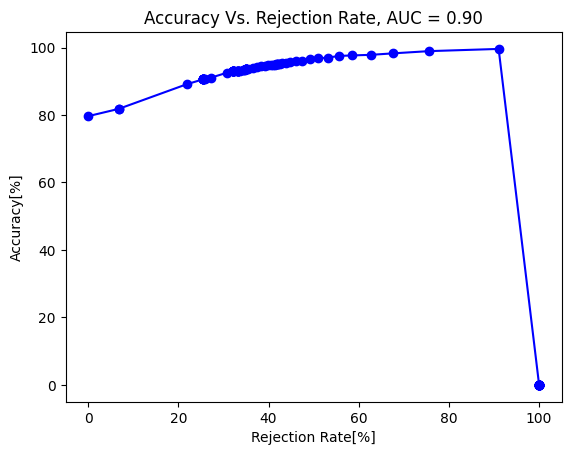

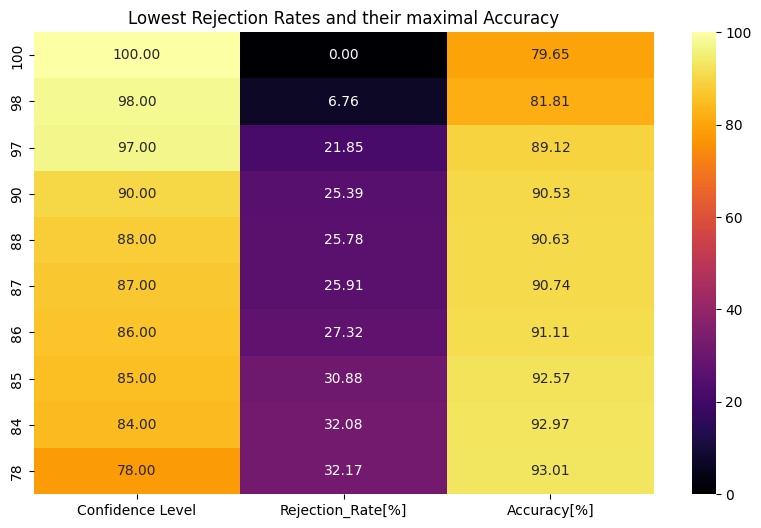

##### **Confusion Matrix**
***

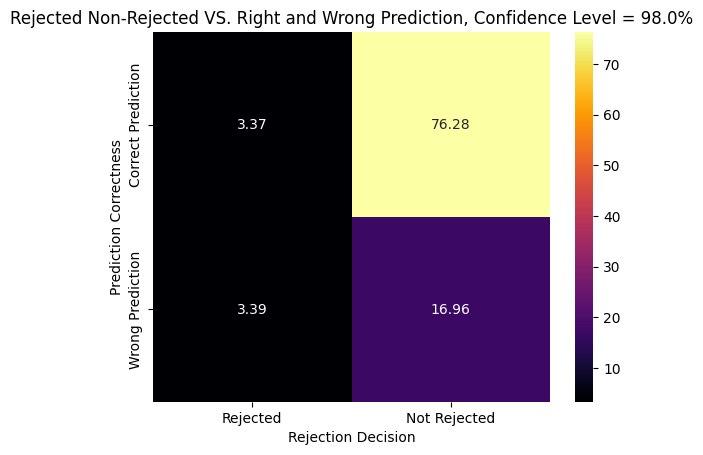

#### **Validation seed: 21**
***

##### **Calculate confidence score**
***

Targets  Predictions  IsCorrect    Probas  Threshold  Baseline  \
0           0         True      False  0.321550    0.29619  0.321550   
1           0        False       True  0.031009    0.29619  0.968991   
2           0        False       True  0.038104    0.29619  0.961896   
3           0        False       True  0.019519    0.29619  0.980481   
4           1         True       True  0.508203    0.29619  0.508203   
...       ...          ...        ...       ...        ...       ...   
5332        0         True      False  0.408512    0.29619  0.408512   
5333        0        False       True  0.065861    0.29619  0.934139   
5334        1         True       True  0.801508    0.29619  0.801508   
5335        1         True       True  0.947120    0.29619  0.947120   
5336        0        False       True  0.012450    0.29619  0.987550   

      doctor_alpha  mcmc_soft_scores  mcmc_predictions  mcmc_probas  ...  \
0         0.225972          0.758355             False     0.241645  ...   
1         0.936062          0.953302             False     0.046698  ...   
2         0.920897          0.943200             False     0.056800  ...   
3         0.960201          0.969269             False     0.030731  ...   
4         0.000538          0.469897              True     0.469897  ...   
...            ...               ...               ...          ...  ...   
5332      0.064791          0.387686              True     0.387686  ...   
5333      0.859690          0.919590             False     0.080410  ...   
5334      0.533324          0.705837              True     0.705837  ...   
5335      0.888683          0.924435              True     0.924435  ...   
5336      0.974791          0.982866             False     0.017134  ...   

      Laplace_score  Laplace_probas  TrustScore  ConfidNet_scores  \
0          0.339911        0.339911    0.924052          0.566204   
1          0.936509        0.063491    1.291472          0.950077   
2          0.932482        0.067518    1.226272          0.935607   
3          0.953912        0.046088    1.156958          0.970550   
4          0.507792        0.507792    0.926226          0.503401   
...             ...             ...         ...               ...   
5332       0.413174        0.413174    0.938454          0.517474   
5333       0.902993        0.097007    1.281148          0.889908   
5334       0.780692        0.780692    0.977375          0.621266   
5335       0.907500        0.907500    1.442724          0.868380   
5336       0.959542        0.040458    1.296394          0.982058   

      SWAG_probas  SWAG_targets  SWAG_predictions  SWAG_threshold  SWAG_score  \
0        0.219659             0             False        0.300369    0.780341   
1        0.046895             0             False        0.300369    0.953105   
2        0.065541             0             False        0.300369    0.934459   
3        0.037009             0             False        0.300369    0.962991   
4        0.389541             1              True        0.300369    0.389541   
...           ...           ...               ...             ...         ...   
5332     0.489346             0              True        0.300369    0.489346   
5333     0.119221             0             False        0.300369    0.880779   
5334     0.734722             1              True        0.300369    0.734722   
5335     0.929076             1              True        0.300369    0.929076   
5336     0.024704             0             False        0.300369    0.975296   

      Confidence_score  
0             2.649762  
1            68.939570  
2            68.124732  
3            70.107806  
4             0.000000  
...                ...  
5332          2.421713  
5333         65.262072  
5334         13.344033  
5335         66.503475  
5336         70.886719  

[5337 rows x 24 columns]

##### **Rejection**
***

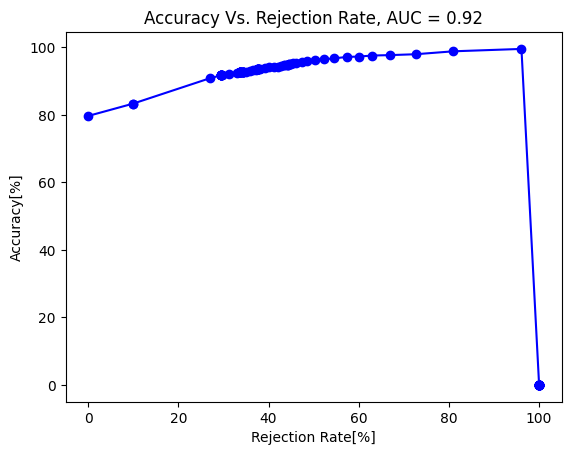

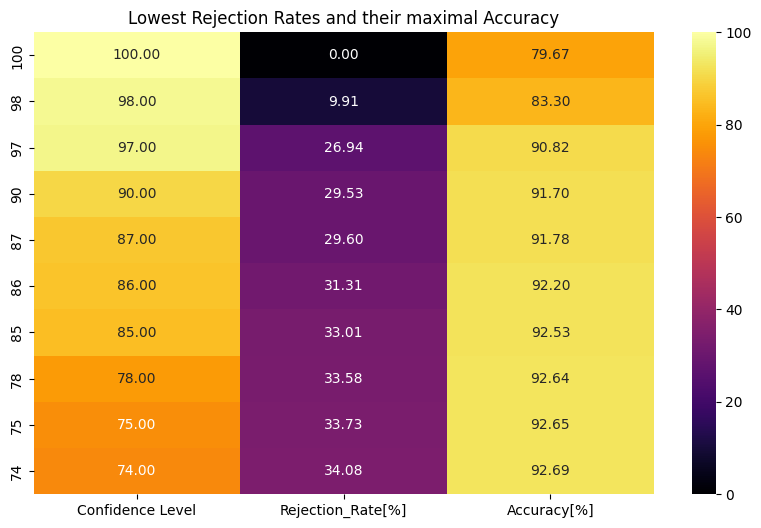

##### **Confusion Matrix**
***

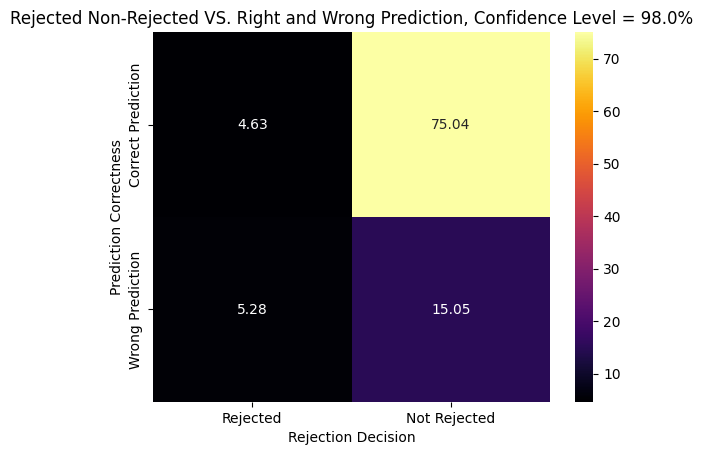

#### **Validation seed: 42**
***

##### **Calculate confidence score**
***

Targets  Predictions  IsCorrect    Probas  Threshold  Baseline  \
0           0        False       True  0.133607   0.299127  0.866393   
1           0        False       True  0.051193   0.299127  0.948806   
2           0        False       True  0.234509   0.299127  0.765491   
3           0        False       True  0.021759   0.299127  0.978241   
4           1         True       True  0.467279   0.299127  0.467279   
...       ...          ...        ...       ...        ...       ...   
5332        0        False       True  0.270805   0.299127  0.729195   
5333        0        False       True  0.064705   0.299127  0.935295   
5334        1         True       True  0.718077   0.299127  0.718077   
5335        1         True       True  0.906884   0.299127  0.906884   
5336        0        False       True  0.005742   0.299127  0.994258   

      doctor_alpha  mcmc_soft_scores  mcmc_predictions  mcmc_probas  ...  \
0         0.698742          0.859273             False     0.140727  ...   
1         0.892402          0.959722             False     0.040278  ...   
2         0.439866          0.842793             False     0.157207  ...   
3         0.955535          0.975401             False     0.024599  ...   
4         0.008528          0.437282              True     0.437282  ...   
...            ...               ...               ...          ...  ...   
5332      0.347272          0.291648              True     0.291648  ...   
5333      0.862296          0.938056             False     0.061944  ...   
5334      0.319654          0.686622              True     0.686622  ...   
5335      0.796788          0.862960              True     0.862960  ...   
5336      0.988449          0.995013             False     0.004987  ...   

      Laplace_score  Laplace_probas  TrustScore  ConfidNet_scores  \
0          0.853492        0.146508    1.008468          0.788767   
1          0.923794        0.076207    1.098191          0.908427   
2          0.751112        0.248888    1.247477          0.644048   
3          0.957669        0.042331    1.444366          0.963062   
4          0.468266        0.468266    1.074364          0.506450   
...             ...             ...         ...               ...   
5332       0.723807        0.276193    1.094813          0.632205   
5333       0.909725        0.090275    1.422165          0.893443   
5334       0.709768        0.709768    1.061580          0.591341   
5335       0.882833        0.882833    1.251781          0.819405   
5336       0.973608        0.026392    1.672861          0.991033   

      SWAG_probas  SWAG_targets  SWAG_predictions  SWAG_threshold  SWAG_score  \
0        0.139830             0             False        0.266712    0.860170   
1        0.036591             0             False        0.266712    0.963409   
2        0.024665             0             False        0.266712    0.975335   
3        0.036590             0             False        0.266712    0.963410   
4        0.427699             1              True        0.266712    0.427699   
...           ...           ...               ...             ...         ...   
5332     0.387565             0              True        0.266712    0.387565   
5333     0.057003             0             False        0.266712    0.942997   
5334     0.767467             1              True        0.266712    0.767467   
5335     0.991727             1              True        0.266712    0.991727   
5336     0.009560             0             False        0.266712    0.990440   

      Confidence_score  
0            59.906566  
1            67.940558  
2            27.991662  
3            70.122070  
4             0.000000  
...                ...  
5332          2.958638  
5333         66.513136  
5334          2.767397  
5335         64.126535  
5336         71.766503  

[5337 rows x 24 columns]

##### **Rejection**
***

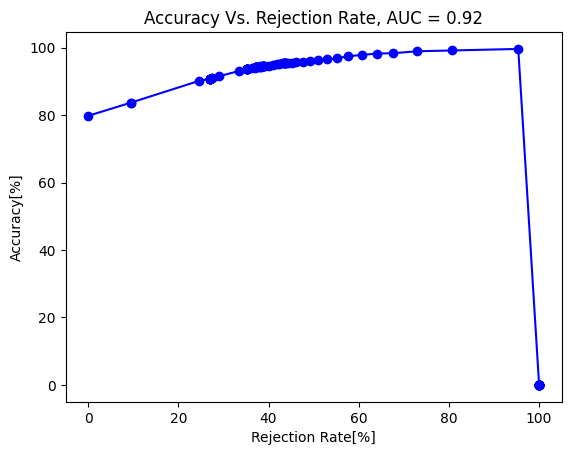

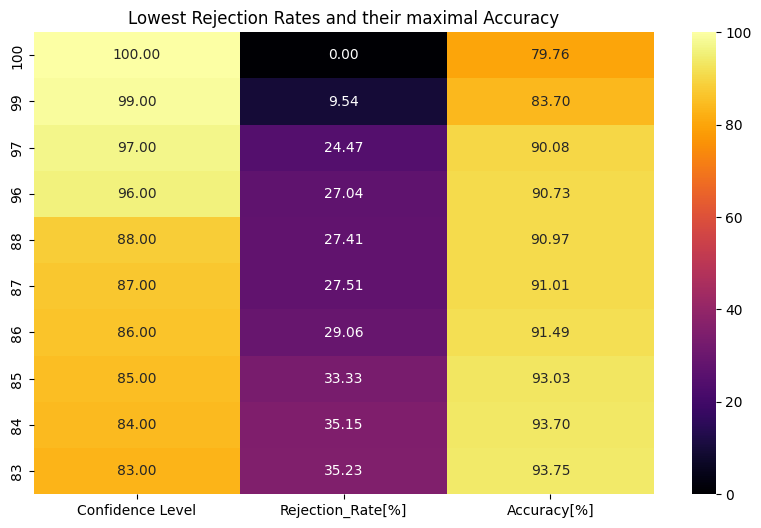

##### **Confusion Matrix**
***

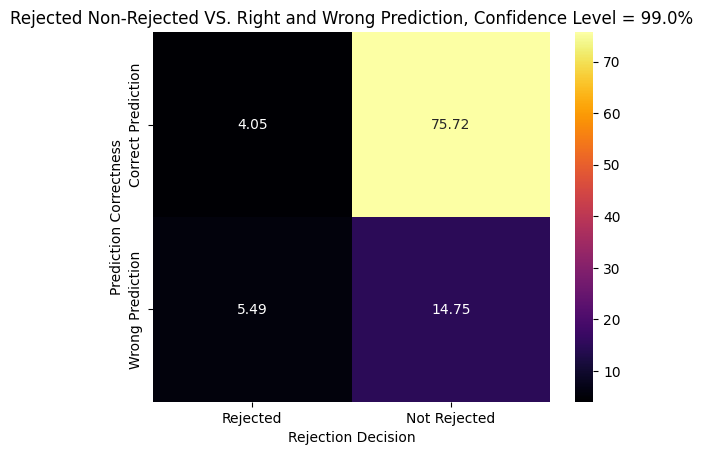

#### **Validation seed: 55**
***

##### **Calculate confidence score**
***

Targets  Predictions  IsCorrect    Probas  Threshold  Baseline  \
0           0        False       True  0.069185   0.256104  0.930815   
1           0        False       True  0.042340   0.256104  0.957660   
2           0        False       True  0.119516   0.256104  0.880484   
3           0        False       True  0.020617   0.256104  0.979383   
4           1         True       True  0.501353   0.256104  0.501353   
...       ...          ...        ...       ...        ...       ...   
5332        0         True      False  0.299088   0.256104  0.299088   
5333        0        False       True  0.041803   0.256104  0.958197   
5334        1         True       True  0.592492   0.256104  0.592492   
5335        1         True       True  0.824778   0.256104  0.824778   
5336        0        False       True  0.008859   0.256104  0.991141   

      doctor_alpha  mcmc_soft_scores  mcmc_predictions  mcmc_probas  ...  \
0         0.852162          0.910226             False     0.089774  ...   
1         0.911750          0.966602             False     0.033398  ...   
2         0.733433          0.880902             False     0.119098  ...   
3         0.957917          0.975860             False     0.024140  ...   
4         0.000015          0.450166              True     0.450166  ...   
...            ...               ...               ...          ...  ...   
5332      0.278032          0.276369              True     0.276369  ...   
5333      0.912912          0.940770             False     0.059231  ...   
5334      0.066174          0.523718              True     0.523718  ...   
5335      0.593453          0.742194              True     0.742194  ...   
5336      0.982126          0.992120             False     0.007880  ...   

      Laplace_score  Laplace_probas  TrustScore  ConfidNet_scores  \
0          0.910820        0.089180    1.170258          0.883999   
1          0.931371        0.068629    1.159251          0.929127   
2          0.855339        0.144661    1.575550          0.786745   
3          0.956010        0.043990    1.306924          0.963050   
4          0.501297        0.501297    1.012178          0.499037   
...             ...             ...         ...               ...   
5332       0.305883        0.305883    0.947422          0.584395   
5333       0.929239        0.070761    1.334533          0.920293   
5334       0.587575        0.587575    0.886118          0.518437   
5335       0.800733        0.800733    1.214010          0.709114   
5336       0.967610        0.032390    1.476120          0.983707   

      SWAG_probas  SWAG_targets  SWAG_predictions  SWAG_threshold  SWAG_score  \
0        0.202565             0             False        0.365878    0.797435   
1        0.047159             0             False        0.365878    0.952841   
2        0.091072             0             False        0.365878    0.908928   
3        0.058561             0             False        0.365878    0.941439   
4        0.400292             1              True        0.365878    0.400292   
...           ...           ...               ...             ...         ...   
5332     0.438121             0              True        0.365878    0.438121   
5333     0.099077             0             False        0.365878    0.900923   
5334     0.844504             1              True        0.365878    0.844504   
5335     0.990643             1              True        0.365878    0.990643   
5336     0.027085             0             False        0.365878    0.972915   

      Confidence_score  
0            53.278285  
1            68.475907  
2            61.539517  
3            69.860057  
4             0.000000  
...                ...  
5332          2.734893  
5333         67.368842  
5334         13.722533  
5335         46.423650  
5336         71.249085  

[5337 rows x 24 columns]

##### **Rejection**
***

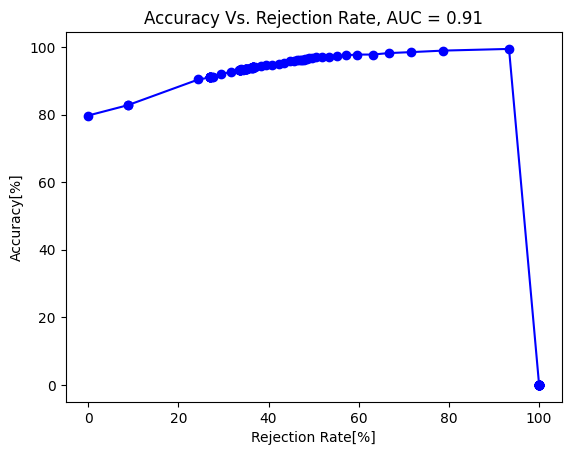

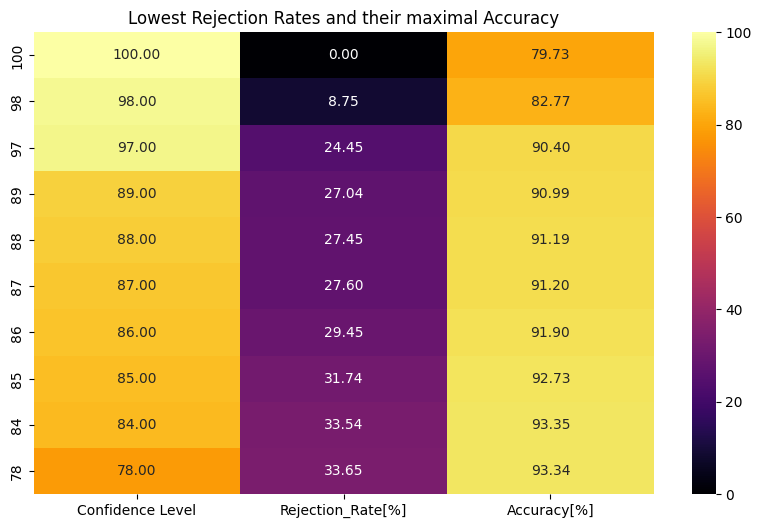

##### **Confusion Matrix**
***

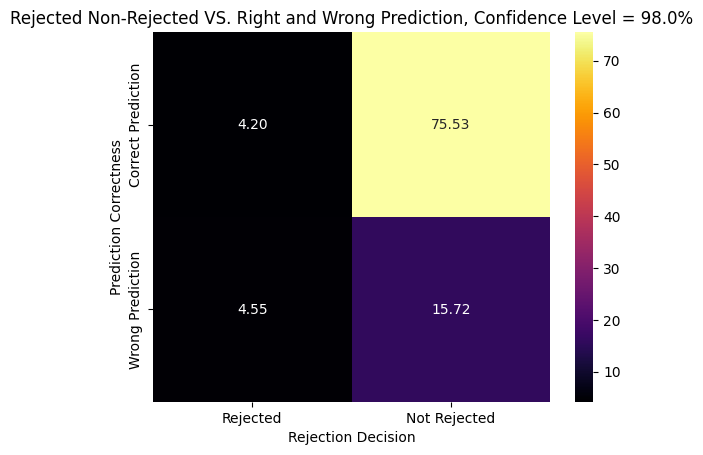

#### **Validation seed: 84**
***

##### **Calculate confidence score**
***

Targets  Predictions  IsCorrect    Probas  Threshold  Baseline  \
0           0        False       True  0.111794   0.276579  0.888206   
1           0        False       True  0.042738   0.276579  0.957262   
2           0        False       True  0.103509   0.276579  0.896491   
3           0        False       True  0.013938   0.276579  0.986062   
4           1         True       True  0.505930   0.276579  0.505930   
...       ...          ...        ...       ...        ...       ...   
5332        0         True      False  0.424185   0.276579  0.424185   
5333        0        False       True  0.028907   0.276579  0.971093   
5334        1         True       True  0.672492   0.276579  0.672492   
5335        1         True       True  0.943981   0.276579  0.943981   
5336        0        False       True  0.004062   0.276579  0.995938   

      doctor_alpha  mcmc_soft_scores  mcmc_predictions  mcmc_probas  ...  \
0         0.752196          0.878455             False     0.121545  ...   
1         0.910886          0.962467             False     0.037533  ...   
2         0.772119          0.922193             False     0.077807  ...   
3         0.971736          0.981936             False     0.018064  ...   
4         0.000281          0.454494              True     0.454494  ...   
...            ...               ...               ...          ...  ...   
5332      0.044949          0.396572              True     0.396572  ...   
5333      0.940518          0.967490             False     0.032510  ...   
5334      0.212712          0.588014              True     0.588014  ...   
5335      0.881729          0.878429              True     0.878429  ...   
5336      0.991843          0.996565             False     0.003435  ...   

      Laplace_score  Laplace_probas  TrustScore  ConfidNet_scores  \
0          0.867362        0.132638    1.173740          0.808673   
1          0.927564        0.072436    1.403481          0.930165   
2          0.862245        0.137755    1.234549          0.807743   
3          0.960933        0.039067    1.280152          0.977662   
4          0.505474        0.505474    1.152270          0.502244   
...             ...             ...         ...               ...   
5332       0.427478        0.427478    1.036702          0.508862   
5333       0.941480        0.058520    1.446135          0.957650   
5334       0.661861        0.661861    1.051672          0.554597   
5335       0.905961        0.905961    1.327819          0.838565   
5336       0.973583        0.026417    2.157376          0.994981   

      SWAG_probas  SWAG_targets  SWAG_predictions  SWAG_threshold  SWAG_score  \
0        0.133959             0             False        0.359267    0.866041   
1        0.039606             0             False        0.359267    0.960394   
2        0.037233             0             False        0.359267    0.962766   
3        0.030653             0             False        0.359267    0.969348   
4        0.429829             1              True        0.359267    0.429829   
...           ...           ...               ...             ...         ...   
5332     0.505787             0              True        0.359267    0.505787   
5333     0.056578             0             False        0.359267    0.943422   
5334     0.856770             1              True        0.359267    0.856770   
5335     0.969893             1              True        0.359267    0.969893   
5336     0.023079             0             False        0.359267    0.976921   

      Confidence_score  
0            61.552509  
1            68.455304  
2            63.774012  
3            70.730586  
4             0.000000  
...                ...  
5332          0.000000  
5333         69.201404  
5334         14.055826  
5335         66.101641  
5336         71.694326  

[5337 rows x 24 columns]

##### **Rejection**
***

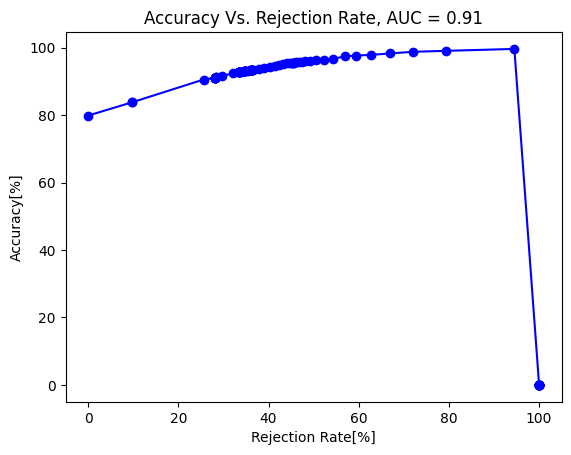

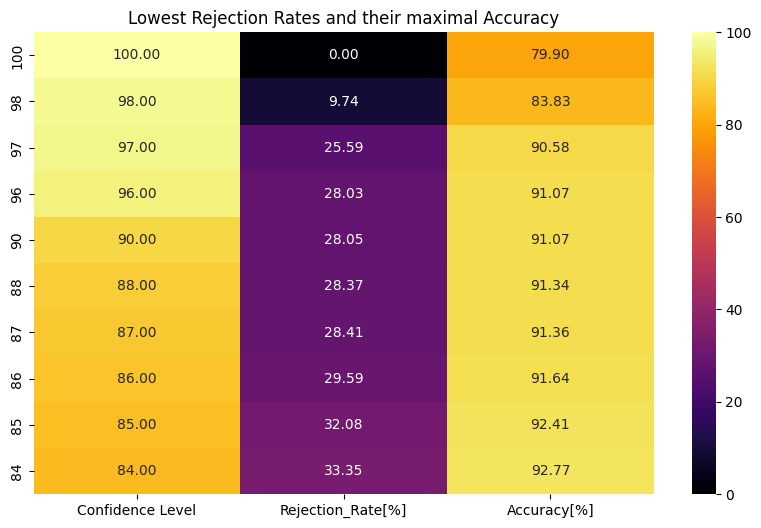

##### **Confusion Matrix**
***

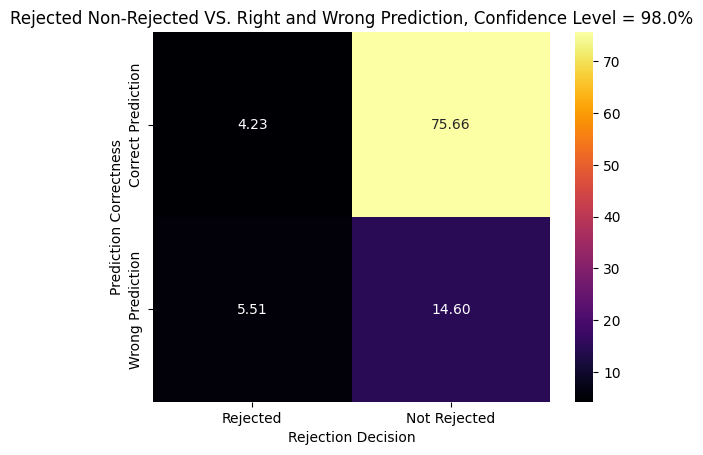

## **Average AUC summary**
***

Seed  Average_AUC
0  10.0     0.854061
1  21.0     0.878719
2  42.0     0.881987
3  55.0     0.932054
4  84.0     0.909364

Best seed is: 55.0 with AUC: 0.93

In [13]:
from failure_detection.validate import get_parameters_and_validate
seeds = [10,21,42,55,84]
get_parameters_and_validate(train_seeds=seeds,validation_seeds=seeds)


look at that - the first one we tested is actually the best! So, let's use seed 15 as our test set and give our rejector a final evaluation:

## **Train seed: 55**
***

### **Thresholding**
***

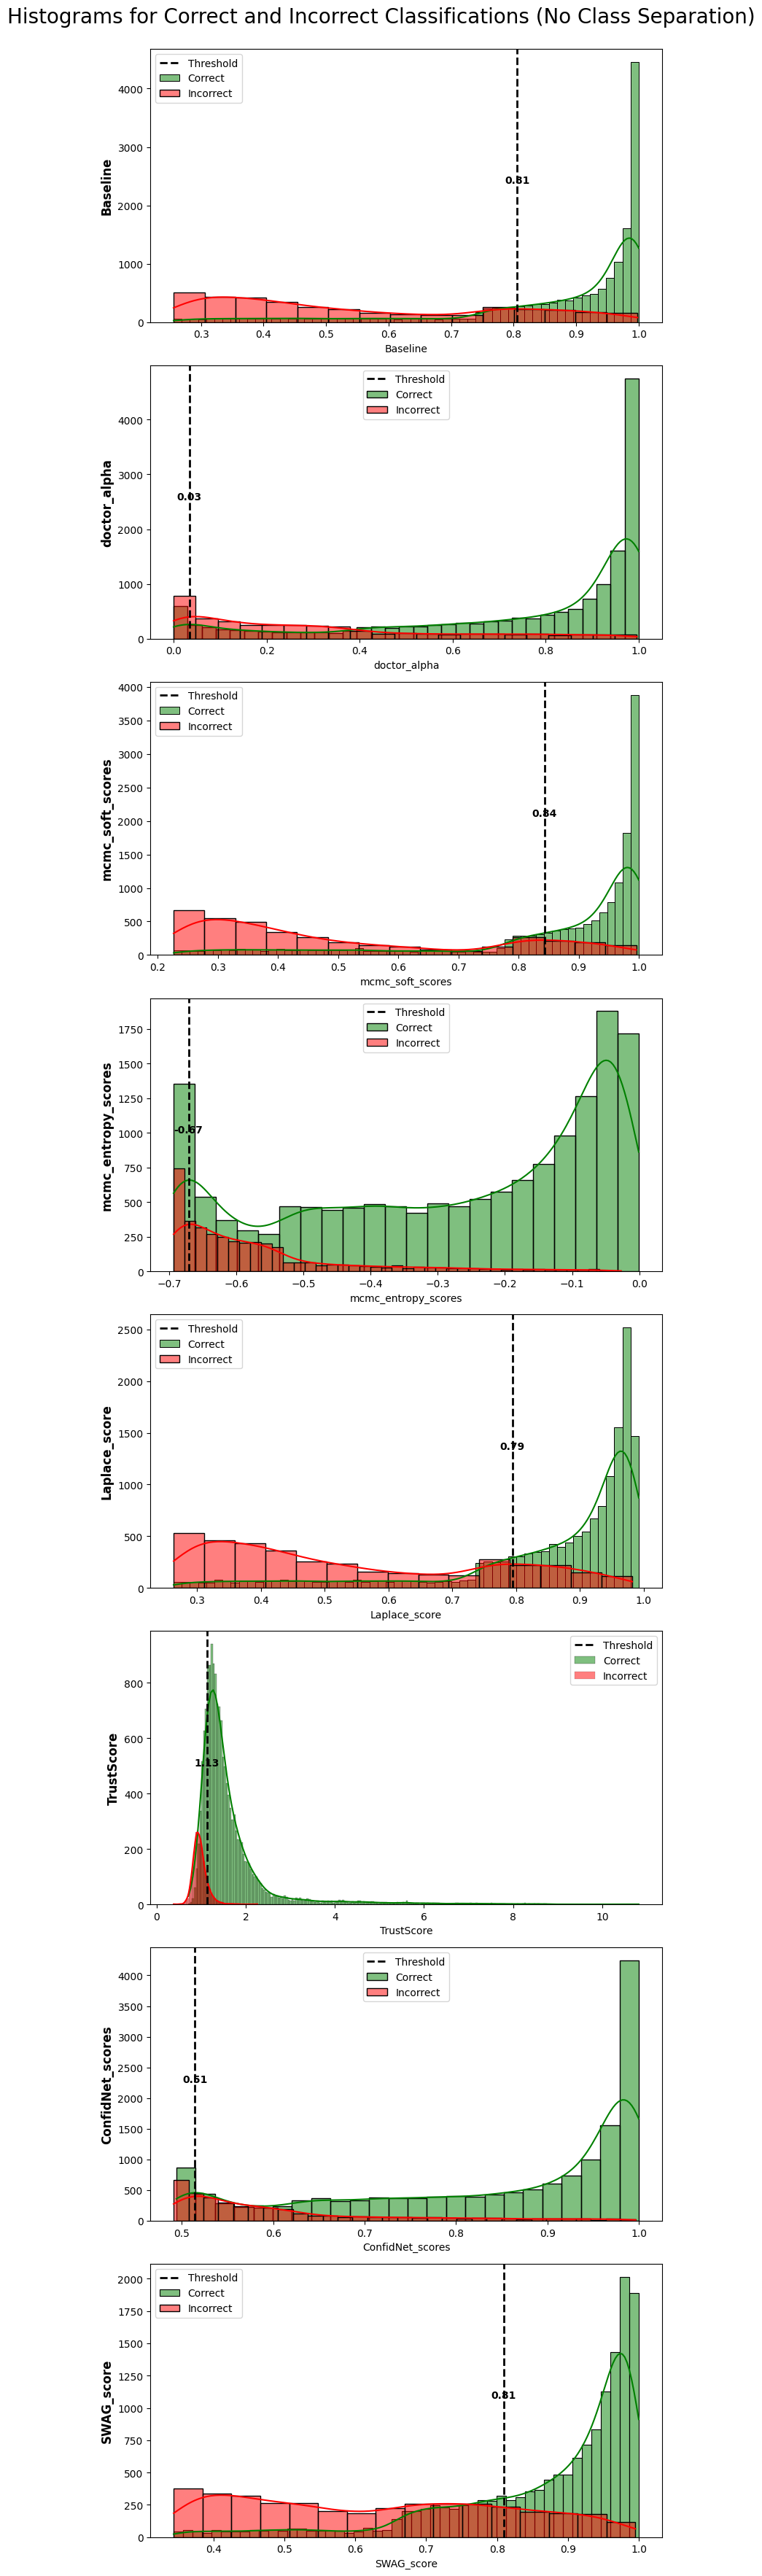

Seed    Scoring_Method  Threshold
0    55          Baseline   0.805641
1    55      doctor_alpha   0.034032
2    55  mcmc_soft_scores   0.843542
3    55     Laplace_score   0.794364
4    55  ConfidNet_scores   0.514500
5    55        SWAG_score   0.809392

### **Finding Optimal weights**
***

Scoring_Method  Threshold Rejection_Direction    Weight
0          Baseline   0.805641                   <  0.803505
1      doctor_alpha   0.034032                   <  0.176314
2  mcmc_soft_scores   0.843542                   <  0.858968
3     Laplace_score   0.794364                   <  0.817300
4  ConfidNet_scores   0.514500                   <  0.233404
5        SWAG_score   0.809392                   <  0.789364

### **Validation process**
***

#### **Validation seed: 15**
***

##### **Calculate confidence score**
***

Targets  Predictions  IsCorrect    Probas  Threshold  Baseline  \
0           0        False       True  0.134420   0.263826  0.865580   
1           0        False       True  0.058552   0.263826  0.941447   
2           0        False       True  0.070946   0.263826  0.929054   
3           0        False       True  0.008814   0.263826  0.991186   
4           1         True       True  0.506671   0.263826  0.506671   
...       ...          ...        ...       ...        ...       ...   
5332        0         True      False  0.432825   0.263826  0.432825   
5333        0        False       True  0.054226   0.263826  0.945774   
5334        1         True       True  0.739580   0.263826  0.739580   
5335        1         True       True  0.945485   0.263826  0.945485   
5336        0        False       True  0.003917   0.263826  0.996083   

      doctor_alpha  mcmc_soft_scores  mcmc_predictions  mcmc_probas  ...  \
0         0.696724          0.870957             False     0.129043  ...   
1         0.876091          0.948718             False     0.051282  ...   
2         0.848159          0.953704             False     0.046296  ...   
3         0.982217          0.991661             False     0.008339  ...   
4         0.000356          0.396178              True     0.396178  ...   
...            ...               ...               ...          ...  ...   
5332      0.035459          0.389899              True     0.389899  ...   
5333      0.885706          0.939162             False     0.060838  ...   
5334      0.373448          0.573210              True     0.573210  ...   
5335      0.885065          0.864928              True     0.864928  ...   
5336      0.992135          0.996911             False     0.003089  ...   

      Laplace_score  Laplace_probas  TrustScore  ConfidNet_scores  \
0          0.848754        0.151246    1.109333          0.777262   
1          0.917835        0.082165    1.320331          0.905429   
2          0.902683        0.097317    1.241323          0.864452   
3          0.974913        0.025087    1.443855          0.984441   
4          0.506349        0.506349    1.009546          0.499826   
...             ...             ...         ...               ...   
5332       0.435623        0.435623    0.998640          0.497749   
5333       0.921474        0.078526    1.272191          0.898906   
5334       0.728727        0.728727    1.033838          0.649576   
5335       0.919058        0.919058    1.492106          0.911150   
5336       0.979303        0.020697    1.970519          0.993931   

      SWAG_probas  SWAG_targets  SWAG_predictions  SWAG_threshold  SWAG_score  \
0        0.220461             0             False        0.352471    0.779539   
1        0.042441             0             False        0.352471    0.957558   
2        0.095070             0             False        0.352471    0.904930   
3        0.024513             0             False        0.352471    0.975487   
4        0.660940             1              True        0.352471    0.660940   
...           ...           ...               ...             ...         ...   
5332     0.541229             0              True        0.352471    0.541229   
5333     0.099843             0             False        0.352471    0.900158   
5334     0.885170             1              True        0.352471    0.885170   
5335     0.988401             1              True        0.352471    0.988401   
5336     0.009853             0             False        0.352471    0.990147   

      Confidence_score  
0            40.692791  
1            57.386392  
2            56.151544  
3            60.299857  
4             0.000000  
...                ...  
5332          0.104200  
5333         56.604810  
5334         15.269665  
5335         56.711964  
5336         60.759313  

[5337 rows x 24 columns]

##### **Rejection**
***

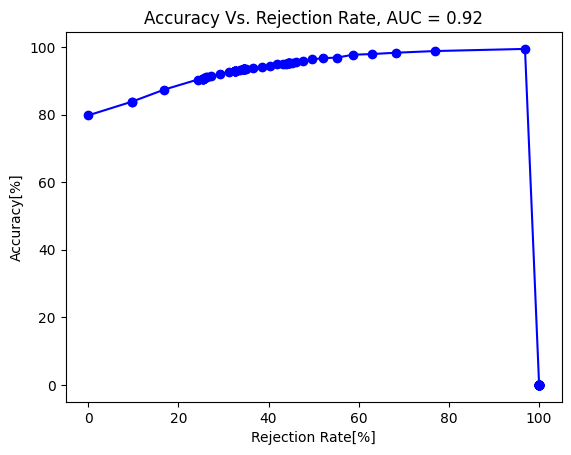

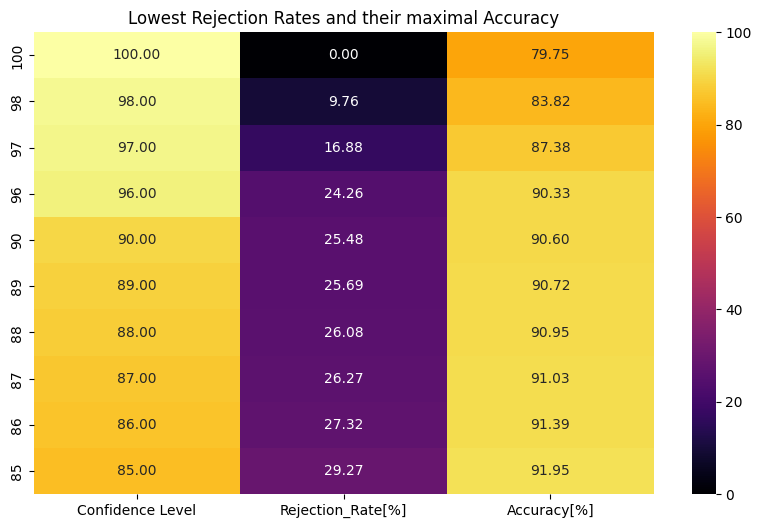

##### **Confusion Matrix**
***

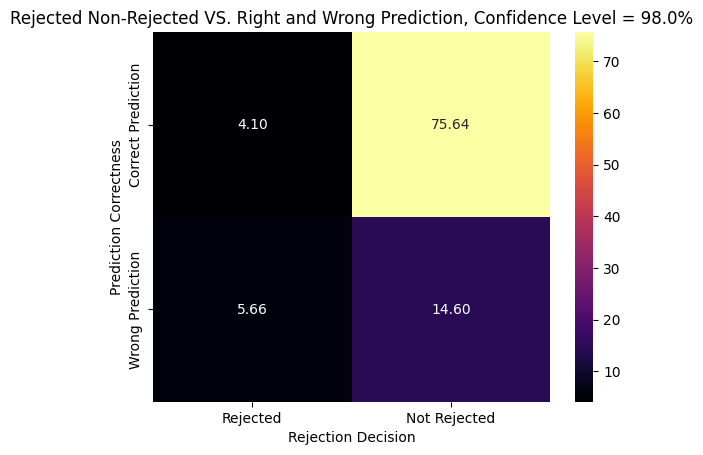

## **Average AUC summary**
***

Seed  Average_AUC
0  55.0     0.924042

Best seed is: 55.0 with AUC: 0.92

In [14]:
train_seed = 55
validation_seed = 15
get_parameters_and_validate(train_seeds=np.array([train_seed]),validation_seeds=np.array([validation_seed]))

## **Conclusions**
***

* After validating over 5 different seeds, we came to a conclusion that seed 15 gave us the best performance with average AUC of 0.93. 0.92 AUC  gained when testing on seed 15.
* We can see that when lowering the confidence level to 98%, the rejector rejects about 10% of the data, but improves the accuracy of the model by 4%.
* However, we can see a drawback -  the rejector rejected a quite similar percentage of wrong and correct predictions which means that it is very strict. Perhaps a more compromising thresholds would have been better.